In [1]:
# Suppress annoying warning messages
import warnings
warnings.filterwarnings(action='ignore', category=Warning)

########## Basic modules ##########
import numpy as np
import pandas as pd
import math
import glob
import os
# from scipy.optimize import fsolve

########## Custom modules that contain functions for accretion, torque, kicks etc ##########
from accretion_utils import *
from posttrans_utils import *

########## Module for TULIPS ##########
import mesaPlot as mp
import tulips

########## THE module ##########
from astropy import units as u
from astropy import constants as const
from astropy.units import Quantity

########## Type annotation ##########
from typing import Any, Union, Optional, List, TypeVar

########## Modules for plotting ##########
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from matplotlib.lines import Line2D
import matplotlib.transforms as mtrans
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
try:
    import scienceplots
except ModuleNotFoundError:
    !pip install SciencePlots
    import scienceplots

%matplotlib inline

In [2]:
col_names = [
    'E_center', 
    'Radius', 
    'Mass', 
    'Quad', 
    'Baryon_M', 
    'Jstar', 
    'Om_surf'
]

# Example data file
df = pd.read_csv("data/ACB5/ACB5_J=0.05.dat", skiprows=1, delim_whitespace=True, names=col_names)
df

,E_center,Radius,Mass,Quad,Baryon_M,Jstar,Om_surf
0,100.000000,2.277005e+10,2.792983e+06,7.953544e+29,2.955268e+06,0.05,2.828064e+07
1,106.122449,1.661940e+09,3.857110e+05,2.150388e+26,4.066067e+05,0.05,1.074314e+07
2,112.244898,6.694380e+07,2.734579e+04,4.154136e+21,2.874544e+04,0.05,2.895147e+06
3,118.367347,4.528939e+06,2.996426e+03,4.680729e+17,3.143499e+03,0.05,9.632681e+05
4,124.489796,5.282139e+05,5.316853e+02,3.669870e+14,5.570129e+02,0.05,4.060166e+05
...,...,...,...,...,...,...,...
195,1771.812081,9.876983e+00,2.000437e+00,2.959734e-03,2.377199e+00,0.05,2.733688e+02
196,1781.208054,9.866150e+00,2.000254e+00,2.944045e-03,2.376913e+00,0.05,2.731820e+02
197,1790.604027,9.856303e+00,2.000056e+00,2.929627e-03,2.376602e+00,0.05,2.730875e+02
198,1800.000000,9.846447e+00,1.999843e+00,2.915429e-03,2.376259e+00,0.05,2.729942e+02


Combine all separate datafiles into one file

In [3]:
# Path to the data files
path = '/Users/schanlar/Desktop/Projects/LMXB/data_analysis/data/ACB5'  

# Use glob to find all CSV files in the directory
all_files = sorted(glob.glob(os.path.join(path, "ACB5_J=0.*.dat")))

# Initialize an empty list to hold the DataFrames
df_list = []

# Loop over the list of files and read each one into a DataFrame
for file in all_files:
    df = pd.read_csv(file, skiprows=1, delim_whitespace=True, names=col_names)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

### Write the combined DataFrame to a new CSV file ###
# combined_df.to_csv('combined_ACB5_data.csv', index=False)
# print("Data combined successfully into 'combined_ACB5_data.csv'")

In [4]:
df = pd.read_csv("data/ACB5/combined_ACB5_data.csv")
df

,E_center,Radius,Mass,Quad,Baryon_M,Jstar,Om_surf
0,100.000000,31.629888,0.121311,0.000000,0.121793,0.00,0.000000
1,106.122449,27.312850,0.130235,0.000000,0.130836,0.00,0.000000
2,112.244898,24.160742,0.140343,0.000000,0.141094,0.00,0.000000
3,118.367347,21.886025,0.151161,0.000000,0.152092,0.00,0.000000
4,124.489796,20.171618,0.162737,0.000000,0.163882,0.00,0.000000
...,...,...,...,...,...,...,...
1995,1771.812081,9.930980,2.015457,0.242127,2.399012,0.45,2704.748423
1996,1781.208054,9.920070,2.015142,0.240807,2.398478,0.45,2703.873027
1997,1790.604027,9.910173,2.014824,0.239594,2.398190,0.45,2703.758077
1998,1800.000000,9.899663,2.014631,0.238421,2.397611,0.45,2703.657014


## Load tabulated EoS data

In [5]:
#Import tabulated data

ACB5file = np.genfromtxt('data/ACB5/combined_ACB5_data.csv', delimiter=',', skip_header=1)

energy_tab = ACB5file[:,0]
mass_tab = ACB5file[:,2]                  # value given in M_sol
mass_bar_tab = ACB5file[:,4]              # value given in M_sol
radius_tab = ACB5file[:,1]                # value given in km
angular_momentum_tab = ACB5file[:,5]      # value given in G M_sun^2 / c
spin_frequency_tab = ACB5file[:,6]        # value given in Hz

## Load Danchev's data

In [6]:
# TODO: optimize this later (maybe)

data_static = np.genfromtxt("data/ACB5/ACB5_Static.dat", skip_header=1)
data_shed = np.genfromtxt("data/ACB5/ACB5_Shedding.dat", skip_header=1)
data_J0p05 = np.genfromtxt("data/ACB5/ACB5_J=0.05.dat", skip_header=1)
data_J0p1 = np.genfromtxt("data/ACB5/ACB5_J=0.1.dat", skip_header=1)
data_J0p15 = np.genfromtxt("data/ACB5/ACB5_J=0.15.dat", skip_header=1)
data_J0p2 = np.genfromtxt("data/ACB5/ACB5_J=0.2.dat", skip_header=1)
data_J0p25 = np.genfromtxt("data/ACB5/ACB5_J=0.25.dat", skip_header=1)
data_J0p3 = np.genfromtxt("data/ACB5/ACB5_J=0.3.dat", skip_header=1)
data_J0p35 = np.genfromtxt("data/ACB5/ACB5_J=0.35.dat", skip_header=1)
data_J0p4 = np.genfromtxt("data/ACB5/ACB5_J=0.4.dat", skip_header=1)
data_J0p45 = np.genfromtxt("data/ACB5/ACB5_J=0.45.dat", skip_header=1)
###
data_omega100 = np.genfromtxt("data/ACB5/ACB5_Om=100.dat", skip_header=1)
data_omega200 = np.genfromtxt("data/ACB5/ACB5_Om=200.dat", skip_header=1)
data_omega300 = np.genfromtxt("data/ACB5/ACB5_Om=300.dat", skip_header=1)
data_omega400 = np.genfromtxt("data/ACB5/ACB5_Om=400.dat", skip_header=1)
data_omega500 = np.genfromtxt("data/ACB5/ACB5_Om=500.dat", skip_header=1)
data_omega600 = np.genfromtxt("data/ACB5/ACB5_Om=600.dat", skip_header=1)
data_omega700 = np.genfromtxt("data/ACB5/ACB5_Om=700.dat", skip_header=1)
data_omega800 = np.genfromtxt("data/ACB5/ACB5_Om=800.dat", skip_header=1)
data_omega900 = np.genfromtxt("data/ACB5/ACB5_Om=900.dat", skip_header=1)
data_omega1000 = np.genfromtxt("data/ACB5/ACB5_Om=1000.dat", skip_header=1)

## Load model data

In [7]:
model_m1 = pd.read_csv("data/model_m1.csv")
model_m2 = pd.read_csv("data/model_m2.csv")
model_m3 = pd.read_csv("data/model_m3.csv")

model_m1.head(5)

,age [yr],donor_star_mass [Msun],donor_star_radius [Rsun],mass_transfer_rate [Msun/yr],mass_accretion_rate [Msun/yr],neutron_star_mass [Msun],neutron_star_radius [km],neutron_star_angular_momentum [Msun^2 / (c * G)],neutron_star_spin_frequency [Hz],neutron_star_spin_equilibrium_frequency [Hz],neutron_star_torque [kg * m^2 / s^2],neutron_star_magnetic_radius [km],neutron_star_corotation_radius [km],neutron_star_light_cylinder_radius [km],binary_separation [Rsun],orbital_period [days],neutron_star_bar_mass [Msun]
0,100000.0,1.0,0.897205,1.000000e-99,1.000000e-99,1.0,13.301571,0.000000e+00,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412104,21.202647,8.000000,1.069235
1,220000.0,1.0,0.897208,1.000000e-99,1.000000e-99,1.0,13.301571,-1.525970e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412088,21.202647,7.999999,1.069235
2,364000.0,1.0,0.897198,1.000000e-99,1.000000e-99,1.0,13.301571,-3.357134e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412082,21.202646,7.999999,1.069235
3,536800.0,1.0,0.897167,1.000000e-99,1.000000e-99,1.0,13.301571,-5.554530e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940420,47042.412147,21.202645,7.999998,1.069235
4,744160.0,1.0,0.897102,1.000000e-99,1.000000e-99,1.0,13.301571,-8.191406e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940421,47042.412201,21.202644,7.999998,1.069235


In [8]:
# Rename columns of dataframe

mapper = {
    "age [yr]" : "age",
    "donor_star_mass [Msun]" : "don_mass",
    "donor_star_radius [Rsun]" : "don_radius",
    "mass_transfer_rate [Msun/yr]" : "mdot_transfer",
    "mass_accretion_rate [Msun/yr]" : "mdot",
    "neutron_star_mass [Msun]" : "ns_mass",
    "neutron_star_radius [km]" : "ns_radius",
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : "ns_ang_mom",
    "neutron_star_spin_frequency [Hz]" : "ns_fspin",
    "neutron_star_spin_equilibrium_frequency [Hz]" : "ns_eq_fspin",
    "neutron_star_torque [kg * m^2 / s^2]" : "ns_torque",
    "neutron_star_magnetic_radius [km]" : "ns_r_mag",
    "neutron_star_corotation_radius [km]" : "ns_r_cor",
    "neutron_star_light_cylinder_radius [km]" : "ns_r_lc",
    "binary_separation [Rsun]" : "binary_separation",
    "orbital_period [days]" : "orbital_period",
    "neutron_star_bar_mass [Msun]" : "ns_mass_bar",
}

In [9]:
model_m1.rename(columns=mapper, inplace=True)
model_m2.rename(columns=mapper, inplace=True)
model_m3.rename(columns=mapper, inplace=True)

In [10]:
model_m2.head(1)

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period,ns_mass_bar
0,100000.0,1.0,0.897205,1.000000e-99,1.000000e-99,1.2,13.516911,0.0,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343237,146596.87361,21.887071,8.0,1.302284


## Load model data for posttransition evolution

In [11]:
model_m2_posttrans = pd.read_csv("data/posttrans_evolution_m2.csv")
model_m3_posttrans = pd.read_csv("data/posttrans_evolution_m3.csv")
model_m2_posttrans.head(1)

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period
0,1.234644e+10,0.364481,16.7895,4.143052e-09,4.143052e-09,1.490003,13.68,0.321839,732.640431,674.368562,-6.539579e+26,22.249221,21.053248,65.125332,65.542514,45.228652


## Style of plots

In [12]:
plt.style.use(["default", "science"]) # to produce figures for paper

### Transition indeces (see second notebook: 2.Identify_Evolutionary_Stages.ipynb)

In [13]:
transition_idx_case2 = 36130
transition_idx_case3 = 25716

In [14]:
def ns_radius_trans(ns_mass):
    """
    Args:
    -----
    ns_mass  : Mass of neutron star; unit [Msun]

    Return:
    -------
    Neutron star radius; unit [km]
    """
    ns_mass = u.Quantity(ns_mass, u.Msun).decompose()
    return (
        1.372631822399999990e01
        + ((ns_mass / u.Msun) - 1.402221574999999998e00) * 9.047860488123854
    ) * u.km

# The ACB5 EoS

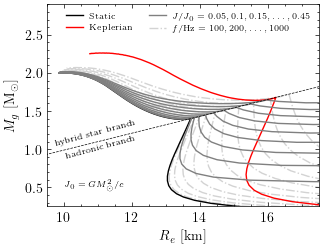

In [15]:
custom_lines = [Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='r', lw=1),
                Line2D([0], [0], color='grey', lw=1),
               Line2D([0], [0], color='lightgrey', lw=1, ls='-.')]

s=6                   # size for legend/text
col=2                 # 2 for gravitational mass, 4 for baryon mass
color1 = "grey"
color2 = "lightgrey"

# Constant angular momentum lines
plt.plot(data_static[:,1], data_static[:, col], lw=1, c='k')
plt.plot(data_shed[:,1], data_shed[:, col], lw=1, c='r')
plt.plot(data_J0p05[:,1], data_J0p05[:, col], lw=1, c=color1)
plt.plot(data_J0p1[:,1], data_J0p1[:, col], lw=1, c=color1)
plt.plot(data_J0p15[:,1], data_J0p15[:, col], lw=1, c=color1)
plt.plot(data_J0p2[:,1], data_J0p2[:, col], lw=1, c=color1)
plt.plot(data_J0p25[:,1], data_J0p25[:, col], lw=1, c=color1)
plt.plot(data_J0p3[:,1], data_J0p3[:, col], lw=1, c=color1)
plt.plot(data_J0p35[:,1], data_J0p35[:, col], lw=1, c=color1)
plt.plot(data_J0p4[:,1], data_J0p4[:, col], lw=1, c=color1)
plt.plot(data_J0p45[:,1], data_J0p45[:, col], lw=1, c=color1)

# Constant frequency lines
plt.plot(data_omega100[:,1], data_omega100[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega200[:,1], data_omega200[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega300[:,1], data_omega300[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega400[:,1], data_omega400[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega500[:,1], data_omega500[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega600[:,1], data_omega600[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega700[:,1], data_omega700[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega800[:,1], data_omega800[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega900[:,1], data_omega900[:,col], lw=1, ls='-.', c=color2, zorder=0)
plt.plot(data_omega1000[:,1], data_omega1000[:,col], lw=1, ls='-.', c=color2, zorder=0)


# Figure properties
plt.xlabel(r"$R_e$ [km]")
plt.ylabel(r"$M_g$ [M$_\odot$]")
plt.ylim([0.25, 2.9])
plt.xlim([9.5, 17.5])
plt.text(10, 0.5, r"$J_0 = G M_\odot^2 / c$", size=s)

# # Not quite accurate; the sole purpose of this line is to guide the eye
# y = lambda x : (1.25*x/10)-0.15
# plt.plot(np.linspace(5, 20, 1000), y(np.linspace(5, 20, 1000)), lw=1, ls='--', c='k')

# Transition line
plt.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='k', lw=0.5)


plt.text(10, 0.88, "hadronic branch", rotation=15, size=s)
plt.text(9.7, 1.05, "hybrid star branch", rotation=15, size=s)

# The legend
plt.legend(custom_lines, ["Static",
                          "Keplerian",
                          r"$J/J_0 = 0.05, 0.1, 0.15, \dots, 0.45$",
                          r"$f/{\rm Hz} = 100, 200, \dots, 1000$"],
          loc="upper right", ncol=2, frameon=False, prop={"size":s})


# R_bar = [13.14, 13.16, 13.24, 13.325, 13.435, 13.56, 13.7, 13.82, 13.83, 13.81]
# M_bar = [1.559, 1.564, 1.573, 1.59, 1.613, 1.645, 1.685, 1.73, 1.785, 1.846]

# plt.plot(R_bar, M_bar, c='magenta', lw=1, marker='o', markersize=0)


plt.show()
# plt.savefig("ACB5_MvR.pdf", bbox_inches="tight", dpi=300)

# Summary of the evolution for models M1, M2, and M3

In [16]:
# Convert some Pandas Series to astropy Quantities for convenience

torque_case1 = (model_m1["ns_torque"].to_numpy()) * u.kg * u.m**2 / u.s**2
torque_case2 = (model_m2["ns_torque"].to_numpy()) * u.kg * u.m**2 / u.s**2
torque_case3 = (model_m3["ns_torque"].to_numpy()) * u.kg * u.m**2 / u.s**2

ns_fspin_case1 = (model_m1["ns_fspin"].to_numpy()) * u.Hz
ns_fspin_case2 = (model_m2["ns_fspin"].to_numpy()) * u.Hz
ns_fspin_case3 = (model_m3["ns_fspin"].to_numpy()) * u.Hz

torque_case2_posttrans = model_m2_posttrans["ns_torque"].to_numpy() * (u.kg * (u.m**2) / (u.s**2))
torque_case3_posttrans = model_m3_posttrans["ns_torque"].to_numpy() * (u.kg * (u.m**2) / (u.s**2))

In [17]:
# Calculate corotation radius, ligh cylinder radius, and equilibrium spin frequency

# r_cor_case1 = corotation_radius(model_m1["ns_fspin"], model_m1["ns_mass"])
# r_lc_case1 = lc_radius(model_m1["ns_fspin"])
# ns_fspin_eq_case1 = eq_spin_frequency(model_m1["ns_mass"], model_m1["ns_r_mag"])

r_cor_case1 = (model_m1["ns_r_cor"].to_numpy()) * u.km
r_lc_case1 = (model_m1["ns_r_lc"].to_numpy()) * u.km
ns_fspin_eq_case1 = (model_m1["ns_eq_fspin"].to_numpy()) * u.Hz

# ----

# r_cor_case2 = corotation_radius(model_m2["ns_fspin"], model_m2["ns_mass"])
# r_lc_case2 = lc_radius(model_m2["ns_fspin"])
# ns_fspin_eq_case2 = eq_spin_frequency(model_m2["ns_mass"], model_m2["ns_r_mag"])

r_cor_case2 = (model_m2["ns_r_cor"].to_numpy()) * u.km
r_lc_case2 = (model_m2["ns_r_lc"].to_numpy()) * u.km
ns_fspin_eq_case2 = (model_m2["ns_eq_fspin"].to_numpy()) * u.Hz

# ----

# r_cor_case3 = corotation_radius(model_m3["ns_fspin"], model_m3["ns_mass"])
# r_lc_case3 = lc_radius(model_m3["ns_fspin"])
# ns_fspin_eq_case3 = eq_spin_frequency(model_m3["ns_mass"], model_m3["ns_r_mag"])

r_cor_case3 = (model_m3["ns_r_cor"].to_numpy()) * u.km
r_lc_case3 = (model_m3["ns_r_lc"].to_numpy()) * u.km
ns_fspin_eq_case3 = (model_m3["ns_eq_fspin"].to_numpy()) * u.Hz

In [18]:
def eddington_limit(ns_mass_init):
    ns_mass_init = u.Quantity(ns_mass_init, u.Msun)
    return 1.5 * 1e-8 * (ns_mass_init/(1.3*u.Msun))

def set_tick_locators(ax):
    """Sets the tick locators for major and minor ticks on both axes."""
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator())

In [19]:
# plt.style.use(["default", "science"])

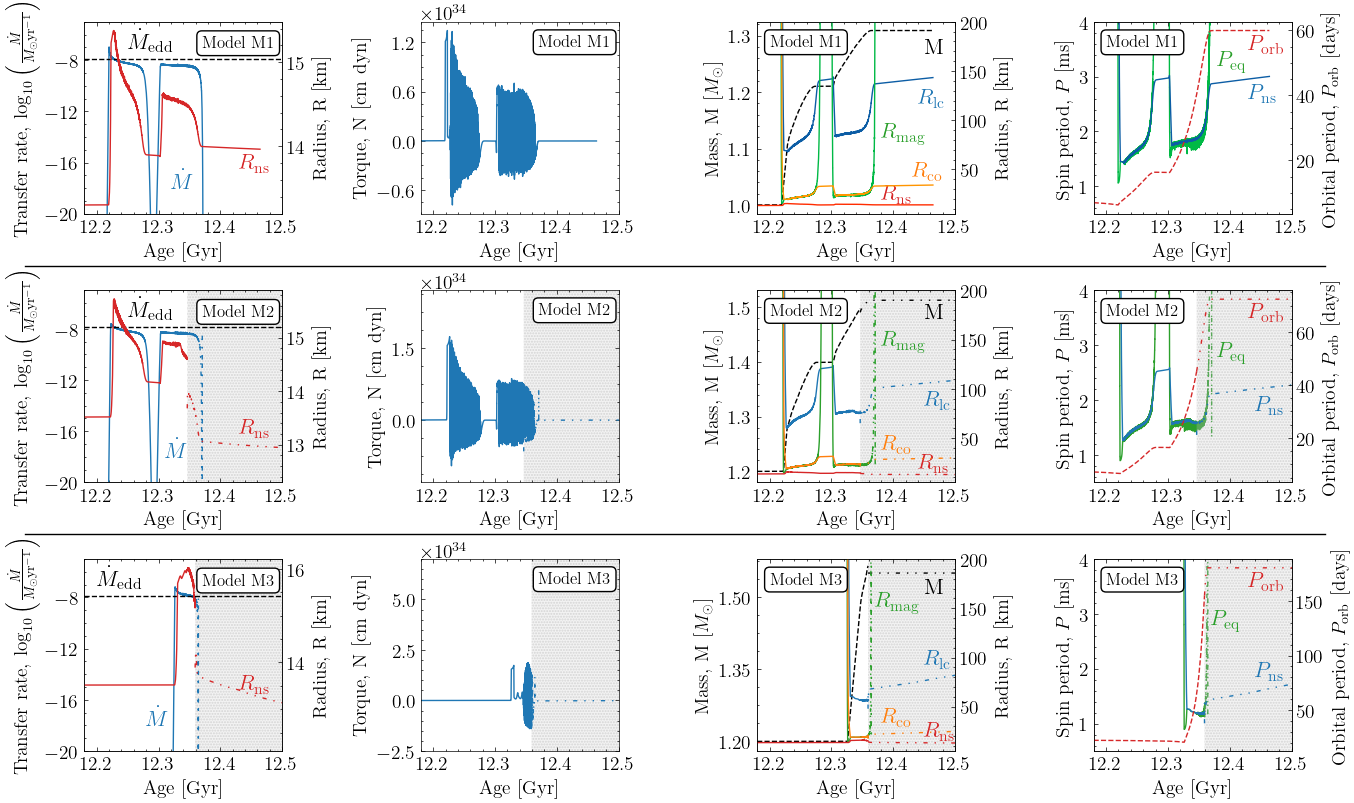

In [20]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,4, figsize=(13,8), sharex=False)
fig.tight_layout()
plt.subplots_adjust(
                    wspace=0.7,
                    hspace=0.4
)

# Apply to all axes in the original subplot grid
for row in ax:
    for axis in row:
        set_tick_locators(axis)

# # List of all twin axes created with twinx()
# twin_axes = [ax002, ax012, ax032, ax102, ax122, ax132, ax202, ax222, ax232]

# # Apply to all twin axes
# for twin_ax in twin_axes:
#     set_tick_locators(twin_ax)


# Add separating line between subplots
##
ax[0,0].plot([0, 1.0],[0.66, 0.66], color='k', lw=1,
         transform=plt.gcf().transFigure, clip_on=False)

ax[0,0].plot([0, 1.0],[0.325, 0.325], color='k', lw=1,
         transform=plt.gcf().transFigure, clip_on=False)
##


# The linewidth for line plots
lw=1

# The linestyle for posttransition evolution
ls = (0, (3, 5, 1, 5, 1, 5))

# Fontsize for case labels
case_label_fontsize=12

# Fontsize for data labels
labels_fontsize=16

# Top panel
ax[0,0].plot(model_m1["age"]/1e9, 
             np.log10(model_m1["mdot_transfer"]),
             c='tab:blue', 
             lw=lw
)
ax[0,0].axhline(
             np.log10(eddington_limit(model_m1["ns_mass"][0])),
             ls='--',
             lw=lw,
             c='k'
)
ax[0,0].text(12.32, -18, r'$\dot{M}$', c='tab:blue', fontsize=labels_fontsize)
ax[0,0].text(12.25, -7.0, r'$\dot{M}_\mathrm{edd}$', c='k', fontsize=labels_fontsize)
ax[0,0].set_xlabel('Age [Gyr]')
ax[0,0].set_ylabel(r'Transfer rate, $\log_{10} \left( \frac{\dot{M}}{M_\odot \rm yr^{-1}} \right)$')
ax[0,0].set_xlim([12.18, 12.5])
ax[0,0].set_ylim([-20, -5])

ax002 = ax[0,0].twinx()  # instantiate a second axes that shares the same x-axis
ax002.set_ylabel(r"Radius, R [km]")
ax002.plot(model_m1["age"]/1e9, 
           model_m1["ns_radius"], 
           c='tab:red', 
           lw=lw
)
ax[0,0].text(12.43, -16.5, r'$R_{\rm ns}$', c='tab:red', fontsize=labels_fontsize)
# ---
ax[0,1].plot(model_m1["age"]/1e9, 
             torque_case1.to(u.cm * u.dyn).value, 
             lw=lw,
             c="tab:blue"
)
ax[0,1].set_xlim([12.18, 12.5])
ax[0,1].set_xlabel('Age [Gyr]')
# ax[1,0].set_yscale('log')
ax[0,1].set_ylabel(r'Torque, N [cm dyn]')
# ---
ax[0,2].plot(model_m1["age"]/1e9, 
             model_m1["ns_mass"], 
             c='k', 
             lw=lw,
             ls='--'
)
ax[0,2].set_ylabel(r"Mass, M [$M_\odot$]")
ax[0,2].set_xlabel('Age [Gyr]')
ax[0,2].set_xlim([12.18, 12.5])

ax012 = ax[0,2].twinx()  # instantiate a second axes that shares the same x-axis
ax012.set_ylabel(r'Radius, R [km]')
ax012.plot(model_m1["age"]/1e9, 
           r_lc_case1.to(u.km), 
           lw=lw
)
ax012.plot(model_m1["age"]/1e9, 
           model_m1["ns_r_mag"], 
           lw=lw
)
ax012.plot(model_m1["age"]/1e9, 
           r_cor_case1.to(u.km), 
           lw=lw
)
ax012.plot(model_m1["age"]/1e9, 
           model_m1["ns_radius"], 
           lw=lw
)
ax012.set_ylim([5, 200])
ax012.text(12.2, 
           175, 
           "Model M1", 
           weight="bold",
           zorder=100,
           fontsize=case_label_fontsize,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


ax[0,2].text(12.44, 1.18, r"$R_{\rm lc}$", c="tab:blue", fontsize=labels_fontsize)
ax[0,2].text(12.43, 1.05, r"$R_{\rm co}$", c="tab:orange", fontsize=labels_fontsize)
ax[0,2].text(12.38, 1.12, r"$R_{\rm mag}$", c="tab:green", fontsize=labels_fontsize)
ax[0,2].text(12.38, 1.01, r"$R_{\rm ns}$", c="tab:red", fontsize=labels_fontsize)
ax[0,2].text(12.45, 1.27, "M", c="k", fontsize=labels_fontsize)
# ---
ax[0,3].plot(model_m1["age"]/1e9, 
             (1/ns_fspin_case1).to(u.ms), 
             lw=lw
)
ax[0,3].plot(model_m1["age"]/1e9, 
             (1/ns_fspin_eq_case1).to(u.ms), 
             zorder=0, 
             lw=lw,
             ls='-'
)
ax[0,3].set_ylim([0.5, 4])
ax[0,3].set_xlim([12.18, 12.5])

ax[0,3].text(12.38, 3.2, r"$P_{\rm eq}$", c='tab:green', fontsize=labels_fontsize)
ax[0,3].text(12.43, 2.6, r"$P_{\rm ns}$", c='tab:blue', fontsize=labels_fontsize)

ax[0,3].set_ylabel("Spin period, $P$ [ms]")
ax[0,3].set_xlabel('Age [Gyr]')

ax032 = ax[0,3].twinx()  # instantiate a second axes that shares the same x-axis
ax032.set_ylabel(r"Orbital period, $P_{\rm orb}$ [days]")
ax032.plot(model_m1["age"]/1e9, 
           model_m1["orbital_period"], 
           c='tab:red', 
           lw=lw,
           ls='--'
)
ax[0,3].text(12.43, 3.5, r'$P_{\rm orb}$', c='tab:red', fontsize=labels_fontsize)
# ----------------------------------------------------------------------------------------------------------------
# Middle panel
ax[1,0].plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
             # np.log10(model_m2["mdot_transfer"]), 
             np.log10(model_m2.iloc[:transition_idx_case2, 3]),
             c='tab:blue', 
             lw=lw
)
ax[1,0].plot(model_m2_posttrans["age"]/1e9,  
             np.log10(model_m2_posttrans["mdot_transfer"]),
             c='tab:blue',
             ls=ls,
             lw=lw
)
ax[1,0].axhline(
             np.log10(eddington_limit(model_m2["ns_mass"][0])),
             ls='--',
             lw=lw,
             c='k'
)
ax[1,0].text(12.31, -18, r'$\dot{M}$', c='tab:blue', fontsize=labels_fontsize)
ax[1,0].text(12.25, -7.0, r'$\dot{M}_\mathrm{edd}$', c='k', fontsize=labels_fontsize)
ax[1,0].set_xlabel('Age [Gyr]')
ax[1,0].set_ylabel(r'Transfer rate, $\log_{10} \left( \frac{\dot{M}}{M_\odot \rm yr^{-1}} \right)$')
ax[1,0].set_xlim([12.18, 12.5])
ax[1,0].set_ylim([-20, -5])

ax102 = ax[1,0].twinx()  # instantiate a second axes that shares the same x-axis
ax102.set_ylabel(r"Radius, R [km]")
ax102.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           model_m2.iloc[:transition_idx_case2, 6], 
           c='tab:red', 
           lw=lw
)

ax102.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["ns_radius"], 
           c='tab:red',
           ls=ls,
           lw=lw
)

ax[1,0].text(12.43, -16.2, r'$R_{\rm ns}$', c='tab:red', fontsize=labels_fontsize)
# ---
ax[1,1].plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
             torque_case2.to(u.cm * u.dyn).value[:transition_idx_case2], 
             lw=lw,
             c="tab:blue"
)
ax[1,1].plot(model_m2_posttrans["age"]/1e9, 
             torque_case2_posttrans.to(u.cm * u.dyn).value, 
             lw=lw,
             ls=ls,
             c="tab:blue"
)
ax[1,1].set_xlim([12.18, 12.5])
ax[1,1].set_ylim([-1.3e34, 2.7e34])
ax[1,1].set_xlabel('Age [Gyr]')
# ax[3,0].set_yscale('log')
ax[1,1].set_ylabel(r'Torque, N [cm dyn]')
# ---
ax[1,2].plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
             model_m2.iloc[:transition_idx_case2, 5], 
             c='k', 
             lw=lw,
             ls='--'
)
ax[1,2].plot(model_m2_posttrans["age"]/1e9, 
             model_m2_posttrans["ns_mass"], 
             c='k', 
             lw=lw,
             ls=ls
)
ax[1,2].set_ylabel(r"Mass, M [$M_\odot$]")
ax[1,2].set_xlabel('Age [Gyr]')
ax[1,2].set_xlim([12.18, 12.5])
ax[1,2].set_ylim([1.18, 1.53])

ax122 = ax[1,2].twinx()  # instantiate a second axes that shares the same x-axis
ax122.set_ylabel(r'Radius, R [km]')
ax122.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           r_lc_case2.to(u.km).value[:transition_idx_case2], 
           lw=lw,
           c="tab:blue"
)
ax122.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["ns_r_lc"], 
           lw=lw,
           ls=ls,
           c="tab:blue"
)
ax122.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           model_m2.iloc[:transition_idx_case2, 11], 
           lw=lw,
           c="tab:green"
)
ax122.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["ns_r_mag"], 
           lw=lw,
           ls=ls,
           c="tab:green"
)
ax122.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           r_cor_case2.to(u.km).value[:transition_idx_case2], 
           lw=lw,
           c="tab:orange"
)
ax122.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["ns_r_cor"], 
           lw=lw,
           c="tab:orange",
           ls=ls
)
ax122.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           model_m2.iloc[:transition_idx_case2, 6], 
           lw=lw,
           c="tab:red"
)
ax122.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["ns_radius"], 
           lw=lw,
           c="tab:red",
           ls=ls
)
ax122.set_ylim([5, 200])
ax122.text(12.2, 
           175, 
           "Model M2", 
           weight="bold",
           fontsize=case_label_fontsize,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


ax[1,2].text(12.45, 1.32, r"$R_{\rm lc}$", c="tab:blue", fontsize=labels_fontsize)
ax[1,2].text(12.38, 1.24, r"$R_{\rm co}$", c="tab:orange", fontsize=labels_fontsize)
ax[1,2].text(12.38, 1.43, r"$R_{\rm mag}$", c="tab:green", fontsize=labels_fontsize)
ax[1,2].text(12.44, 1.205, r"$R_{\rm ns}$", c="tab:red", fontsize=labels_fontsize)
ax[1,2].text(12.45, 1.48, "M", c="k", fontsize=labels_fontsize)
# ---
ax[1,3].plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
             (1/ns_fspin_case2).to(u.ms).value[:transition_idx_case2], 
             lw=lw,
             c="tab:blue"
)
ax[1,3].plot(model_m2_posttrans["age"]/1e9, 
             (1/(model_m2_posttrans["ns_fspin"].to_numpy() * u.Hz)).to(u.ms).value, 
             lw=lw,
             c="tab:blue",
             ls=ls
)
ax[1,3].plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
             (1/ns_fspin_eq_case2).to(u.ms).value[:transition_idx_case2], 
             zorder=0, 
             lw=lw,
             ls='-',
             c="tab:green"
)
ax[1,3].plot(model_m2_posttrans["age"]/1e9, 
             (1/(model_m2_posttrans["ns_eq_fspin"].to_numpy() * u.Hz)).to(u.ms).value, 
             zorder=0, 
             lw=lw,
             ls=ls,
             c="tab:green"
)
ax[1,3].set_ylim([0.5, 4])
ax[1,3].set_xlim([12.18, 12.5])

ax[1,3].text(12.38, 2.8, r"$P_{\rm eq}$", c='tab:green', fontsize=labels_fontsize)
ax[1,3].text(12.44, 1.8, r"$P_{\rm ns}$", c='tab:blue', fontsize=labels_fontsize)

ax[1,3].set_ylabel("Spin period, $P$ [ms]")
ax[1,3].set_xlabel('Age [Gyr]')

ax132 = ax[1,3].twinx()  # instantiate a second axes that shares the same x-axis
ax132.set_ylabel(r"Orbital period, $P_{\rm orb}$ [days]")
ax132.plot(model_m2.iloc[:transition_idx_case2, 0]/1e9, 
           model_m2.iloc[:transition_idx_case2, 15], 
           c='tab:red', 
           lw=lw,
           ls='--'
)
ax132.plot(model_m2_posttrans["age"]/1e9, 
           model_m2_posttrans["orbital_period"], 
           c='tab:red', 
           lw=lw,
           ls=ls
)
ax[1,3].text(12.43, 3.5, r'$P_{\rm orb}$', c='tab:red', fontsize=labels_fontsize)
# ----------------------------------------------------------------------------------------------------------------
# Bottom panel
ax[2,0].plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
             np.log10(model_m3.iloc[:transition_idx_case3, 3]), 
             c='tab:blue', 
             lw=lw
)
ax[2,0].plot(model_m3_posttrans["age"]/1e9, 
             np.log10(model_m3_posttrans["mdot_transfer"]), 
             c='tab:blue', 
             lw=lw,
             ls=ls
)
ax[2,0].axhline(
             np.log10(eddington_limit(model_m3["ns_mass"][0])),
             ls='--',
             lw=lw,
             c='k'
)
ax[2,0].text(12.28, -18, r'$\dot{M}$', c='tab:blue', fontsize=labels_fontsize)
ax[2,0].text(12.2, -7.0, r'$\dot{M}_\mathrm{edd}$', c='k', fontsize=labels_fontsize)
ax[2,0].set_xlabel('Age [Gyr]')
ax[2,0].set_ylabel(r'Transfer rate, $\log_{10} \left( \frac{\dot{M}}{M_\odot \rm yr^{-1}} \right)$')
ax[2,0].set_xlim([12.18, 12.5])
ax[2,0].set_ylim([-20, -5])

ax202 = ax[2,0].twinx()  # instantiate a second axes that shares the same x-axis
ax202.set_ylabel(r"Radius, R [km]")
ax202.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           model_m3.iloc[:transition_idx_case3, 6], 
           c='tab:red', 
           lw=lw
)
ax202.plot(model_m3_posttrans["age"]/1e9, 
           model_m3_posttrans["ns_radius"], 
           c='tab:red', 
           lw=lw,
           ls=ls
)
ax[2,0].text(12.43, -15.2, r'$R_{\rm ns}$', c='tab:red', fontsize=labels_fontsize)
# ---
ax[2,1].plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
             torque_case3.to(u.cm * u.dyn).value[:transition_idx_case3], 
             lw=lw,
             c="tab:blue"
)
ax[2,1].plot(model_m3_posttrans["age"]/1e9, 
             torque_case3_posttrans.to(u.cm * u.dyn).value, 
             lw=lw,
             ls=ls,
             c="tab:blue"
)
ax[2,1].set_xlim([12.18, 12.5])
ax[2,1].set_ylim([-2.5e34, 7e34])
ax[2,1].set_xlabel('Age [Gyr]')
# ax[2,1].set_yscale('log')
ax[2,1].set_ylabel(r'Torque, N [cm dyn]')
# ---
ax[2,2].plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
             model_m3.iloc[:transition_idx_case3, 5], 
             c='k', 
             lw=lw,
             ls='--'
)
ax[2,2].plot(model_m3_posttrans["age"]/1e9, 
             model_m3_posttrans["ns_mass"], 
             c='k', 
             lw=lw,
             ls=ls
)
ax[2,2].set_ylabel(r"Mass, M [$M_\odot$]")
ax[2,2].set_xlabel('Age [Gyr]')
ax[2,2].set_xlim([12.18, 12.5])
ax[2,2].set_ylim([1.18, 1.58])

ax222 = ax[2,2].twinx()  # instantiate a second axes that shares the same x-axis
ax222.set_ylabel(r'Radius, R [km]')
ax222.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           r_lc_case3.to(u.km).value[:transition_idx_case3], 
           lw=lw,
           c="tab:blue"
)
ax222.plot(model_m3_posttrans["age"]/1e9, 
           model_m3_posttrans["ns_r_lc"], 
           lw=lw,
           ls=ls,
           c="tab:blue"
)
ax222.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           model_m3.iloc[:transition_idx_case3, 11], 
           lw=lw,
           c="tab:green"
)
ax222.plot(model_m3_posttrans["age"]/1e9, 
           model_m3_posttrans["ns_r_mag"], 
           lw=lw,
           ls=ls,
           c="tab:green"
)
ax222.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           r_cor_case3.to(u.km).value[:transition_idx_case3], 
           lw=lw,
           c="tab:orange"
)
ax222.plot(model_m3_posttrans["age"]/1e9, 
           model_m3_posttrans["ns_r_cor"], 
           lw=lw,
           ls=ls,
           c="tab:orange"
)
ax222.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           model_m3.iloc[:transition_idx_case3, 6], 
           lw=lw,
           c="tab:red"
)
ax222.plot(model_m3_posttrans["age"]/1e9, 
           model_m3_posttrans["ns_radius"], 
           lw=lw,
           ls=ls,
           c="tab:red"
)
ax222.set_ylim([5, 200])
ax222.text(12.2, 
           175, 
           "Model M3", 
           weight="bold", 
           fontsize=case_label_fontsize,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


ax[2,2].text(12.45, 1.36, r"$R_{\rm lc}$", c="tab:blue", fontsize=labels_fontsize)
ax[2,2].text(12.38, 1.24, r"$R_{\rm co}$", c="tab:orange", fontsize=labels_fontsize)
ax[2,2].text(12.37, 1.48, r"$R_{\rm mag}$", c="tab:green", fontsize=labels_fontsize)
ax[2,2].text(12.45, 1.21, r"$R_{\rm ns}$", c="tab:red", fontsize=labels_fontsize)
ax[2,2].text(12.45, 1.51, "M", c="k", fontsize=labels_fontsize)
# ---
ax[2,3].plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
             (1/ns_fspin_case3).to(u.ms).value[:transition_idx_case3], 
             lw=lw,
             c="tab:blue"
)
ax[2,3].plot(model_m3_posttrans["age"]/1e9, 
             (1/(model_m3_posttrans["ns_fspin"].to_numpy() * u.Hz)).to(u.ms).value, 
             lw=lw,
             c="tab:blue",
             ls=ls
)
ax[2,3].plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
             (1/ns_fspin_eq_case3).to(u.ms).value[:transition_idx_case3], 
             zorder=0, 
             lw=lw,
             ls='-',
             c="tab:green"
)
ax[2,3].plot(model_m3_posttrans["age"]/1e9, 
             (1/(model_m3_posttrans["ns_eq_fspin"].to_numpy() * u.Hz)).to(u.ms).value, 
             zorder=0, 
             lw=lw,
             ls=ls,
             c="tab:green"
)
ax[2,3].set_ylim([0.5, 4])
ax[2,3].set_xlim([12.18, 12.5])

ax[2,3].text(12.37, 2.8, r"$P_{\rm eq}$", c='tab:green', fontsize=labels_fontsize)
ax[2,3].text(12.44, 1.85, r"$P_{\rm ns}$", c='tab:blue', fontsize=labels_fontsize)

ax[2,3].set_ylabel("Spin period, $P$ [ms]")
ax[2,3].set_xlabel('Age [Gyr]')

ax232 = ax[2,3].twinx()  # instantiate a second axes that shares the same x-axis
ax232.set_ylabel(r"Orbital period, $P_{\rm orb}$ [days]")
ax232.plot(model_m3.iloc[:transition_idx_case3, 0]/1e9, 
           model_m3.iloc[:transition_idx_case3, 15], 
           c='tab:red', 
           lw=lw,
           ls='--'
)
ax232.plot(model_m3_posttrans["age"]/1e9,
           model_m3_posttrans["orbital_period"],
           c="tab:red",
           lw=lw,
           ls=ls
)
ax[2,3].text(12.43, 3.5, r'$P_{\rm orb}$', c='tab:red', fontsize=labels_fontsize)
# ----------------------------------------------------------------------------------------------------------------

# Labels for the three cases
ax[0,0].text(12.37, 
             -7.0, 
             "Model M1", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[0,1].text(12.37, 
             1.15e34, 
             "Model M1", 
             weight="bold",
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[0,3].text(12.2, 
             3.55, 
             "Model M1", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)

ax[1,0].text(12.37, 
             -7.0, 
             "Model M2", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[1,1].text(12.37, 
             2.2e34, 
             "Model M2", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[1,3].text(12.2, 
             3.55, 
             "Model M2", 
             weight="bold",
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)

ax[2,0].text(12.37, 
             -7.0, 
             "Model M3", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[2,1].text(12.37, 
             5.8e34, 
             "Model M3", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)
ax[2,3].text(12.2, 
             3.55, 
             "Model M3", 
             weight="bold", 
             fontsize=case_label_fontsize,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
)

# # Mark the phase transition in case M2
ax[1,0].fill_between(model_m2["age"][transition_idx_case2:]/1e9, -25, 5, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[1,1].fill_between(model_m2["age"][transition_idx_case2:]/1e9, -5e34, 5e35, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[1,2].fill_between(model_m2["age"][transition_idx_case2:]/1e9, 1, 2, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[1,3].fill_between(model_m2["age"][transition_idx_case2:]/1e9, -5, 5,  
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)

# # Mark the phase transition in case M3
ax[2,0].fill_between(model_m3["age"][transition_idx_case3:]/1e9, -25, 5, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[2,1].fill_between(model_m3["age"][transition_idx_case3:]/1e9, -5e34, 5e35, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[2,2].fill_between(model_m3["age"][transition_idx_case3:]/1e9, 1, 2, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)
ax[2,3].fill_between(model_m3["age"][transition_idx_case3:]/1e9, -5, 5, 
                     alpha=0.25,
                     facecolor="lightgray", 
                     hatch="."*6, 
                     edgecolor="gray", 
                     linewidth=0.0
)


plt.show()
# plt.savefig("lmxb_grid.pdf", bbox_inches="tight", dpi=300)

# Gravitational mass vs Equatorial Radius

In [21]:
# plt.style.use(["default", "science"])

In [22]:
# Gravitational mass deficit

delta_m = 0.016 * u.Msun 

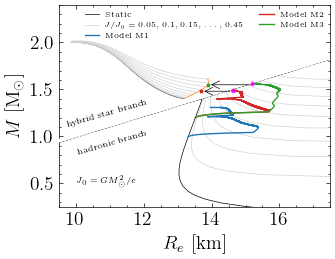

In [23]:
Js = ['0.0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45']
s=6

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for J in Js:
    radius = radius_tab[angular_momentum_tab==np.float64(J)]
    mass = mass_tab[angular_momentum_tab==np.float64(J)]

    if J == "0.0":
        ax.plot(radius, mass,ls='-', color="k", lw=0.5, label="Static")
    else:
        label = r"$J/J_0 = 0.05, 0.1, 0.15, \dots, 0.45$" if J == "0.45" else None
        ax.plot(radius, mass, ls='-', color="lightgrey", lw=0.5, label=label)
               

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]


ns_mass = np.linspace(0, 2, 100)
radius_dashed = ns_radius_trans(ns_mass).value

x_fill = np.concatenate([R_bar, radius_dashed[::-1]])
y_fill = np.concatenate([M_bar, ns_mass[::-1]])

# Fill the area defined by the points
plt.fill(x_fill, y_fill, 'white', zorder=10)

# Plot the baryonic mass curve
plt.plot(R_bar, M_bar, c='tab:orange', ls='-')
            
            
ax.plot(model_m1["ns_radius"], 
        model_m1["ns_mass"],  
        color='tab:blue',
        label='Model M1'
)

ax.plot(model_m2["ns_radius"][:transition_idx_case2], 
        model_m2["ns_mass"][:transition_idx_case2], 
        color='tab:red',
        label='Model M2'
)

ax.plot(model_m3["ns_radius"][:transition_idx_case3], 
        model_m3["ns_mass"][:transition_idx_case3], 
        color='tab:green',
        label='Model M3'
)

ax.scatter(
    13.7,
    model_m2["ns_mass"][transition_idx_case2] - delta_m.value,
    marker="*",
    c='tab:red',
    s=5,
    zorder=10
)

ax.annotate("", 
            xy=(13.7, 
                model_m2["ns_mass"][transition_idx_case2] - delta_m.value
               ), 
            xytext=(model_m2["ns_radius"][transition_idx_case2], 
                    model_m2["ns_mass"][transition_idx_case2] - delta_m.value
                   ),
            arrowprops=dict(arrowstyle="->", 
                            color='k', 
                            lw=0.5, 
                            connectionstyle="arc3,rad=0."
                           ),
            zorder=10
)

ax.scatter(
    13.9,
    model_m3["ns_mass"][transition_idx_case3] - delta_m.value,
    marker="*",
    c='tab:green',
    s=5,
    zorder=10
)

ax.annotate("", 
            xy=(13.9, 
                model_m3["ns_mass"][transition_idx_case3] - delta_m.value
               ), 
            xytext=(model_m3["ns_radius"][transition_idx_case3], 
                    model_m3["ns_mass"][transition_idx_case3] - delta_m.value
                   ),
            arrowprops=dict(arrowstyle="->", 
                            color='k', 
                            lw=0.5, 
                            connectionstyle="arc3,rad=0."
                           ),
            zorder=10
)



ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M$ [M$_\odot$]")
ax.set_ylim([0.25, 2.4])
ax.set_xlim([9.5, 17.5])

ax.text(10, 0.5, r"$J_0 = G M_\odot^2 / c$", size=s)

# Transition line
plt.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='k', lw=0.5)

ax.text(10, 0.8, "hadronic branch", rotation=16, size=s)
ax.text(9.7, 1.1, "hybrid star branch", rotation=16, size=s)

ax.legend(loc="upper right", ncol=2, frameon=False, prop={"size":s-0.7})

# Mark the transition point
ax.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='magenta', 
    s=5, 
    zorder=10
)

ax.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='magenta', 
    s=5, 
    zorder=10
)

# print("Figure size in inches:", fig.get_size_inches())

plt.show()
# plt.savefig("m_vs_r.pdf", bbox_inches='tight', dpi=300)

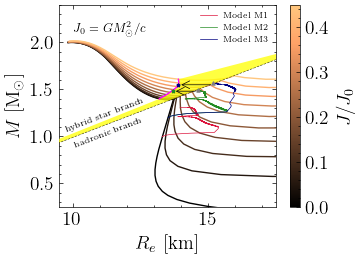

In [24]:
# Set up the colormap
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.copper  # Using copper colormap

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))

    ax.plot(radius, mass, ls="-", color=color, lw=1)

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]

ns_mass = np.linspace(0, 2, 100)
radius_dashed = ns_radius_trans(ns_mass).value

x_fill = np.concatenate([R_bar, radius_dashed[::-1]])
y_fill = np.concatenate([M_bar, ns_mass[::-1]])

# Fill the area defined by the points
plt.fill(x_fill, y_fill, "yellow", zorder=9, alpha=0.75) # "white" for paper

plt.plot(R_bar, M_bar, c="magenta", ls="-", lw=1., zorder=10)

# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$J/J_0$", rotation=90, labelpad=5)


# Model plots with updated colors for visibility
ax.plot(
    model_m1["ns_radius"],
    model_m1["ns_mass"],
    color="crimson",
    lw=0.5,
    label="Model M1",
)

ax.plot(
    model_m2["ns_radius"][:transition_idx_case2],
    model_m2["ns_mass"][:transition_idx_case2],
    color="forestgreen",
    lw=0.5,
    label="Model M2",
)

ax.plot(
    model_m3["ns_radius"][:transition_idx_case3],
    model_m3["ns_mass"][:transition_idx_case3],
    color="navy",
    lw=0.5,
    label="Model M3",
)

# Enhanced markers for transition points with more visible colors and sizes
ax.scatter(
    13.7,
    model_m2["ns_mass"][transition_idx_case2] - delta_m.value,
    marker="*",
    c="forestgreen",
    s=5,
    zorder=10,
)

ax.scatter(
    13.9,
    model_m3["ns_mass"][transition_idx_case3] - delta_m.value,
    marker="*",
    c="navy",
    s=5,
    zorder=10,
)

# Improved arrow properties for better visibility
arrowprops = dict(arrowstyle="->", color="k", lw=0.5, connectionstyle="arc3,rad=0.")

ax.annotate(
    "",
    xy=(13.7, model_m2["ns_mass"][transition_idx_case2] - delta_m.value),
    xytext=(
        model_m2["ns_radius"][transition_idx_case2],
        model_m2["ns_mass"][transition_idx_case2] - delta_m.value,
    ),
    arrowprops=arrowprops,
    zorder=10
)

ax.annotate(
    "",
    xy=(13.9, model_m3["ns_mass"][transition_idx_case3] - delta_m.value),
    xytext=(
        model_m3["ns_radius"][transition_idx_case3],
        model_m3["ns_mass"][transition_idx_case3] - delta_m.value,
    ),
    arrowprops=arrowprops,
    zorder=10
)


# Setting labels, limits, and rest of the figure attributes
ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M$ [M$_\odot$]")
ax.set_ylim([0.25, 2.4])
ax.set_xlim([9.5, 17.5])

ax.text(10, 2.1, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# Transition line and texts
plt.plot(
    ns_radius_trans(np.linspace(0, 2, 100)),
    np.linspace(0, 2, 100),
    ls="--",
    c="black",
    lw=0.5,
)

# Mark the transition point
ax.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax.text(10, 0.88, "hadronic branch", rotation=21, size=6)
ax.text(9.7, 1.05, "hybrid star branch", rotation=21, size=6)

ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=6)


# plt.tight_layout()
plt.show()
# plt.savefig("m_vs_r.pdf", bbox_inches='tight', dpi=300)

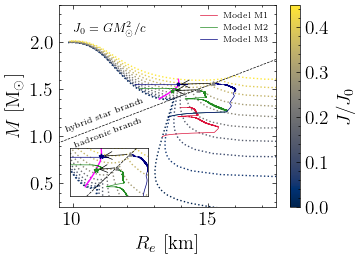

In [25]:
m2_color = 'forestgreen'
m3_color = 'navy'

# Set up the colormap
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.cividis  

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax.plot(radius, mass, ls='dotted', color=color, lw=1)

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]
ax.plot(R_bar, M_bar, c='magenta', ls='-')

# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('$J/J_0$', rotation=90, labelpad=5)

# Model plots with updated colors for visibility
ax.plot(model_m1["ns_radius"], 
        model_m1["ns_mass"],  
        color='crimson',
        lw=0.5,
        label='Model M1'
)

ax.plot(model_m2["ns_radius"][:transition_idx_case2], 
        model_m2["ns_mass"][:transition_idx_case2], 
        color=m2_color,
        lw=0.5,
        label='Model M2'
)

ax.plot(model_m3["ns_radius"][:transition_idx_case3], 
        model_m3["ns_mass"][:transition_idx_case3], 
        color=m3_color,
        lw=0.5,
        label='Model M3'
)

# Enhanced markers for transition points with more visible colors and sizes
ax.scatter(
    13.68,
    model_m2["ns_mass"][transition_idx_case2] - 0.01,
    marker="*",
    c=m2_color,
    s=5,
    zorder=9
)

ax.scatter(
    13.89,
    model_m3["ns_mass"][transition_idx_case3] - 0.01,
    marker="*",
    c=m3_color,
    s=5,
    zorder=9
)

# Mark the transition point
ax.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

# Improved arrow properties for better visibility
arrowprops=dict(arrowstyle="->", color='k', lw=0.5, connectionstyle="arc3,rad=0.")

ax.annotate("", xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01), 
            xytext=(model_m2["ns_radius"][transition_idx_case2], model_m2["ns_mass"][transition_idx_case2]), arrowprops=arrowprops)

ax.annotate("", xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01), 
            xytext=(model_m3["ns_radius"][transition_idx_case3], model_m3["ns_mass"][transition_idx_case3]), arrowprops=arrowprops)


# Setting labels, limits, and rest of the figure attributes
ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M$ [M$_\odot$]")
ax.set_ylim([0.25, 2.4])
ax.set_xlim([9.5, 17.5])

ax.text(10, 2.1, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# Transition line and texts
ax.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='black', lw=0.5)

ax.text(10, 0.88, "hadronic branch", rotation=21, size=6)
ax.text(9.7, 1.05, "hybrid star branch", rotation=21, size=6)

ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=6)


ax.plot(model_m2_posttrans['ns_radius'], model_m2_posttrans['ns_mass'], lw=0.5, zorder=2, c=m2_color)
ax.plot(model_m3_posttrans['ns_radius'], model_m3_posttrans['ns_mass'], lw=0.5 ,zorder=2, c=m3_color)

# ------------- INSET PLOT -------------

# Add the zoomed inset with manual positioning
ax_inset = inset_axes(ax, width="90%", height="80%", 
                      bbox_to_anchor=(0.005, 0.005, 0.4, 0.3), 
                      bbox_transform=ax.transAxes, loc='lower left')

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax_inset.plot(radius, mass, ls='dotted', color=color, lw=1)

ax_inset.plot(R_bar, M_bar, c='magenta', ls='-')

ax_inset.plot(model_m1["ns_radius"], 
              model_m1["ns_mass"],  
              color='crimson',
              lw=0.5,
              label='Model M1'
)

ax_inset.plot(model_m2["ns_radius"][:transition_idx_case2], 
              model_m2["ns_mass"][:transition_idx_case2], 
              color=m2_color,
              lw=0.5,
              label='Model M2'
)

ax_inset.plot(model_m3["ns_radius"][:transition_idx_case3], 
              model_m3["ns_mass"][:transition_idx_case3], 
              color=m3_color,
              lw=0.5,
              label='Model M3'
)

ax_inset.scatter(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01, 
                 marker="*", c=m2_color, s=10, zorder=9)

ax_inset.scatter(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01, 
                 marker="*", c=m3_color, s=10, zorder=9)

# Annotations in the inset
ax_inset.annotate("", xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01), 
                  xytext=(model_m2["ns_radius"][transition_idx_case2], model_m2["ns_mass"][transition_idx_case2]), arrowprops=arrowprops)

ax_inset.annotate("", xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01), 
                  xytext=(model_m3["ns_radius"][transition_idx_case3], model_m3["ns_mass"][transition_idx_case3]), arrowprops=arrowprops)

# Transition line in the inset
ax_inset.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='black', lw=0.5)

# Mark the transition point in the inset
ax_inset.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax_inset.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

# Setting limits and removing ticks in the inset
ax_inset.set_xlim(12.5, 16)
ax_inset.set_ylim(1.35, 1.6)
ax_inset.set_xticks([])
ax_inset.set_yticks([])


ax_inset.plot(model_m2_posttrans['ns_radius'], model_m2_posttrans['ns_mass'], lw=0.5, zorder=2, c=m2_color)
ax_inset.plot(model_m3_posttrans['ns_radius'], model_m3_posttrans['ns_mass'], lw=0.5, zorder=2, c=m3_color)



plt.show()
# plt.savefig("m_vs_r.png", bbox_inches='tight', dpi=300)

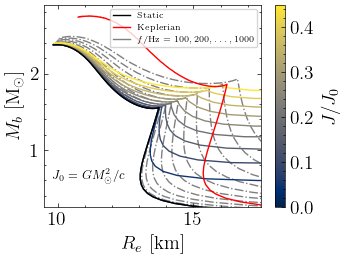

In [26]:
custom_lines = [
    Line2D([0], [0], color='k', lw=1),
    Line2D([0], [0], color='r', lw=1),
    Line2D([0], [0], color='grey', lw=1),
]


# Set up the colormap
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.cividis  

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_bar_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))

    ax.plot(radius, mass, ls='-', color=color, lw=1)
    
plt.plot(data_static[:,1], data_static[:, 4], lw=1, c='k')
plt.plot(data_shed[:,1], data_shed[:, 4], lw=1, c='r')

# Constant frequency lines
plt.plot(data_omega100[:,1], data_omega100[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega200[:,1], data_omega200[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega300[:,1], data_omega300[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega400[:,1], data_omega400[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega500[:,1], data_omega500[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega600[:,1], data_omega600[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega700[:,1], data_omega700[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega800[:,1], data_omega800[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega900[:,1], data_omega900[:,4], lw=1, ls='-.', c='grey', zorder=0)
plt.plot(data_omega1000[:,1], data_omega1000[:,4], lw=1, ls='-.', c='grey', zorder=0)


# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$J/J_0$", rotation=90, labelpad=5)

# Setting labels, limits, and rest of the figure attributes
ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M_b$ [M$_\odot$]")
ax.set_ylim([0.25, 2.4])
ax.set_xlim([9.5, 17.5])

ax.text(9.8, 0.6, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

ax.legend(custom_lines, ["Static",
                          "Keplerian",
                          r"$f/{\rm Hz} = 100, 200, \dots, 1000$"],
          loc="upper right", ncol=1, frameon=True, fontsize=6)

plt.ylim([0.25, 2.9])
plt.xlim([9.5, 17.5])

# plt.tight_layout()
plt.show()

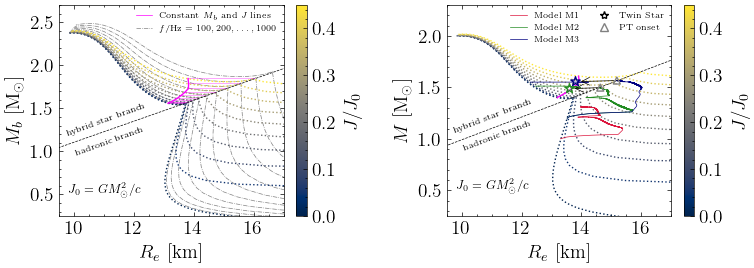

In [27]:
# Define the colormap and normalization for both plots
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.cividis

# Create a figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

custom_lines1 = [
    Line2D([0], [0], color="magenta", lw=0.5),
    Line2D([0], [0], color="grey", lw=0.5, ls='-.'),
]

custom_lines = [
    Line2D([0], [0], color="crimson", lw=0.5),
    Line2D([0], [0], color="forestgreen", lw=0.5),
    Line2D([0], [0], color="navy", lw=0.5),
    Line2D([0], [0], marker="*", markeredgecolor='k', markerfacecolor='white', lw=0),
    Line2D([0], [0], marker="^", markeredgecolor="grey", markerfacecolor='white', lw=0),
]

sm2 = cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_bar_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax1.plot(radius, mass, ls="dotted", color=color, lw=1)

# ax1.plot(data_static[:, 1], data_static[:, 4], lw=1, c="k")
# ax1.plot(data_shed[:, 1], data_shed[:, 4], lw=1, c="r")

R_bar1 = [13.14, 13.16, 13.24, 13.325, 13.435, 13.56, 13.7, 13.82, 13.83, 13.81]
M_bar1 = [1.559, 1.564, 1.573, 1.59, 1.613, 1.645, 1.685, 1.73, 1.785, 1.846]

ax1.plot(R_bar1, M_bar1, c="magenta", lw=1)

r_arr = []
for m in M_bar1:
    r_arr.append(ns_radius_trans(m).value * 0.905)

for m, r0, r1 in zip(M_bar1, r_arr, R_bar1):
    ax1.arrow(
        r0,
        m,
        r1 - r0,
        0,
        lw=0.1,
        color="magenta",
        length_includes_head=True,
        zorder=100,
    )


ax1.plot(
    ns_radius_trans(np.linspace(0, 2, 100)) * 0.905,
    np.linspace(0, 2, 100),
    ls="--",
    c="k",
    lw=0.5,
)
ax1.text(10, 0.95, "hadronic branch", rotation=20, size=6)
ax1.text(9.7, 1.18, "hybrid star branch", rotation=20, size=6)


# ax1.plot(
#     model_m1["ns_radius"],
#     model_m1["ns_mass_bar"],
#     color="crimson",
#     lw=0.5,
#     label="Model M1",
# )
# ax1.plot(
#     model_m2["ns_radius"][:transition_idx_case2],
#     model_m2["ns_mass_bar"][:transition_idx_case2],
#     color=m2_color,
#     lw=0.5,
#     label="Model M2",
# )
# ax1.plot(
#     model_m3["ns_radius"][:transition_idx_case3],
#     model_m3["ns_mass_bar"][:transition_idx_case3],
#     color=m3_color,
#     lw=0.5,
#     label="Model M3",
# )

# ax1.annotate(
#     "",
#     xy=(13.68, model_m2["ns_mass_bar"][transition_idx_case2]),
#     xytext=(
#         model_m2["ns_radius"][transition_idx_case2],
#         model_m2["ns_mass_bar"][transition_idx_case2],
#     ),
#     arrowprops=arrowprops,
# )
# ax1.annotate(
#     "",
#     xy=(13.89, model_m3["ns_mass_bar"][transition_idx_case3]),
#     xytext=(
#         model_m3["ns_radius"][transition_idx_case3],
#         model_m3["ns_mass_bar"][transition_idx_case3],
#     ),
#     arrowprops=arrowprops,
# )

# ax1.scatter(
#     13.68,
#     model_m2["ns_mass_bar"][transition_idx_case2],
#     marker="*",
#     facecolors='none', 
#     edgecolors=m2_color,
#     s=50,
#     zorder=9,
# )
# ax1.scatter(
#     13.85,
#     model_m3["ns_mass_bar"][transition_idx_case3],
#     marker="*",
#     facecolors='none', 
#     edgecolors=m3_color,
#     s=50,
#     zorder=9,
# )
# ax1.scatter(
#     model_m2["ns_radius"][transition_idx_case2],
#     model_m2["ns_mass_bar"][transition_idx_case2],
#     marker="^",
#     edgecolor="grey",
#     facecolor='none',
#     s=25,
#     zorder=10,
# )
# ax1.scatter(
#     model_m3["ns_radius"][transition_idx_case3],
#     model_m3["ns_mass_bar"][transition_idx_case3],
#     marker="^",
#     edgecolor="grey",
#     facecolor='none',
#     s=25,
#     zorder=10,
# )

# Constant frequency lines
ax1.plot(data_omega100[:, 1], data_omega100[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega200[:, 1], data_omega200[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega300[:, 1], data_omega300[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega400[:, 1], data_omega400[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega500[:, 1], data_omega500[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega600[:, 1], data_omega600[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega700[:, 1], data_omega700[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega800[:, 1], data_omega800[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(data_omega900[:, 1], data_omega900[:, 4], lw=0.5, ls="-.", c="grey", zorder=0)
ax1.plot(
    data_omega1000[:, 1], data_omega1000[:, 4], lw=0.5, ls="-.", c="grey", zorder=0
)

ax1.set_xlabel(r"$R_e$ [km]")
ax1.set_ylabel(r"$M_b$ [M$_\odot$]")
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Set maximum number of x-axis ticks
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set maximum number of y-axis ticks
ax1.set_ylim([0.25, 2.7])
ax1.set_xlim([9.5, 17.0])
ax1.text(9.8, 0.5, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# ax1.legend(
#     custom_lines,
#     ["Model M1", "Model M2", "Model M3", "Twin Star", "PT onset"],
#     loc="upper right",
#     ncol=1,
#     frameon=False,
#     fontsize=6,
#     ncols=2,
# )

ax1.legend(
    custom_lines1,
    [r"Constant $M_b$ and $J$ lines", r"$f/{\rm Hz} = 100, 200, \dots, 1000$"],
    loc="upper right",
    frameon=False,
    fontsize=6,
    ncols=1,
)


# Add the colorbar for the first plot
cbar1 = fig.colorbar(sm2, ax=ax1, orientation="vertical", fraction=0.25, pad=0.04)
cbar1.set_label("$J/J_0$", rotation=90, labelpad=5)




## Second plot
m2_color = "forestgreen"
m3_color = "navy"

sm1 = cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax2.plot(radius, mass, ls="dotted", color=color, lw=1)

R_bar2 = [
    13.193,
    13.213,
    13.265,
    13.346,
    13.466,
    13.586,
    13.720,
    13.863,
    13.920,
    13.901,
]
M_bar2 = [
    1.3992,
    1.4054,
    1.4136,
    1.4259,
    1.4463,
    1.4689,
    1.4975,
    1.5303,
    1.5693,
    1.6082,
]
ax2.plot(R_bar2, M_bar2, c="magenta", ls="-", lw=1)

ax2.plot(
    model_m1["ns_radius"],
    model_m1["ns_mass"],
    color="crimson",
    lw=0.5,
    label="Model M1",
)
ax2.plot(
    model_m2["ns_radius"][:transition_idx_case2],
    model_m2["ns_mass"][:transition_idx_case2],
    color=m2_color,
    lw=0.5,
    label="Model M2",
)
ax2.plot(
    model_m3["ns_radius"][:transition_idx_case3],
    model_m3["ns_mass"][:transition_idx_case3],
    color=m3_color,
    lw=0.5,
    label="Model M3",
)

ax2.scatter(
    13.6,
    model_m2["ns_mass"][transition_idx_case2] - 0.01,
    marker="*",
    facecolors='none', 
    edgecolors=m2_color,
    s=50,
    zorder=9,
)
ax2.scatter(
    13.8,
    model_m3["ns_mass"][transition_idx_case3] - 0.01,
    marker="*",
    facecolors='none', 
    edgecolors=m3_color,
    s=50,
    zorder=9,
)
ax2.scatter(
    model_m2["ns_radius"][transition_idx_case2],
    model_m2["ns_mass"][transition_idx_case2],
    marker="^",
    edgecolor="grey",
    facecolor='none',
    s=25,
    zorder=10,
)
ax2.scatter(
    model_m3["ns_radius"][transition_idx_case3],
    model_m3["ns_mass"][transition_idx_case3],
    marker="^",
    edgecolor="grey",
    facecolor='none',
    s=25,
    zorder=10,
)

arrowprops = dict(arrowstyle="->", color="k", lw=0.5, connectionstyle="arc3,rad=0.")
ax2.annotate(
    "",
    xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01),
    xytext=(
        model_m2["ns_radius"][transition_idx_case2],
        model_m2["ns_mass"][transition_idx_case2],
    ),
    arrowprops=arrowprops,
)
ax2.annotate(
    "",
    xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01),
    xytext=(
        model_m3["ns_radius"][transition_idx_case3],
        model_m3["ns_mass"][transition_idx_case3],
    ),
    arrowprops=arrowprops,
)

ax2.set_xlabel(r"$R_e$ [km]")
ax2.set_ylabel(r"$M$ [M$_\odot$]")
ax2.set_ylim([0.25, 2.3])
ax2.set_xlim([9.5, 17.0])
ax2.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Set maximum number of x-axis ticks
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set maximum number of y-axis ticks
ax2.text(9.8, 0.5, r"$J_0 = G M_\odot^2 / c$", fontsize=9)
ax2.plot(
    ns_radius_trans(np.linspace(0, 2, 100)),
    np.linspace(0, 2, 100),
    ls="--",
    c="black",
    lw=0.5,
)
ax2.text(10, 0.88, "hadronic branch", rotation=21, size=6)
ax2.text(9.7, 1.05, "hybrid star branch", rotation=21, size=6)
ax2.legend(
    custom_lines,
    ["Model M1", "Model M2", "Model M3", "Twin Star", "PT onset"],
    loc="upper right",
    frameon=False,
    fontsize=6,
    ncols=2
)
ax2.plot(
    model_m2_posttrans["ns_radius"],
    model_m2_posttrans["ns_mass"],
    lw=0.5,
    zorder=2,
    c=m2_color,
)
ax2.plot(
    model_m3_posttrans["ns_radius"],
    model_m3_posttrans["ns_mass"],
    lw=0.5,
    zorder=2,
    c=m3_color,
)

# ax2.plot(data_omega100[:, 1], data_omega100[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega200[:, 1], data_omega200[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega300[:, 1], data_omega300[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega400[:, 1], data_omega400[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega500[:, 1], data_omega500[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega600[:, 1], data_omega600[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega700[:, 1], data_omega700[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega800[:, 1], data_omega800[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(data_omega900[:, 1], data_omega900[:, 2], lw=0.5, ls="-.", c="grey", zorder=0)
# ax2.plot(
#     data_omega1000[:, 1], data_omega1000[:, 2], lw=0.5, ls="-.", c="grey", zorder=0
# )

# ax_inset = inset_axes(
#     ax2,
#     width="90%",
#     height="80%",
#     bbox_to_anchor=(0.005, 0.005, 0.4, 0.3),
#     bbox_transform=ax2.transAxes,
#     loc="lower left",
# )
# for J in Js:
#     radius = radius_tab[angular_momentum_tab == np.float64(J)]
#     mass = mass_tab[angular_momentum_tab == np.float64(J)]
#     color = cmap(norm(np.float64(J)))
#     ax_inset.plot(radius, mass, ls="dotted", color=color, lw=1)

# ax_inset.plot(R_bar2, M_bar2, c="magenta", ls="-")
# ax_inset.plot(
#     model_m1["ns_radius"],
#     model_m1["ns_mass"],
#     color="crimson",
#     lw=0.5,
#     label="Model M1",
# )
# ax_inset.plot(
#     model_m2["ns_radius"][:transition_idx_case2],
#     model_m2["ns_mass"][:transition_idx_case2],
#     color=m2_color,
#     lw=0.5,
#     label="Model M2",
# )
# ax_inset.plot(
#     model_m3["ns_radius"][:transition_idx_case3],
#     model_m3["ns_mass"][:transition_idx_case3],
#     color=m3_color,
#     lw=0.5,
#     label="Model M3",
# )

# ax_inset.scatter(
#     13.68,
#     model_m2["ns_mass"][transition_idx_case2] - 0.01,
#     marker="*",
#     c=m2_color,
#     s=10,
#     zorder=9,
# )
# ax_inset.scatter(
#     13.89,
#     model_m3["ns_mass"][transition_idx_case3] - 0.01,
#     marker="*",
#     c=m3_color,
#     s=10,
#     zorder=9,
# )
# ax_inset.annotate(
#     "",
#     xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01),
#     xytext=(
#         model_m2["ns_radius"][transition_idx_case2],
#         model_m2["ns_mass"][transition_idx_case2],
#     ),
#     arrowprops=arrowprops,
# )
# ax_inset.annotate(
#     "",
#     xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01),
#     xytext=(
#         model_m3["ns_radius"][transition_idx_case3],
#         model_m3["ns_mass"][transition_idx_case3],
#     ),
#     arrowprops=arrowprops,
# )
# ax_inset.plot(
#     ns_radius_trans(np.linspace(0, 2, 100)),
#     np.linspace(0, 2, 100),
#     ls="--",
#     c="black",
#     lw=0.5,
# )
# ax_inset.scatter(
#     model_m2["ns_radius"][transition_idx_case2],
#     model_m2["ns_mass"][transition_idx_case2],
#     marker="^",
#     edgecolor="grey",
#     facecolor='none',
#     s=5,
#     zorder=10,
# )
# ax_inset.scatter(
#     model_m3["ns_radius"][transition_idx_case3],
#     model_m3["ns_mass"][transition_idx_case3],
#     marker="^",
#     edgecolor="grey",
#     facecolor='none',
#     s=5,
#     zorder=10,
# )
# ax_inset.set_xlim(12.5, 16)
# ax_inset.set_ylim(1.35, 1.6)
# ax_inset.set_xticks([])
# ax_inset.set_yticks([])
# ax_inset.plot(
#     model_m2_posttrans["ns_radius"],
#     model_m2_posttrans["ns_mass"],
#     lw=0.5,
#     zorder=2,
#     c=m2_color,
# )
# ax_inset.plot(
#     model_m3_posttrans["ns_radius"],
#     model_m3_posttrans["ns_mass"],
#     lw=0.5,
#     zorder=2,
#     c=m3_color,
# )


# Add the colorbar for the second plot
cbar2 = fig.colorbar(sm1, ax=ax2, orientation="vertical", fraction=0.25, pad=0.04)
cbar2.set_label("$J/J_0$", rotation=90, labelpad=5)



plt.tight_layout()
plt.show()
# plt.savefig("figures/m_vs_r_grid.png", dpi=300, bbox_inches='tight')

(1.5, 2.0)

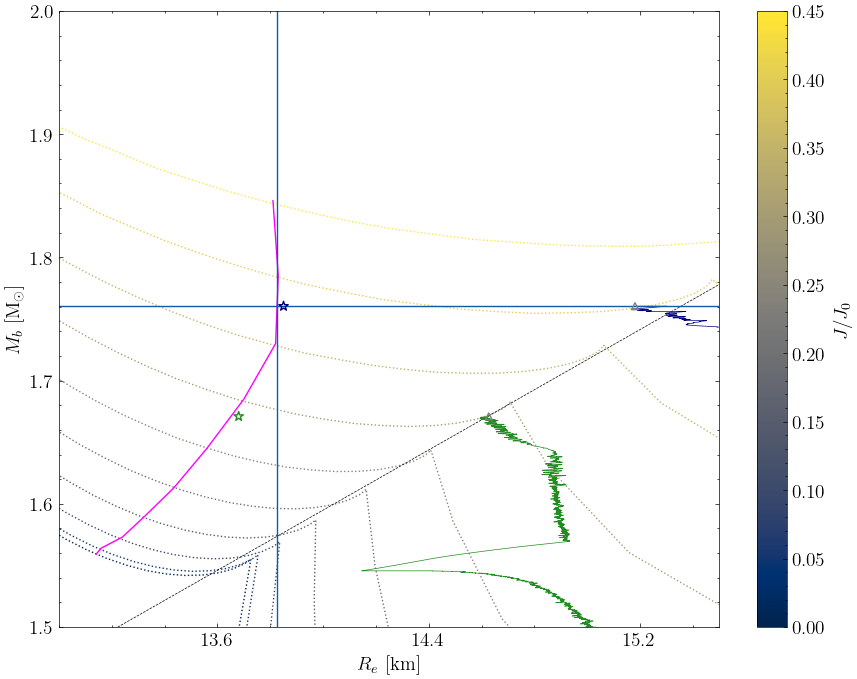

In [28]:
# Create a figure with 1x2 subplots
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

custom_lines = [
    Line2D([0], [0], color="crimson", lw=0.5),
    Line2D([0], [0], color="forestgreen", lw=0.5),
    Line2D([0], [0], color="navy", lw=0.5),
    Line2D([0], [0], marker="*", markeredgecolor='k', markerfacecolor='white', lw=0),
    Line2D([0], [0], marker="^", markeredgecolor="grey", markerfacecolor='white', lw=0),
]

sm2 = cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_bar_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax1.plot(radius, mass, ls="dotted", color=color, lw=1)


R_bar1 = [13.14, 13.16, 13.24, 13.325, 13.435, 13.56, 13.7, 13.82, 13.83, 13.81]
M_bar1 = [1.559, 1.564, 1.573, 1.59, 1.613, 1.645, 1.685, 1.73, 1.785, 1.846]

ax1.plot(R_bar1, M_bar1, c="magenta", lw=1)

r_arr = []
for m in M_bar1:
    r_arr.append(ns_radius_trans(m).value * 0.905)

# for m, r0, r1 in zip(M_bar1, r_arr, R_bar1):
#     ax1.arrow(
#         r0,
#         m,
#         r1 - r0,
#         0,
#         lw=0.1,
#         color="magenta",
#         length_includes_head=True,
#         zorder=100,
#     )


ax1.plot(
    ns_radius_trans(np.linspace(0, 2, 100)) * 0.905,
    np.linspace(0, 2, 100),
    ls="--",
    c="k",
    lw=0.5,
)
# ax1.text(10, 0.95, "hadronic branch", rotation=20, size=6)
# ax1.text(9.7, 1.18, "hybrid star branch", rotation=20, size=6)


ax1.plot(
    model_m1["ns_radius"],
    model_m1["ns_mass_bar"],
    color="crimson",
    lw=0.5,
    label="Model M1",
)
ax1.plot(
    model_m2["ns_radius"][:transition_idx_case2],
    model_m2["ns_mass_bar"][:transition_idx_case2],
    color=m2_color,
    lw=0.5,
    label="Model M2",
)
ax1.plot(
    model_m3["ns_radius"][:transition_idx_case3],
    model_m3["ns_mass_bar"][:transition_idx_case3],
    color=m3_color,
    lw=0.5,
    label="Model M3",
)

# ax1.annotate(
#     "",
#     xy=(13.68, model_m2["ns_mass_bar"][transition_idx_case2]),
#     xytext=(
#         model_m2["ns_radius"][transition_idx_case2],
#         model_m2["ns_mass_bar"][transition_idx_case2],
#     ),
#     arrowprops=arrowprops,
# )
# ax1.annotate(
#     "",
#     xy=(13.89, model_m3["ns_mass_bar"][transition_idx_case3]),
#     xytext=(
#         model_m3["ns_radius"][transition_idx_case3],
#         model_m3["ns_mass_bar"][transition_idx_case3],
#     ),
#     arrowprops=arrowprops,
# )

ax1.scatter(
    13.68,
    model_m2["ns_mass_bar"][transition_idx_case2],
    marker="*",
    facecolors='none', 
    edgecolors=m2_color,
    s=50,
    zorder=9,
)
ax1.scatter(
    13.85,
    model_m3["ns_mass_bar"][transition_idx_case3],
    marker="*",
    facecolors='none', 
    edgecolors=m3_color,
    s=50,
    zorder=9,
)
ax1.scatter(
    model_m2["ns_radius"][transition_idx_case2],
    model_m2["ns_mass_bar"][transition_idx_case2],
    marker="^",
    edgecolor="grey",
    facecolor='none',
    s=25,
    zorder=10,
)
ax1.scatter(
    model_m3["ns_radius"][transition_idx_case3],
    model_m3["ns_mass_bar"][transition_idx_case3],
    marker="^",
    edgecolor="grey",
    facecolor='none',
    s=25,
    zorder=10,
)

ax1.set_xlabel(r"$R_e$ [km]")
ax1.set_ylabel(r"$M_b$ [M$_\odot$]")
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Set maximum number of x-axis ticks
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set maximum number of y-axis ticks
ax1.set_ylim([0.25, 2.7])
ax1.set_xlim([9.5, 17.0])
# ax1.text(9.8, 0.5, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# ax1.legend(
#     custom_lines,
#     ["Model M1", "Model M2", "Model M3", "Twin Star", "PT onset"],
#     loc="upper right",
#     ncol=1,
#     frameon=False,
#     fontsize=6,
#     ncols=2,
# )


# Add the colorbar for the first plot
cbar1 = fig.colorbar(sm2, ax=ax1, orientation="vertical", fraction=0.25, pad=0.04)
cbar1.set_label("$J/J_0$", rotation=90, labelpad=5)

ax1.axhline(model_m3["ns_mass_bar"][transition_idx_case3])
ax1.axvline(13.825)


ax1.set_xlim([13, 15.5])
ax1.set_ylim([1.5, 2.0])
# print(model_m3['ns_ang_mom'][transition_idx_case3])

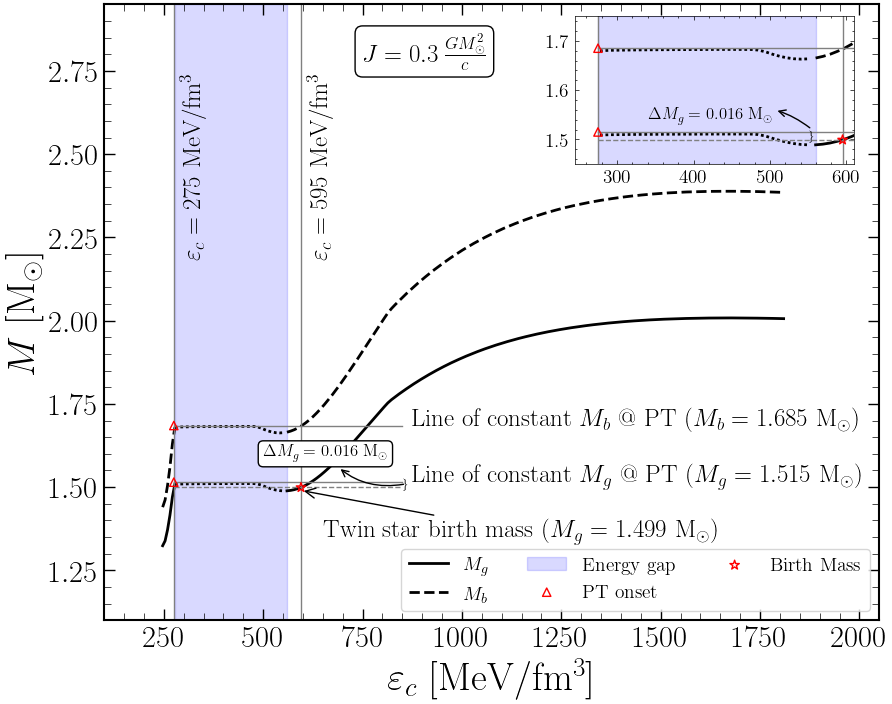

In [29]:
# Create a figure with 1x2 subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set axis spine colors to black
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Set spine line width
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

ax.set_xlabel(r"$\varepsilon_c$ [MeV/fm$^3$]", fontsize=28)
ax.set_ylabel(r"$M$ [M$_\odot$]", fontsize=28)

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

# Set tick sizes
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=5, width=0.5)

ax.set_xlim([100, 2050])
ax.set_ylim([1.1, 2.95])

# Get rid of numerical artefacts caused by the model of rigid rotator at low densities
# This is the index where the hadronic branch essentialy starts
idx1 = np.argmin(mass_tab[angular_momentum_tab == np.float64(0.3)], axis=0)

# This the index where the the hadronic branch ends and a region of instabillity begins
idx2 = np.where(np.isclose(energy_tab[angular_momentum_tab == np.float64(0.3)], 275, rtol=1e-2))[0][0]

# This is where the instability region ends and the hybrid branch begins
# Note: at this point the size of the quark core may be very small (e.g. the size of a football) which
# is of course negligible compared to the rest of the neutron star.
idx3 = np.where(np.isclose(energy_tab[angular_momentum_tab == np.float64(0.3)], 555, rtol=1e-2))[0][-1]

ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx1:idx2+1],
    mass_tab[angular_momentum_tab == np.float64(0.3)][idx1:idx2+1],
    label=r"$M_g$",
    c="k",
    lw=2,
)
ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    mass_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    c="k",
    lw=2,
    ls=(0, (1, 1))
)
ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    mass_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    c="k",
    lw=2,
)

ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx1:idx2+1],
    mass_bar_tab[angular_momentum_tab == np.float64(0.3)][idx1:idx2+1],
    label=r"$M_b$",
    c="k",
    ls="--",
    lw=2,
)
ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    mass_bar_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    c="k",
    ls=(0, (1, 1)),
    lw=2,
)
ax.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    mass_bar_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    c="k",
    ls="--",
    lw=2,
)

ax.axvspan(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx2],
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3],
    alpha=0.15,
    color='blue',
    label="Energy gap"
)


text_font_size = 18
ax.axvline(275, lw=1, c="grey")
ax.axvline(595, lw=1, c="grey")
ax.text(x=290, y=2.2, s=r"$\varepsilon_c = 275$ MeV/fm$^3$", rotation=90, fontsize=text_font_size)
ax.text(x=610, y=2.2, s=r"$\varepsilon_c = 595$ MeV/fm$^3$", rotation=90, fontsize=text_font_size)
ax.scatter(
    275,
    1.515,
    marker="^",
    edgecolors="red",
    facecolor="none",
    zorder=100,
    label="PT onset",
)
ax.scatter(275, 1.685, marker="^", edgecolors="red", facecolor="none", zorder=100)

ax.plot(np.linspace(275, 850), np.linspace(1.685, 1.685), lw=1, c="grey")
ax.text(x=875, y=1.685, s=r"Line of constant $M_b$ @ PT ($M_b = 1.685$ M$_\odot$)", fontsize=text_font_size)

ax.plot(np.linspace(275, 850), np.linspace(1.515, 1.515), lw=1, c="grey")
ax.text(x=875, y=1.515, s=r"Line of constant $M_g$ @ PT ($M_g = 1.515$ M$_\odot$)", fontsize=text_font_size)

ax.plot(np.linspace(275, 850), np.linspace(1.499, 1.499), lw=1, ls="--", c="grey")

ax.scatter(
    595,
    1.499,
    s=50,
    marker="*",
    edgecolors="red",
    facecolor="none",
    zorder=100,
    label="Birth Mass",
)

ax.annotate(
    text=r"Twin star birth mass ($M_g = 1.499$ M$_\odot$)",
    xy=(595, 1.490),
    xytext=(650, 1.35),
    arrowprops=dict(arrowstyle="->", lw=1, connectionstyle="arc3,rad=0."),
    fontsize=text_font_size
)


props = dict(boxstyle="round", facecolor="white")
ax.text(x=750, y=2.78, s=r"$J = 0.3\,\frac{GM_\odot^2}{c}$", bbox=props, fontsize=text_font_size)


ax.annotate(text=r"\}", xy=(850, 1.5), fontsize=9)
ax.annotate(
    text=r"$\Delta M_g = 0.016$ M$_\odot$",
    xy=(860, 1.51),
    xytext=(500, 1.59),
    fontsize=12,
    arrowprops=dict(arrowstyle="<-", lw=1, connectionstyle="arc3,rad=0.3"),
    bbox=props
)

ax.legend(loc="lower right", frameon=True, ncols=3, fontsize=14)



## Inset plot ##

ax_inset = inset_axes(
    ax,
    width="90%",
    height="80%",
    bbox_to_anchor=(0.58, 0.725, 0.4, 0.3),
    bbox_transform=ax.transAxes,
    loc="lower right",
)

ax_inset.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    mass_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    c="k",
    lw=2,
    ls=(0, (1, 1)),
)
ax_inset.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    mass_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    c="k",
    lw=2,
)

ax_inset.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    mass_bar_tab[angular_momentum_tab == np.float64(0.3)][idx2:idx3],
    c="k",
    ls=(0, (1, 1)),
    lw=2,
)

ax_inset.plot(
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    mass_bar_tab[angular_momentum_tab == np.float64(0.3)][idx3:],
    c="k",
    ls="--",
    lw=2,
)

ax_inset.axvspan(
    275,
    energy_tab[angular_momentum_tab == np.float64(0.3)][idx3],
    alpha=0.15,
    color='blue',
)

ax_inset.set_xlim([245, 610])
ax_inset.set_ylim([1.45, 1.75])
ax_inset.axvline(275, lw=1, c="grey")
ax_inset.axvline(595, lw=1, c="grey")
ax_inset.scatter(
    275,
    1.515,
    marker="^",
    edgecolors="red",
    facecolor="none",
    zorder=100,
    label="QM onset",
)
ax_inset.scatter(
    275, 1.685, marker="^", edgecolors="red", facecolor="none", zorder=100
)
ax_inset.scatter(
    595, 1.499, marker="*", edgecolors="red", facecolor="none", zorder=100, s=50
)
ax_inset.plot(np.linspace(275, 850), np.linspace(1.685, 1.685), lw=1, c="grey")
ax_inset.plot(np.linspace(275, 850), np.linspace(1.515, 1.515), lw=1, c="grey")
ax_inset.plot(np.linspace(275, 850), np.linspace(1.499, 1.499), lw=1, ls="--", c="grey")

ax_inset.annotate(text=r"\}", xy=(550, 1.5), fontsize=9)
ax_inset.annotate(
    text=r"$\Delta M_g = 0.016$ M$_\odot$",
    xy=(555, 1.52),
    xytext=(340, 1.54),
    fontsize=12,
    arrowprops=dict(arrowstyle="<-", lw=1, connectionstyle="arc3,rad=-0.3"),
)





plt.show()
# plt.savefig("figures/mass_vs_energy.png", dpi=300, bbox_inches='tight')

## Structure of donor star

In [30]:
m2 = mp.MESA()
m2.loadHistory(f="data/md1.0_mc1.2_p8.0_z0.02_b0.5/")

m3 = mp.MESA()
m3.loadHistory(f="data/md1.0_mc1.2_p22.627_z0.02_b0.5/")

In [31]:
plt.style.use(["default", "science"])

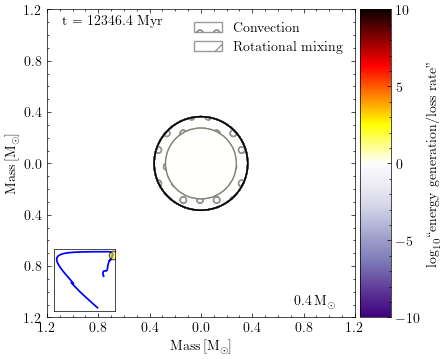

In [32]:
tulips.energy_and_mixing(m2, time_ind=transition_idx_case2, cmin=-10, cmax=10, show_total_mass=True,
                         show_mix=True, show_mix_legend=True)
plt.show()

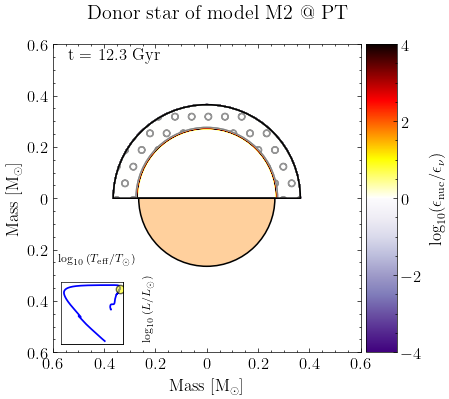

In [33]:
plt.rcParams.update({'font.size': 12})

fig, ax = tulips.energy_and_mixing(
    m2,
    time_ind=transition_idx_case2,
    cmin=-4,
    cmax=4,
    theta1=0,
    theta2=180,
    show_mix=True,
    show_mix_legend=False,
    show_hrd_ticks_and_labels=False,
    time_unit="Gyr",
    cbar_label=r"$\log_{10}(\epsilon_\mathrm{nuc}/\epsilon_\nu)$"
)

tulips.perceived_color(
    m2,
    time_ind=transition_idx_case2,
    raxis="he_core_mass",
    fig=fig,
    ax=ax,
    theta1=180,
    theta2=360,
    axis_label="Mass $[\mathrm{M}_{\odot}]$",
    axis_lim=0.5,
    show_time_label=False,
    show_total_mass=False,
)

fig.suptitle("Donor star of model M2 @ PT")

ax.text(x=-0.58, y=-0.25, s=r'$\log_{10}\left(T_{\rm eff}/T_\odot\right)$', fontsize=8)
ax.text(x=-0.25, y=-0.55, s=r'$\log_{10}\left(L/L_\odot\right)$', fontsize=8, rotation=90)

plt.show()
# plt.savefig("figures/donor_m2_enegy_vs_mixing.png", dpi=300, bbox_inches='tight')

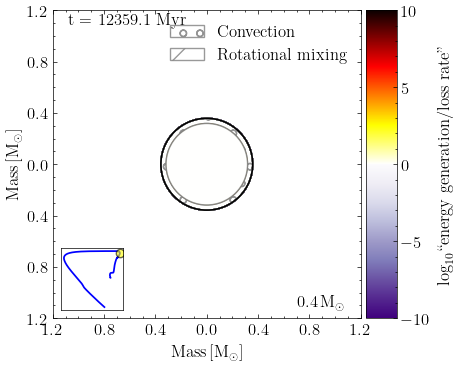

In [34]:
tulips.energy_and_mixing(m3, time_ind=transition_idx_case3, cmin=-10, cmax=10, show_total_mass=True,
                         show_mix=True, show_mix_legend=True)
plt.show()

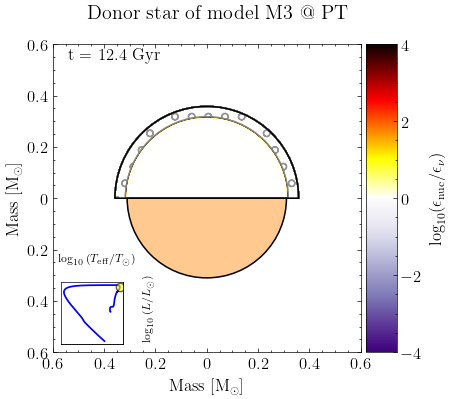

In [35]:
plt.rcParams.update({'font.size': 12})

fig, ax = tulips.energy_and_mixing(
    m3,
    time_ind=transition_idx_case3,
    cmin=-4,
    cmax=4,
    theta1=0,
    theta2=180,
    show_mix=True,
    show_mix_legend=False,
    show_hrd_ticks_and_labels=False,
    time_unit="Gyr",
    cbar_label=r"$\log_{10}(\epsilon_\mathrm{nuc}/\epsilon_\nu)$"
)

tulips.perceived_color(
    m3,
    time_ind=transition_idx_case3,
    raxis="he_core_mass",
    fig=fig,
    ax=ax,
    theta1=180,
    theta2=360,
    axis_label="Mass $[\mathrm{M}_{\odot}]$",
    axis_lim=0.5,
    show_time_label=False,
    show_total_mass=False,
)


fig.suptitle("Donor star of model M3 @ PT")

ax.text(x=-0.58, y=-0.25, s=r'$\log_{10}\left(T_{\rm eff}/T_\odot\right)$', fontsize=8)
ax.text(x=-0.25, y=-0.55, s=r'$\log_{10}\left(L/L_\odot\right)$', fontsize=8, rotation=90)

plt.show()
# plt.savefig("figures/donor_m3_enegy_vs_mixing.png", dpi=300, bbox_inches='tight')

# Post-transition evolution

## Monte Carlo simulation

In [36]:
# Gravitational mass loss during transition
delta_m1 = 0.016 * u.Msun
delta_m2 = 0.05 * u.Msun

# Number of sample points
n = 10_000

# Draw kick angles from an isotropic distribution
phi_dist = np.random.uniform(0, 2 * np.pi, n) * u.rad
cos_theta_dist = np.random.uniform(-1, 1, n)
theta_dist = np.arccos(cos_theta_dist) * u.rad

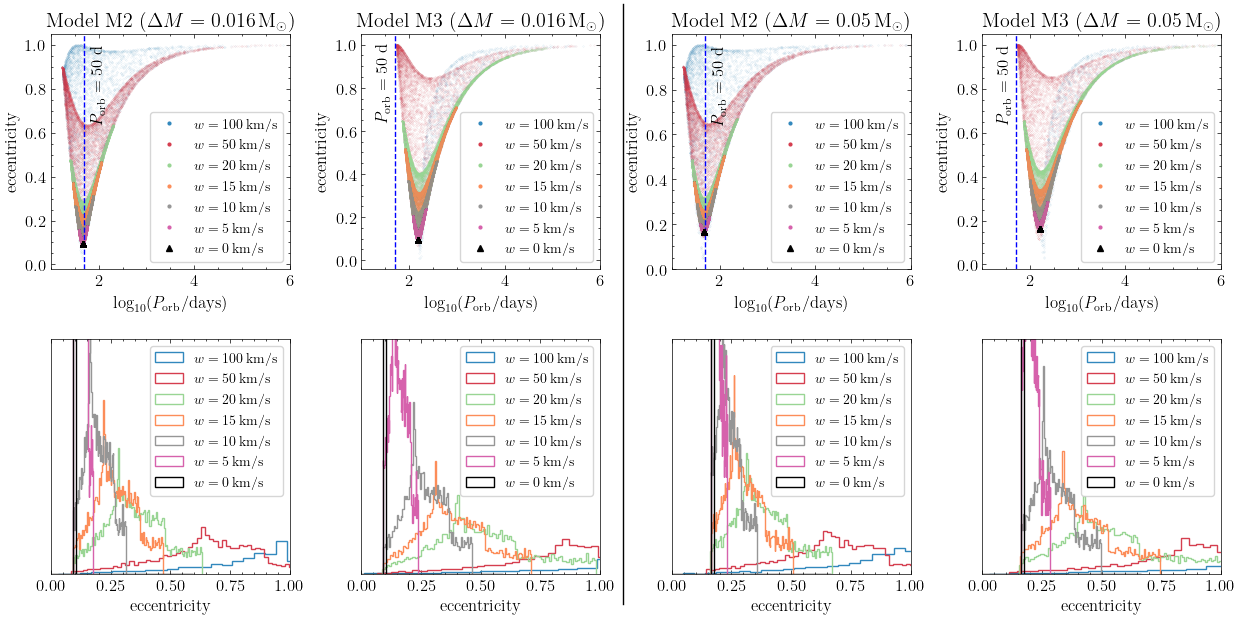

In [37]:
fig, ax = plt.subplots(2,4, figsize=(13,6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)
# 
ax[1,0].yaxis.set_tick_params(labelleft=False)
ax[1,0].set_yticks([])
ax[1,1].yaxis.set_tick_params(labelleft=False)
ax[1,1].set_yticks([])

ax[0,0].set_xlim([1, 6])
ax[0,1].set_xlim([1, 6])
ax[1,0].set_xlim([0, 1])
ax[1,1].set_xlim([0, 1])

ax[1,0].set_ylim([0, 10])
ax[1,1].set_ylim([0, 10])


fontsize=12
ax[0,0].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,0].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,1].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,1].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,0].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,1].set_xlabel("eccentricity", fontsize=fontsize)

ax[1,2].yaxis.set_tick_params(labelleft=False)
ax[1,2].set_yticks([])
ax[1,3].yaxis.set_tick_params(labelleft=False)
ax[1,3].set_yticks([])

ax[0,2].set_xlim([1, 6])
ax[0,3].set_xlim([1, 6])
ax[1,2].set_xlim([0, 1])
ax[1,3].set_xlim([0, 1])

ax[1,2].set_ylim([0, 10])
ax[1,3].set_ylim([0, 10])


ax[0,2].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,2].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,3].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,3].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,2].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,3].set_xlabel("eccentricity", fontsize=fontsize)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']


for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )
    
    ap_case2_dm2 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m2,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )
    
    
    y_case2_dm2 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm2,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm2 = orbital_period_posttrans(ap_case2_dm2,
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m2
    )

    ap_case3_dm2 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m2,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm2 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm2,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm2 = orbital_period_posttrans(ap_case3_dm2,
                                          model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                          model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m2
    )
    
    
    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax[1,0].hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,1].hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,2].hist(y_case2_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,3].hist(y_case3_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)

    if w == 0: 
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    
        
    else:
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
    
        
legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

s=10
ax[0,0].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,1].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,2].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,3].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)

ax[1,0].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,1].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,2].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,3].legend(loc='upper right', prop={"size":s}, frameon=True)

ax[0,0].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,1].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,2].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))
ax[0,3].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))

# Add separating line between subplots
###
ax[0,0].plot([0.49, 0.49], [0, 1.0], color='k', lw=1,
         transform=plt.gcf().transFigure, clip_on=False)


# Add visual mark for Porb = 50 days
ax[0,0].axvline(np.log10(50), ls="--", c='b')
ax[0,1].axvline(np.log10(50), ls="--", c='b')
ax[0,2].axvline(np.log10(50), ls="--", c='b')
ax[0,3].axvline(np.log10(50), ls="--", c='b')

ax[0,0].text(np.log10(70), 0.65, r"$P_{\rm orb} = 50$ d", rotation=90, fontsize=fontsize)
ax[0,1].text(np.log10(20), 0.65, r"$P_{\rm orb} = 50$ d", rotation=90, fontsize=fontsize)
ax[0,2].text(np.log10(70), 0.65, r"$P_{\rm orb} = 50$ d", rotation=90, fontsize=fontsize)
ax[0,3].text(np.log10(20), 0.65, r"$P_{\rm orb} = 50$ d", rotation=90, fontsize=fontsize)


plt.show()
# plt.savefig("mc_sim.png", bbox_inches='tight', dpi=300)

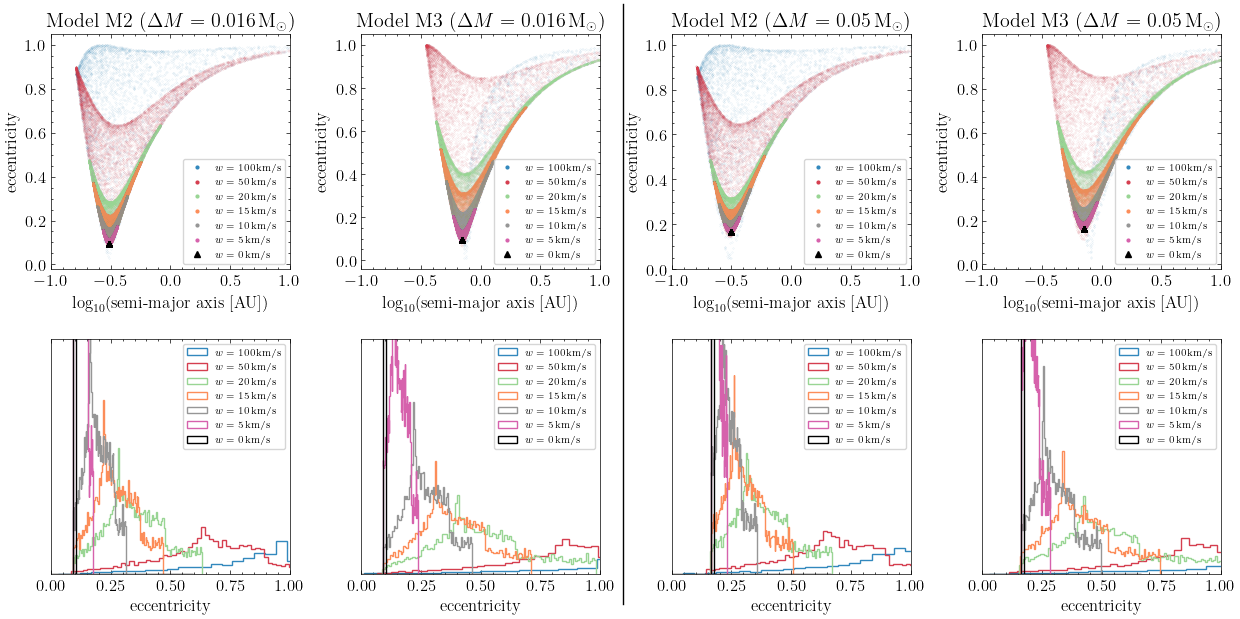

In [38]:
fig, ax = plt.subplots(2,4, figsize=(13,6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)

ax[1,0].yaxis.set_tick_params(labelleft=False)
ax[1,0].set_yticks([])
ax[1,1].yaxis.set_tick_params(labelleft=False)
ax[1,1].set_yticks([])

ax[0,0].set_xlim([-1, 1])
ax[0,1].set_xlim([-1, 1])
ax[1,0].set_xlim([0, 1])
ax[1,1].set_xlim([0, 1])

ax[1,0].set_ylim([0, 10])
ax[1,1].set_ylim([0, 10])

ax[0,0].set_xlabel(r"$\log_{10}$(\text{semi-major axis [AU]})")
ax[0,0].set_ylabel("eccentricity")
ax[0,1].set_xlabel(r"$\log_{10}$(\text{semi-major axis [AU]})")
ax[0,1].set_ylabel("eccentricity")
ax[1,0].set_xlabel("eccentricity")
ax[1,1].set_xlabel("eccentricity")

ax[1,2].yaxis.set_tick_params(labelleft=False)
ax[1,2].set_yticks([])
ax[1,3].yaxis.set_tick_params(labelleft=False)
ax[1,3].set_yticks([])

ax[0,2].set_xlim([-1, 1])
ax[0,3].set_xlim([-1, 1])
ax[1,2].set_xlim([0, 1])
ax[1,3].set_xlim([0, 1])

ax[1,2].set_ylim([0, 10])
ax[1,3].set_ylim([0, 10])

ax[0,2].set_xlabel(r"$\log_{10}$(\text{semi-major axis [AU]})")
ax[0,2].set_ylabel("eccentricity")
ax[0,3].set_xlabel(r"$\log_{10}$(\text{semi-major axis [AU]})")
ax[0,3].set_ylabel("eccentricity")
ax[1,2].set_xlabel("eccentricity")
ax[1,3].set_xlabel("eccentricity")


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']

for i, w in enumerate(ws):

    x_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
            )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                x_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
           )
    
    x_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
           )

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                x_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
           )
    
    x_case2_dm2 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m2,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
            )
    
    y_case2_dm2 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                x_case2_dm2,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
           )

    x_case3_dm2 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m2,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
           )

    y_case3_dm2 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                x_case3_dm2,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
           )
    
    
    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax[1,0].hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,1].hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,2].hist(y_case2_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,3].hist(y_case3_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)

    if w == 0: 
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    
        
    else:
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
    
        
legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

ax[0,0].legend(loc="lower right", handles=legend_elements, prop={"size":7}, ncol=1, frameon=True)
ax[0,1].legend(loc="lower right", handles=legend_elements, prop={"size":7}, ncol=1, frameon=True)
ax[0,2].legend(loc="lower right", handles=legend_elements, prop={"size":7}, ncol=1, frameon=True)
ax[0,3].legend(loc="lower right", handles=legend_elements, prop={"size":7}, ncol=1, frameon=True)

ax[1,0].legend(loc='upper right', prop={"size":7}, frameon=True)
ax[1,1].legend(loc='upper right', prop={"size":7}, frameon=True)
ax[1,2].legend(loc='upper right', prop={"size":7}, frameon=True)
ax[1,3].legend(loc='upper right', prop={"size":7}, frameon=True)

ax[0,0].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,1].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,2].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))
ax[0,3].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))

# Add separating line between subplots
###
ax[0,0].plot([0.49, 0.49], [0, 1.0], color='k', lw=1,
         transform=plt.gcf().transFigure, clip_on=False)

plt.show()
# plt.savefig("mc_sim2.png", bbox_inches='tight', dpi=300)

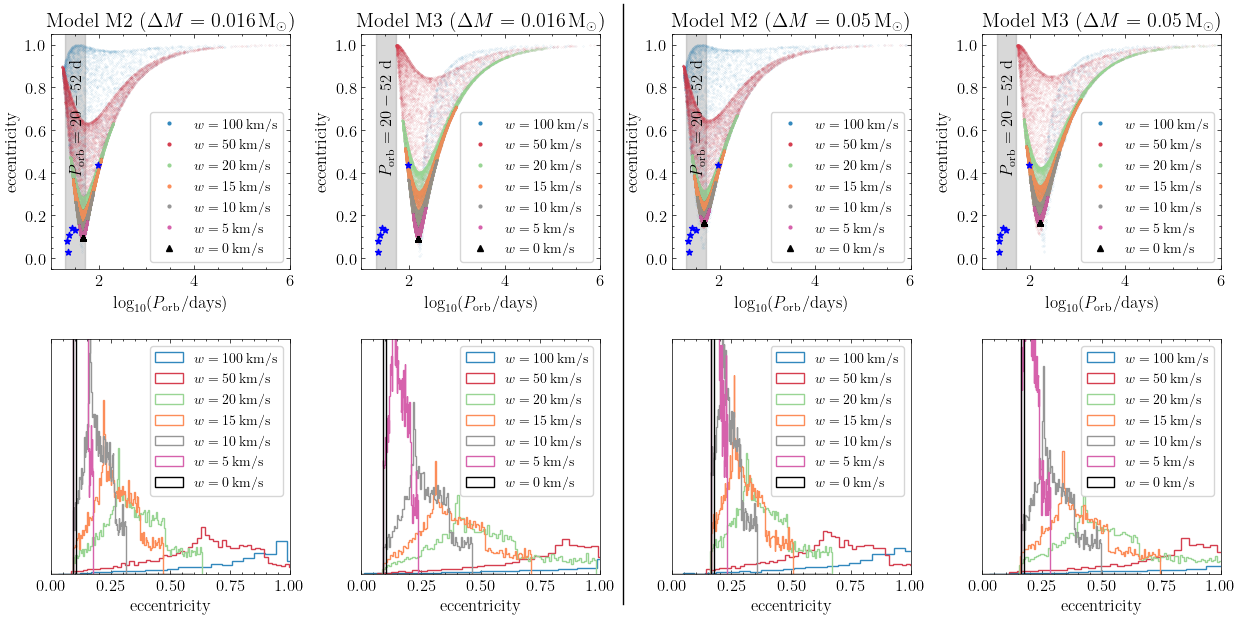

In [39]:
fig, ax = plt.subplots(2,4, figsize=(13,6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)

ax[1,0].yaxis.set_tick_params(labelleft=False)
ax[1,0].set_yticks([])
ax[1,1].yaxis.set_tick_params(labelleft=False)
ax[1,1].set_yticks([])


ax[0,0].set_xlim([1, 6])
ax[0,1].set_xlim([1, 6])
ax[0,0].set_ylim([-0.05, 1.05])
ax[0,1].set_ylim([-0.05, 1.05])

ax[1,0].set_xlim([0, 1])
ax[1,1].set_xlim([0, 1])

ax[1,0].set_ylim([0, 10])
ax[1,1].set_ylim([0, 10])


fontsize=12
ax[0,0].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,0].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,1].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,1].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,0].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,1].set_xlabel("eccentricity", fontsize=fontsize)

ax[1,2].yaxis.set_tick_params(labelleft=False)
ax[1,2].set_yticks([])
ax[1,3].yaxis.set_tick_params(labelleft=False)
ax[1,3].set_yticks([])


ax[0,2].set_xlim([1, 6])
ax[0,3].set_xlim([1, 6])
ax[0,2].set_ylim([-0.05, 1.05])
ax[0,3].set_ylim([-0.05, 1.05])

ax[1,2].set_xlim([0, 1])
ax[1,3].set_xlim([0, 1])

ax[1,2].set_ylim([0, 10])
ax[1,3].set_ylim([0, 10])


ax[0,2].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,2].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,3].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,3].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,2].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,3].set_xlabel("eccentricity", fontsize=fontsize)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']


for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )
    
    ap_case2_dm2 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m2,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )
    
    
    y_case2_dm2 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm2,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm2 = orbital_period_posttrans(ap_case2_dm2,
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m2
    )

    ap_case3_dm2 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m2,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm2 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm2,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m2,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm2 = orbital_period_posttrans(ap_case3_dm2,
                                          model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                          model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m2
    )

    
    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax[1,0].hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,1].hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,2].hist(y_case2_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,3].hist(y_case3_dm2.value, 100, density=True, histtype='step', color=colors[i], label=lbl)

    if w == 0: 
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    
        
    else:
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
        ax[0,2].scatter(
            np.log10(x_case2_dm2.value[x_case2_dm2.value > 0]), 
            y_case2_dm2[x_case2_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,3].scatter(
            np.log10(x_case3_dm2.value[x_case3_dm2.value > 0]), 
            y_case3_dm2[x_case3_dm2.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
    
        
legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

s=10
ax[0,0].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,1].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,2].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,3].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)

ax[1,0].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,1].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,2].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,3].legend(loc='upper right', prop={"size":s}, frameon=True)

ax[0,0].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,1].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,2].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))
ax[0,3].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m2.value))

# Add separating line between subplots
###
ax[0,0].plot([0.49, 0.49], [0, 1.0], color='k', lw=1,
         transform=plt.gcf().transFigure, clip_on=False)




ax[0,0].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-52$ d", rotation=90, fontsize=fontsize, color='k')
ax[0,1].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-52$ d", rotation=90, fontsize=fontsize, color='k')
ax[0,2].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-52$ d", rotation=90, fontsize=fontsize, color='k')
ax[0,3].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-52$ d", rotation=90, fontsize=fontsize, color='k')


ax[0,0].fill_between([np.log10(20), np.log10(52)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)
ax[0,1].fill_between([np.log10(20), np.log10(52)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)
ax[0,2].fill_between([np.log10(20), np.log10(52)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)
ax[0,3].fill_between([np.log10(20), np.log10(52)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)

ax[0,0].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')

ax[0,1].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')

ax[0,2].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,2].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,2].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,2].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,2].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,2].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')

ax[0,3].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,3].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,3].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,3].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,3].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,3].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')


plt.show()
# plt.savefig("mc_sim.png", bbox_inches='tight', dpi=300)

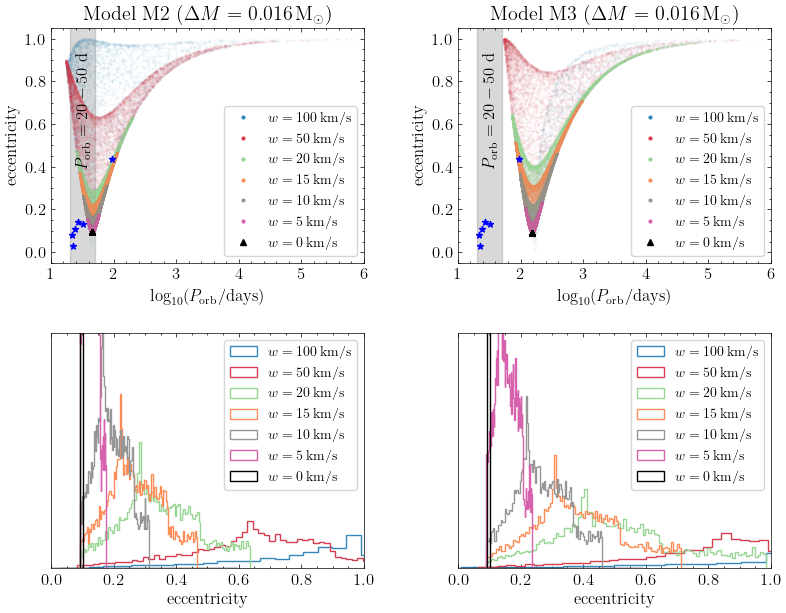

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3
)


ax[1,0].yaxis.set_tick_params(labelleft=False)
ax[1,0].set_yticks([])
ax[1,1].yaxis.set_tick_params(labelleft=False)
ax[1,1].set_yticks([])


ax[0,0].set_xlim([1, 6])
ax[0,1].set_xlim([1, 6])
ax[0,0].set_ylim([-0.05, 1.05])
ax[0,1].set_ylim([-0.05, 1.05])

ax[1,0].set_xlim([0, 1])
ax[1,1].set_xlim([0, 1])

ax[1,0].set_ylim([0, 10])
ax[1,1].set_ylim([0, 10])


fontsize=12
ax[0,0].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,0].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,1].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,1].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,0].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,1].set_xlabel("eccentricity", fontsize=fontsize)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']

for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax[1,0].hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,1].hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    
    if w == 0: 
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    else:
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )


legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

s=10
ax[0,0].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,1].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[1,0].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,1].legend(loc='upper right', prop={"size":s}, frameon=True)

ax[0,0].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,1].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))


ax[0,0].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')
ax[0,1].text(np.log10(25), 0.4, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')


ax[0,0].fill_between([np.log10(20), np.log10(50)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)
ax[0,1].fill_between([np.log10(20), np.log10(50)], -1.0, 2.0, alpha=0.3, color='grey', zorder=0)

ax[0,0].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,0].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')

ax[0,1].scatter(np.log10(95.17), 0.437, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(32), 0.13, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(27), 0.14, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(22), 0.08, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(24), 0.11, s=20, c='b', marker='*')
ax[0,1].scatter(np.log10(22.7), 0.027, s=20, c='b', marker='*')

plt.show()
# plt.savefig("mc_sim.png", bbox_inches='tight', dpi=300)

## Eccentric vs Isolated MSPs

In [41]:
def calculate_unbound_percentage(model, delta_m, w, n_sample=10_000):
    model_data = model_m2 if "case2" in model else model_m3
    transition_idx = transition_idx_case2 if "case2" in model else transition_idx_case3

    ap = a_posttrans(
        model_data["binary_separation"][transition_idx - 1] * u.Rsun,
        delta_m,
        model_data["don_mass"][transition_idx - 1] * u.Msun,
        model_data["ns_mass"][transition_idx - 1],
        w * (u.km / u.s),
        theta_dist,
    )

    ecc = eccentricity_posttrans(
        model_data["binary_separation"][transition_idx - 1] * u.Rsun,
        ap,
        model_data["don_mass"][transition_idx] * u.Msun,
        model_data["ns_mass"][transition_idx] * u.Msun - delta_m,
        w * (u.km / u.s),
        theta_dist,
        phi_dist,
    )

    return len(ecc[ecc.value > 1]) / n_sample


def calculate_eccentric_percentage(
    model, delta_m, w, n_sample=10_000, pmin=0, pmax=3000, emax=0.99, abs_tol=0.08, sub_sample=False
):
    model_data = model_m2 if "case2" in model else model_m3
    transition_idx = transition_idx_case2 if "case2" in model else transition_idx_case3

    ap = a_posttrans(
        model_data["binary_separation"][transition_idx - 1] * u.Rsun,
        delta_m,
        model_data["don_mass"][transition_idx - 1] * u.Msun,
        model_data["ns_mass"][transition_idx - 1],
        w * (u.km / u.s),
        theta_dist,
    )

    ecc = eccentricity_posttrans(
        model_data["binary_separation"][transition_idx - 1] * u.Rsun,
        ap,
        model_data["don_mass"][transition_idx] * u.Msun,
        model_data["ns_mass"][transition_idx] * u.Msun - delta_m,
        w * (u.km / u.s),
        theta_dist,
        phi_dist,
    )

    op = orbital_period_posttrans(
        ap,
        model_data["don_mass"][transition_idx] * u.Msun,
        model_data["ns_mass"][transition_idx] * u.Msun - delta_m,
    )

    counter = 0
    for x, y in zip(op.value, ecc.value):
        if sub_sample:
            if x < pmax and x >= pmin and math.isclose(y, emax, abs_tol=abs_tol):
                counter += 1
        else:
            if x < pmax and x >= pmin and y < emax:
                counter += 1

    return counter / n_sample

In [42]:
kick_velocities = np.linspace(0, 100, 21)

In [43]:
delta_m1 = 0.016 * u.Msun
delta_m2 = 0.015 * u.Msun
delta_m3 = 0.025 * u.Msun
delta_m4 = 0.05 * u.Msun


# Lists to store the percentages
unbound_percentages = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

eccentric_percentages = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

# Models and mass defects combinations
model_combinations = [
    ("case2", delta_m1),
    ("case2", delta_m2),
    ("case2", delta_m3),
    ("case2", delta_m4),
    ("case3", delta_m1),
    ("case3", delta_m2),
    ("case3", delta_m3),
    ("case3", delta_m4),
]


# Iterate over each combination of model and mass defect
for w in kick_velocities:
    for model, delta_m in model_combinations:
        # key = f'{model}_dm{"1" if delta_m == delta_m1 else "2"}'
        key = f'{model}_dm{"1" if delta_m == delta_m1 else ("2" if delta_m == delta_m2 else ("3" if delta_m == delta_m3 else "4"))}'
        unbound_percentages[key].append(
            calculate_unbound_percentage(model, delta_m, w, n_sample=n)
        )
        eccentric_percentages[key].append(
            calculate_eccentric_percentage(model, delta_m, w, n_sample=n)
        )

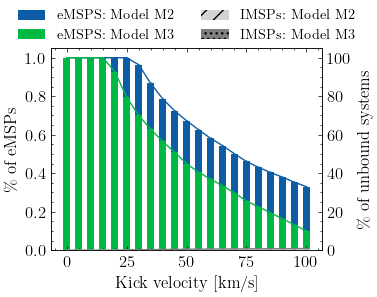

In [44]:
model1, model2 = ("case2_dm1", "case3_dm1")

fig, ax = plt.subplots(1, 1)

ax.set_xlabel("Kick velocity [km/s]")
ax.set_ylabel(r"\% of eMSPs")

ax.bar(
    kick_velocities,
    eccentric_percentages.get(model1),
    width=3,
    label="eMSPS: Model M2",
    zorder=0,
)

ax.plot(kick_velocities, eccentric_percentages.get(model1), marker=".", markersize=1)

ax.bar(
    kick_velocities,
    eccentric_percentages.get(model2),
    width=3,
    label="eMSPS: Model M3",
    zorder=0
)

ax.plot(kick_velocities, eccentric_percentages.get(model2), marker=".", markersize=1)



ax2 = ax.twinx()
ax2.set_ylabel(r"\% of unbound systems")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax2.set_ylim([0, 105])

ax2.bar(
    kick_velocities,
    unbound_percentages.get(model1),
    width=3,
    label="IMSPs: Model M2",
    zorder=2,
    color="lightgrey",
    hatch="//",
)
ax2.bar(
    kick_velocities,
    unbound_percentages.get(model2),
    width=3,
    label="IMSPs: Model M3",
    color="grey",
    hatch="." * 3,
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model1),
    marker=".",
    markersize=1,
    c="lightgrey",
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model2),
    marker=".",
    markersize=1,
    c="grey",
)

# Getting handles and labels for both y-axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combining handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Creating a single legend for the subplot
# plt.legend(combined_handles, combined_labels, loc="upper center")
plt.legend(
    combined_handles,
    combined_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    fontsize="small",
)


plt.show()
# plt.savefig("emsp_vs_imsp1.pdf", dpi=300, bbox_inches='tight')

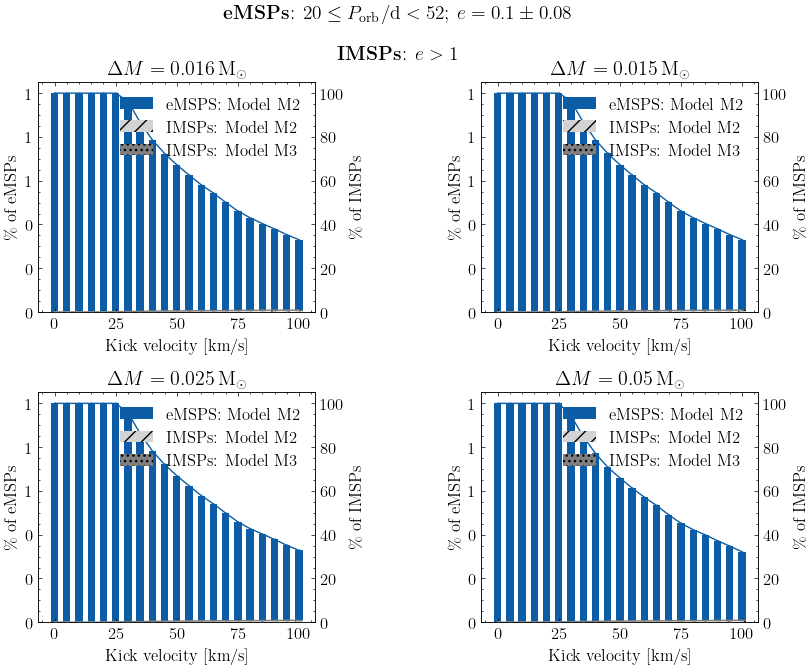

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.6, hspace=0.35
)

delta_ms = ["0.016", "0.015", "0.025", "0.05"]
models = [
    ("case2_dm1", "case3_dm1"),
    ("case2_dm2", "case3_dm2"),
    ("case2_dm3", "case3_dm3"),
    ("case2_dm4", "case3_dm4"),
]

for i, ax in enumerate(ax.flatten()):
    model1, model2 = models[i]

    # Main plot on ax
    ax.set_xlabel("Kick velocity [km/s]")
    ax.set_ylabel(r"\% of eMSPs")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax.bar(
        kick_velocities,
        eccentric_percentages.get(model1),
        width=3,
        label="eMSPS: Model M2",
        zorder=0,
    )
    ax.plot(
        kick_velocities, eccentric_percentages.get(model1), marker=".", markersize=1
    )

    # Secondary plot on ax2 (twin of ax)
    ax2 = ax.twinx()
    ax2.set_ylabel(r"\% of IMSPs")
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax2.set_ylim([0, 105])

    ax2.bar(
        kick_velocities,
        unbound_percentages.get(model1),
        width=3,
        label="IMSPs: Model M2",
        zorder=2,
        color="lightgrey",
        hatch="//",
    )
    ax2.bar(
        kick_velocities,
        unbound_percentages.get(model2),
        width=3,
        label="IMSPs: Model M3",
        color="grey",
        hatch="." * 3,
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages.get(model1),
        marker=".",
        markersize=1,
        c="lightgrey",
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages.get(model2),
        marker=".",
        markersize=1,
        c="grey",
    )

    # Getting handles and labels for both y-axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combining handles and labels
    combined_handles = handles1 + handles2
    combined_labels = labels1 + labels2

    # Creating a single legend for the subplot
    ax.legend(combined_handles, combined_labels, loc="upper right")

    # Set title for each subplot
    ax.set_title(rf"$\Delta M = {delta_ms[i]}\,\mathrm{{M}}_\odot$")

# Global suptitle
suptitle1 = r"\textbf{eMSPs}: $20 \leq P_\mathrm{orb}/\mathrm{d} < 52$; $e=0.1\pm 0.08$"
suptitle2 = r"\textbf{IMSPs}: $e>1$"
fig.suptitle(f"{suptitle1}\n\n{suptitle2}", y=1.08, fontsize=14)

plt.show()
# plt.savefig("emsps_vs_imsps_grid1.pdf", dpi=300, bbox_inches='tight')

In [46]:
delta_m1 = 0.016 * u.Msun
delta_m2 = 0.015 * u.Msun
delta_m3 = 0.025 * u.Msun
delta_m4 = 0.05 * u.Msun


# Lists to store the percentages
unbound_percentages = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

eccentric_percentages = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

# Models and mass defects combinations
model_combinations = [
    ("case2", delta_m1),
    ("case2", delta_m2),
    ("case2", delta_m3),
    ("case2", delta_m4),
    ("case3", delta_m1),
    ("case3", delta_m2),
    ("case3", delta_m3),
    ("case3", delta_m4),
]


# Iterate over each combination of model and mass defect
for w in kick_velocities:
    for model, delta_m in model_combinations:
        # key = f'{model}_dm{"1" if delta_m == delta_m1 else "2"}'
        key = f'{model}_dm{"1" if delta_m == delta_m1 else ("2" if delta_m == delta_m2 else ("3" if delta_m == delta_m3 else "4"))}'
        unbound_percentages[key].append(
            calculate_unbound_percentage(model, delta_m, w, n_sample=n)
        )
        eccentric_percentages[key].append(
            calculate_eccentric_percentage(model, delta_m, w, n_sample=n, pmin=20, pmax=50, emax=0.1, sub_sample=True)
        )

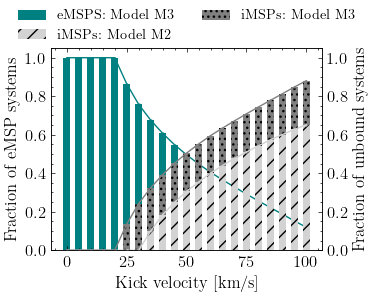

In [47]:
model1, model2 = ("case2_dm1", "case3_dm1")

fig, ax = plt.subplots(1, 1)

ax.set_xlabel("Kick velocity [km/s]")
# ax.set_ylabel(r"Frac. of (eMSP-HeWD)-like sys.")
ax.set_ylabel(r"Fraction of eMSP systems")

ax.bar(
    kick_velocities,
    1 - np.array(unbound_percentages.get(model2)),
    width=3,
    label="eMSPS: Model M3",
    zorder=0,
    color='teal',
)

ax.plot(kick_velocities, 
        1 - np.array(unbound_percentages.get(model2)), 
        marker=".", 
        markersize=1, 
        c='teal',
       )


ax2 = ax.twinx()
ax2.set_ylabel(r"Fraction of unbound systems")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax2.set_ylim([0, 1.05])

ax2.bar(
    kick_velocities,
    unbound_percentages.get(model1),
    width=3,
    label="iMSPs: Model M2",
    zorder=2,
    color="lightgrey",
    hatch="//",
)
ax2.bar(
    kick_velocities,
    unbound_percentages.get(model2),
    width=3,
    label="iMSPs: Model M3",
    color="grey",
    hatch="." * 3,
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model1),
    marker=".",
    markersize=1,
    c="lightgrey",
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model2),
    marker=".",
    markersize=1,
    c="grey"
)

# Getting handles and labels for both y-axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combining handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Creating a single legend for the subplot
# plt.legend(combined_handles, combined_labels, loc="upper center")
plt.legend(
    combined_handles,
    combined_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    fontsize="small",
)

plt.show()
# plt.savefig("figures/emsp_vs_imsp.pdf", dpi=300, bbox_inches='tight')

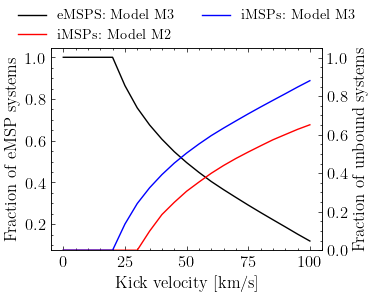

In [48]:
model1, model2 = ("case2_dm1", "case3_dm1")

fig, ax = plt.subplots(1, 1)

ax.set_xlabel("Kick velocity [km/s]")
ax.set_ylabel(r"Fraction of eMSP systems")


ax.plot(kick_velocities, 
        1 - np.array(unbound_percentages.get(model2)),  
        c='k',
        label="eMSPS: Model M3")


ax2 = ax.twinx()
ax2.set_ylabel(r"Fraction of unbound systems")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax2.set_ylim([0, 1.05])


ax2.plot(
    kick_velocities,
    unbound_percentages.get(model1),
    c="r",
    label="iMSPs: Model M2"
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model2),
    c="b",
    label="iMSPs: Model M3"
)

# Getting handles and labels for both y-axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combining handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Creating a single legend for the subplot
plt.legend(
    combined_handles,
    combined_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    fontsize="small",
)

plt.show()
# plt.savefig("figures/emsp_vs_imsp.pdf", dpi=300, bbox_inches='tight')

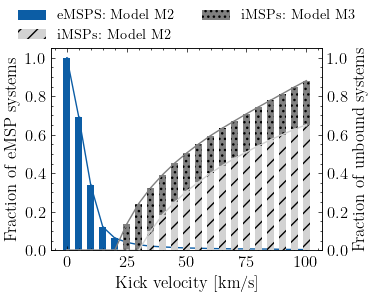

In [49]:
model1, model2 = ("case2_dm1", "case3_dm1")

fig, ax = plt.subplots(1, 1)

ax.set_xlabel("Kick velocity [km/s]")
# ax.set_ylabel(r"Frac. of (eMSP-HeWD)-like sys.")
ax.set_ylabel(r"Fraction of eMSP systems")

ax.bar(
    kick_velocities,
    eccentric_percentages.get(model1),
    width=3,
    label="eMSPS: Model M2",
    zorder=0,
)

ax.plot(kick_velocities, eccentric_percentages.get(model1), marker=".", markersize=1)


ax2 = ax.twinx()
ax2.set_ylabel(r"Fraction of unbound systems")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax2.set_ylim([0, 1.05])

ax2.bar(
    kick_velocities,
    unbound_percentages.get(model1),
    width=3,
    label="iMSPs: Model M2",
    zorder=2,
    color="lightgrey",
    hatch="//",
)
ax2.bar(
    kick_velocities,
    unbound_percentages.get(model2),
    width=3,
    label="iMSPs: Model M3",
    color="grey",
    hatch="." * 3,
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model1),
    marker=".",
    markersize=1,
    c="lightgrey",
)
ax2.plot(
    kick_velocities,
    unbound_percentages.get(model2),
    marker=".",
    markersize=1,
    c="grey",
)

# Getting handles and labels for both y-axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combining handles and labels
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Creating a single legend for the subplot
# plt.legend(combined_handles, combined_labels, loc="upper center")
plt.legend(
    combined_handles,
    combined_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    fontsize="small",
)

plt.show()
# plt.savefig("figures/emsp_vs_imsp1.pdf", dpi=300, bbox_inches='tight')

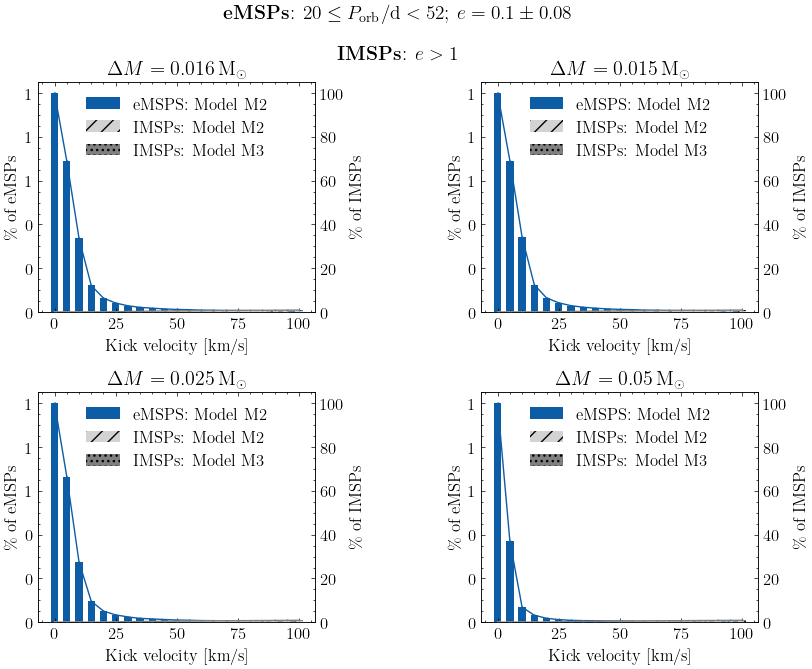

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.6, hspace=0.35
)

delta_ms = ["0.016", "0.015", "0.025", "0.05"]
models = [
    ("case2_dm1", "case3_dm1"),
    ("case2_dm2", "case3_dm2"),
    ("case2_dm3", "case3_dm3"),
    ("case2_dm4", "case3_dm4"),
]

for i, ax in enumerate(ax.flatten()):
    model1, model2 = models[i]

    # Main plot on ax
    ax.set_xlabel("Kick velocity [km/s]")
    ax.set_ylabel(r"\% of eMSPs")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax.bar(
        kick_velocities,
        eccentric_percentages.get(model1),
        width=3,
        label="eMSPS: Model M2",
        zorder=0,
    )
    ax.plot(
        kick_velocities, eccentric_percentages.get(model1), marker=".", markersize=1
    )

    # Secondary plot on ax2 (twin of ax)
    ax2 = ax.twinx()
    ax2.set_ylabel(r"\% of IMSPs")
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax2.set_ylim([0, 105])

    ax2.bar(
        kick_velocities,
        unbound_percentages.get(model1),
        width=3,
        label="IMSPs: Model M2",
        zorder=2,
        color="lightgrey",
        hatch="//",
    )
    ax2.bar(
        kick_velocities,
        unbound_percentages.get(model2),
        width=3,
        label="IMSPs: Model M3",
        color="grey",
        hatch="." * 3,
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages.get(model1),
        marker=".",
        markersize=1,
        c="lightgrey",
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages.get(model2),
        marker=".",
        markersize=1,
        c="grey",
    )

    # Getting handles and labels for both y-axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combining handles and labels
    combined_handles = handles1 + handles2
    combined_labels = labels1 + labels2

    # Creating a single legend for the subplot
    ax.legend(combined_handles, combined_labels, loc="upper center")

    # Set title for each subplot
    ax.set_title(rf"$\Delta M = {delta_ms[i]}\,\mathrm{{M}}_\odot$")

# Global suptitle
suptitle1 = r"\textbf{eMSPs}: $20 \leq P_\mathrm{orb}/\mathrm{d} < 52$; $e=0.1\pm 0.08$"
suptitle2 = r"\textbf{IMSPs}: $e>1$"
fig.suptitle(f"{suptitle1}\n\n{suptitle2}", y=1.08, fontsize=14)

plt.show()
# plt.savefig("emsps_vs_imsps_grid1.pdf", dpi=300, bbox_inches='tight')

In [51]:
delta_m1 = 0.016 * u.Msun
delta_m2 = 0.015 * u.Msun
delta_m3 = 0.025 * u.Msun
delta_m4 = 0.05 * u.Msun


# Lists to store the percentages
unbound_percentages2 = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

eccentric_percentages2 = {
    "case2_dm1": [],
    "case2_dm2": [],
    "case2_dm3": [],
    "case2_dm4": [],
    "case3_dm1": [],
    "case3_dm2": [],
    "case3_dm3": [],
    "case3_dm4": [],
}

# Models and mass defects combinations
model_combinations = [
    ("case2", delta_m1),
    ("case2", delta_m2),
    ("case2", delta_m3),
    ("case2", delta_m4),
    ("case3", delta_m1),
    ("case3", delta_m2),
    ("case3", delta_m3),
    ("case3", delta_m4),
]


# Iterate over each combination of model and mass defect
for w in np.linspace(0, 100, 21):
    for model, delta_m in model_combinations:
        # key = f'{model}_dm{"1" if delta_m == delta_m1 else "2"}'
        key = f'{model}_dm{"1" if delta_m == delta_m1 else ("2" if delta_m == delta_m2 else ("3" if delta_m == delta_m3 else "4"))}'
        unbound_percentages2[key].append(
            calculate_unbound_percentage(model, delta_m, w, n_sample=n)
        )
        eccentric_percentages2[key].append(
            calculate_eccentric_percentage(model, delta_m, w, n_sample=n, pmin=90, pmax=100, emax=0.4, abs_tol=0.04)
        )

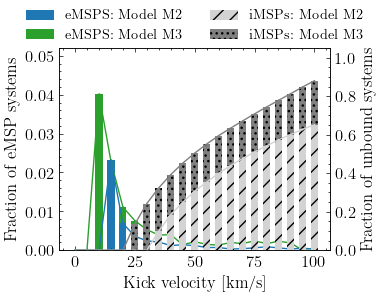

In [52]:
model1, model2 = ("case2_dm1", "case3_dm1")

fig, ax = plt.subplots(1, 1)

ax.set_xlabel("Kick velocity [km/s]")
# ax.set_ylabel(r"Frac. of (PSR J1903+0327)-like sys.")
ax.set_ylabel(r"Fraction of eMSP systems")
ax.set_ylim([0, 0.052])

ax.bar(
    kick_velocities,
    eccentric_percentages2.get(model2),
    width=3,
    label="eMSPS: Model M3",
    color='tab:green'
)

ax.plot(kick_velocities, eccentric_percentages2.get(model2), marker=".", markersize=1, color='tab:green')

ax.bar(
    kick_velocities,
    eccentric_percentages2.get(model1),
    width=3,
    label="eMSPS: Model M2",
    color='tab:blue'
)

ax.plot(kick_velocities, eccentric_percentages2.get(model1), marker=".", markersize=1, color='tab:blue')



ax2 = ax.twinx()
ax2.set_ylabel(r"Fraction of unbound systems")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax2.set_ylim([0, 1.05])

ax2.bar(
    kick_velocities,
    unbound_percentages2.get(model1),
    width=3,
    label="iMSPs: Model M2",
    zorder=2,
    color="lightgrey",
    hatch="//",
)
ax2.plot(
    kick_velocities,
    unbound_percentages2.get(model1),
    marker=".",
    markersize=1,
    c="lightgrey",
)

ax2.bar(
    kick_velocities,
    unbound_percentages2.get(model2),
    width=3,
    label="iMSPs: Model M3",
    color="grey",
    hatch="." * 3,
)
ax2.plot(
    kick_velocities,
    unbound_percentages2.get(model2),
    marker=".",
    markersize=1,
    c="grey",
)





# Getting handles and labels for both y-axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combining handles and labels
combined_handles = handles1[::-1] + handles2
combined_labels = labels1[::-1] + labels2

# Creating a single legend for the subplot
# plt.legend(combined_handles, combined_labels, loc="upper right")
plt.legend(
    combined_handles,
    combined_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    fontsize="small",
)



plt.show()
# plt.savefig("figures/emsp_vs_imsp2.pdf", dpi=300, bbox_inches='tight')

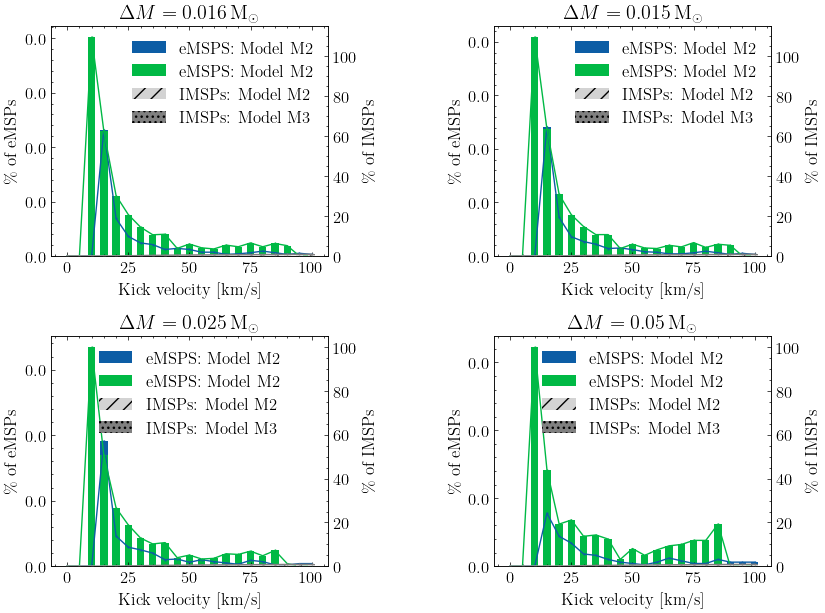

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.6, hspace=0.35
)

delta_ms = ["0.016", "0.015", "0.025", "0.05"]
models = [
    ("case2_dm1", "case3_dm1"),
    ("case2_dm2", "case3_dm2"),
    ("case2_dm3", "case3_dm3"),
    ("case2_dm4", "case3_dm4"),
]

for i, ax in enumerate(ax.flatten()):
    model1, model2 = models[i]

    # Main plot on ax
    ax.set_xlabel("Kick velocity [km/s]")
    ax.set_ylabel(r"\% of eMSPs")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
    ax.bar(
        kick_velocities,
        eccentric_percentages2.get(model1),
        width=3,
        label="eMSPS: Model M2",
        zorder=0,
    )
    ax.plot(
        kick_velocities, eccentric_percentages2.get(model1), marker=".", markersize=1
    )
    
    ax.bar(
        kick_velocities,
        eccentric_percentages2.get(model2),
        width=3,
        label="eMSPS: Model M2",
        zorder=0,
    )
    ax.plot(
        kick_velocities, eccentric_percentages2.get(model2), marker=".", markersize=1
    )

    # Secondary plot on ax2 (twin of ax)
    ax2 = ax.twinx()
    ax2.set_ylabel(r"\% of IMSPs")
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    if i == 0 or i == 1:
        ax2.set_ylim([0, 115])
        loc='upper right'
    else:
        ax2.set_ylim([0, 105])
        loc='upper center'

    ax2.bar(
        kick_velocities,
        unbound_percentages2.get(model1),
        width=3,
        label="IMSPs: Model M2",
        zorder=2,
        color="lightgrey",
        hatch="//",
    )
    ax2.bar(
        kick_velocities,
        unbound_percentages2.get(model2),
        width=3,
        label="IMSPs: Model M3",
        color="grey",
        hatch="." * 3,
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages2.get(model1),
        marker=".",
        markersize=1,
        c="lightgrey",
    )
    ax2.plot(
        kick_velocities,
        unbound_percentages2.get(model2),
        marker=".",
        markersize=1,
        c="grey",
    )

    # Getting handles and labels for both y-axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combining handles and labels
    combined_handles = handles1 + handles2
    combined_labels = labels1 + labels2

    # Creating a single legend for the subplot  
    ax.legend(combined_handles, combined_labels, loc=loc)

    # Set title for each subplot
    ax.set_title(rf"$\Delta M = {delta_ms[i]}\,\mathrm{{M}}_\odot$")

# Global suptitle
# suptitle1 = r"\textbf{eMSPs}: $90 \leq P_\mathrm{orb}/\mathrm{d} < 100$; $e=0.4\pm 0.04$"
# suptitle2 = r"\textbf{IMSPs}: $e>1$"
# fig.suptitle(f"{suptitle1}\n\n{suptitle2}", y=1.08, fontsize=14)

plt.show()
# plt.savefig("emsps_vs_imsps_grid2.pdf", dpi=300, bbox_inches='tight')

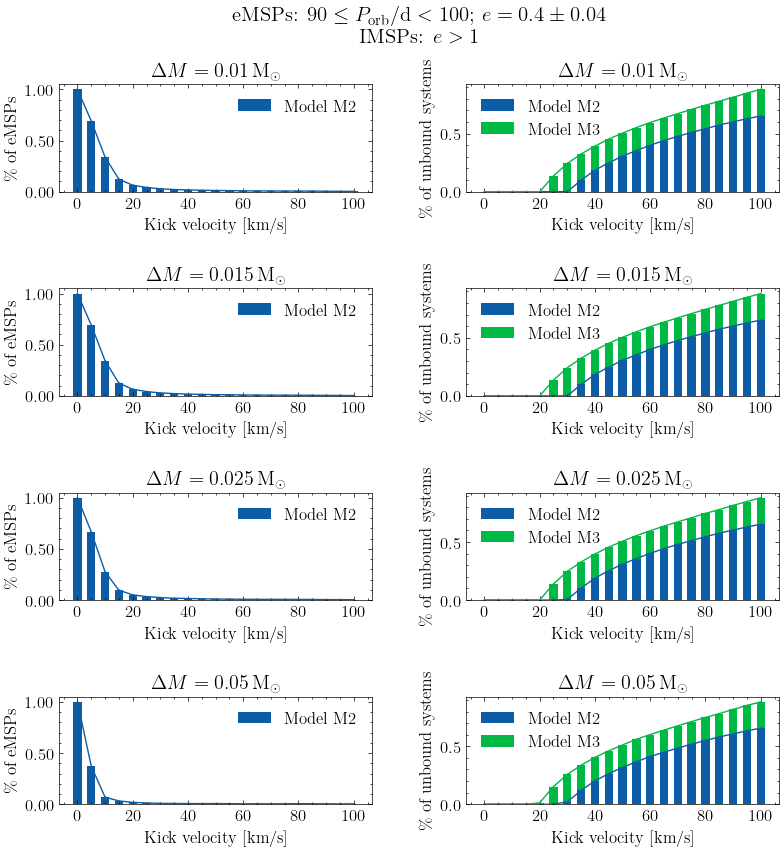

In [54]:
fig, ax = plt.subplots(4, 2, figsize=(8, 8), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3
)

# Add vertical whitespace between the rows of subfigures
plt.subplots_adjust(hspace=0.9)  # Adjust this value as needed


ax[0, 0].set_xlabel("Kick velocity [km/s]")
ax[0, 1].set_xlabel("Kick velocity [km/s]")
ax[1, 0].set_xlabel("Kick velocity [km/s]")
ax[1, 1].set_xlabel("Kick velocity [km/s]")
ax[2, 0].set_xlabel("Kick velocity [km/s]")
ax[2, 1].set_xlabel("Kick velocity [km/s]")
ax[3, 0].set_xlabel("Kick velocity [km/s]")
ax[3, 1].set_xlabel("Kick velocity [km/s]")

ax[0, 0].set_ylabel(r"\% of eMSPs")
ax[1, 0].set_ylabel(r"\% of eMSPs")
ax[2, 0].set_ylabel(r"\% of eMSPs")
ax[3, 0].set_ylabel(r"\% of eMSPs")
ax[0, 1].set_ylabel(r"\% of unbound systems")
ax[1, 1].set_ylabel(r"\% of unbound systems")
ax[2, 1].set_ylabel(r"\% of unbound systems")
ax[3, 1].set_ylabel(r"\% of unbound systems")

# ----
ax[0, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax[0, 0].bar(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm1"),
    width=3,
    label="Model M2",
    zorder=0,
)
ax[0, 0].plot(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm1"),
    marker=".",
    markersize=1,
)
ax[0, 0].legend()
ax[0, 0].set_title(r"$\Delta M = 0.01\,\mathrm{M}_\odot$")

# ----
ax[0, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm1"),
    width=3,
    label="Model M2",
    zorder=2,
)
ax[0, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm1"),
    width=3,
    label="Model M3",
)
ax[0, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm1"),
    marker=".",
    markersize=1,
)
ax[0, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm1"),
    marker=".",
    markersize=1,
)
ax[0, 1].legend()
ax[0, 1].set_title(r"$\Delta M = 0.01\,\mathrm{M}_\odot$")

# ----
ax[1, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax[1, 0].bar(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm2"),
    width=3,
    label="Model M2",
    zorder=0,
)
ax[1, 0].plot(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm2"),
    marker=".",
    markersize=1,
)
ax[1, 0].legend()
ax[1, 0].set_title(r"$\Delta M = 0.015\,\mathrm{M}_\odot$")

# ----
ax[1, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm2"),
    width=3,
    label="Model M2",
    zorder=2,
)
ax[1, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm2"),
    width=3,
    label="Model M3",
)
ax[1, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm2"),
    marker=".",
    markersize=1,
)
ax[1, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm2"),
    marker=".",
    markersize=1,
)
ax[1, 1].legend()
ax[1, 1].set_title(r"$\Delta M = 0.015\,\mathrm{M}_\odot$")

# ----
ax[2, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax[2, 0].bar(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm3"),
    width=3,
    label="Model M2",
    zorder=0,
)
ax[2, 0].plot(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm3"),
    marker=".",
    markersize=1,
)
ax[2, 0].legend()
ax[2, 0].set_title(r"$\Delta M = 0.025\,\mathrm{M}_\odot$")

# ----
ax[2, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm3"),
    width=3,
    label="Model M2",
    zorder=2,
)
ax[2, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm3"),
    width=3,
    label="Model M3",
)
ax[2, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm3"),
    marker=".",
    markersize=1,
)
ax[2, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm3"),
    marker=".",
    markersize=1,
)
ax[2, 1].legend()
ax[2, 1].set_title(r"$\Delta M = 0.025\,\mathrm{M}_\odot$")

# ----
ax[3, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax[3, 0].bar(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm4"),
    width=3,
    label="Model M2",
    zorder=0,
)
ax[3, 0].plot(
    np.linspace(0, 100, 21),
    eccentric_percentages.get("case2_dm4"),
    marker=".",
    markersize=1,
)
ax[3, 0].legend()
ax[3, 0].set_title(r"$\Delta M = 0.05\,\mathrm{M}_\odot$")

# ----
ax[3, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm4"),
    width=3,
    label="Model M2",
    zorder=2,
)
ax[3, 1].bar(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm4"),
    width=3,
    label="Model M3",
)
ax[3, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case2_dm4"),
    marker=".",
    markersize=1,
)
ax[3, 1].plot(
    np.linspace(0, 100, 21),
    unbound_percentages.get("case3_dm4"),
    marker=".",
    markersize=1,
)
ax[3, 1].legend()
ax[3, 1].set_title(r"$\Delta M = 0.05\,\mathrm{M}_\odot$")


suptitle1 = r"eMSPs: $90 \leq P_\mathrm{orb}/\mathrm{d} < 100$; $e=0.4\pm 0.04$"
suptitle2 = r"IMSPs: $e>1$"
fig.suptitle(
    f"{suptitle1}\n{suptitle2}", y=1.05, fontsize=15
)

plt.show()

# Sandbox

## Getting data for MSPs from the ATNF Pulsar Catalogue

We execute the following query: ```(PB > 1 && PB < 120) && (ECC >= 1e-7 && ECC < 0.45) && (F0 > 50 && F0 < 1000)```

The resulted table is saved as a csv file which is then loaded here as a Pandas DataFrame.

In [55]:
plt.style.use(["default", "science"])

In [56]:
df = pd.read_csv("data/atnf_data.csv", delimiter=';')
df.head()

,#,NAME,P0,F0,PB,ECC,Median,BINCOMP,Unnamed: 8
0,1,B0021-72E,0.003536,282.779107,2.2568,0.000316,0.1809,*,NaN
1,2,B0021-72H,0.003210,311.493418,2.3577,0.070560,0.1918,He[fck+03],NaN
2,3,J0024-7204Q,0.004033,247.943237,1.1891,0.000080,0.2069,He[rvh+15],NaN
3,4,J0024-7204S,0.002830,353.306209,1.2017,0.000398,0.1028,He[rvh+15],NaN
4,5,J0024-7204T,0.007588,131.778699,1.1262,0.000400,0.1954,He[cpf+15],NaN


In [57]:
# Create masks to separate circular from eccentric MSPs
circular_msp_mask = df["ECC"] < 1e-3

emsp_mask = (
    (df["ECC"] > 2e-2)
    & (df["PB"] > 20)
    & (df["BINCOMP"].apply(lambda x: x.startswith("He") or x == "*"))
)

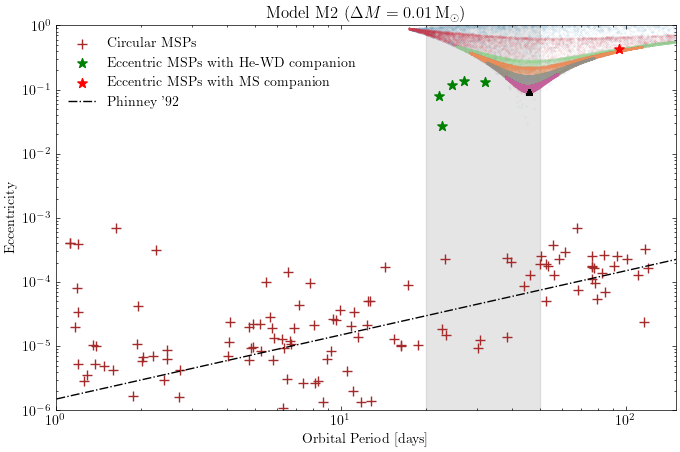

In [58]:
plt.figure(figsize=(8, 5))

plt.yscale("log")
plt.xscale("log")
plt.xlim([1, 150])
plt.ylim([1e-6, 1])

plt.xlabel("Orbital Period [days]")
plt.ylabel("Eccentricity")
plt.title(r"Model M2 $(\Delta M = 0.01\,\rm M_\odot)$")


plt.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)

## Plot ATNF Pulsar Catalogue data ##
#####################################
plt.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=50,
    c="brown",
    marker="+",
    label="Circular MSPs",
)
plt.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="g",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
plt.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="r",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)

phinney = lambda p: 1.5e-4 * (p / 100)
porbs = np.linspace(0.1, 1000)
plt.plot(porbs, phinney(porbs), ls="-.", c="k", label="Phinney '92")
#####################################


## Plot MC simulation ##
########################

# Mass defect
delta_m = 0.016 * u.Msun

ws = [100, 50, 20, 15, 10, 5, 0]
for i, w in enumerate(ws):

    ap_case2_dm = a_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        delta_m,
        model_m2["don_mass"][transition_idx_case2 - 1] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2 - 1],
        w * (u.km / u.s),
        theta_dist,
    )

    y_case2_dm = eccentricity_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
        w * (u.km / u.s),
        theta_dist,
        phi_dist,
    )

    x_case2_dm = orbital_period_posttrans(
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
    )

    if w == 0:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker="^",
            s=10,
            c=colors[i],
            zorder=100,
        )
    else:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker=".",
            s=0.1,
            c=colors[i],
        )
########################
plt.legend(loc="upper left", frameon=False)

# plt.axhline(0.07)
# plt.axvline(45.5)
# plt.axhline(7e-5)

plt.show()

# plt.savefig("binary_msps_ecc_dm0p001.png", dpi=300, bbox_inches='tight')

In [59]:
# Define the Phinney line equation
def phinney_line(P_b):
    return 1.5e-4 * (P_b / 100)

# Define the Boltzmann distribution
def boltzmann_distribution(e, e0):
    return (2/(e0*e0*np.sqrt(2*np.pi))) * np.exp(-(2*e*e)/(e0**4))

# Define the relation for mass-period
def mass_period_relation(P):
    return (P/(1.2e5))**(1/4.5) + 0.120

def kepler(p,m1,m2):
    p = u.Quantity(p, u.d)
    m1 = u.Quantity(m1, u.Msun)
    m2 = u.Quantity(m2, u.Msun)
    return ((p**2 * const.G * (m1+m2) / (4*np.pi**2))**(1/3)).to(u.AU)

def kepler_reverse(a, m1, m2):
    a = u.Quantity(a, u.AU)
    m1 = u.Quantity(m1, u.Msun)
    m2 = u.Quantity(m2, u.Msun)
    period = ((4 * np.pi**2 * a**3) / (const.G * (m1 + m2)))**0.5
    return period.to(u.d)

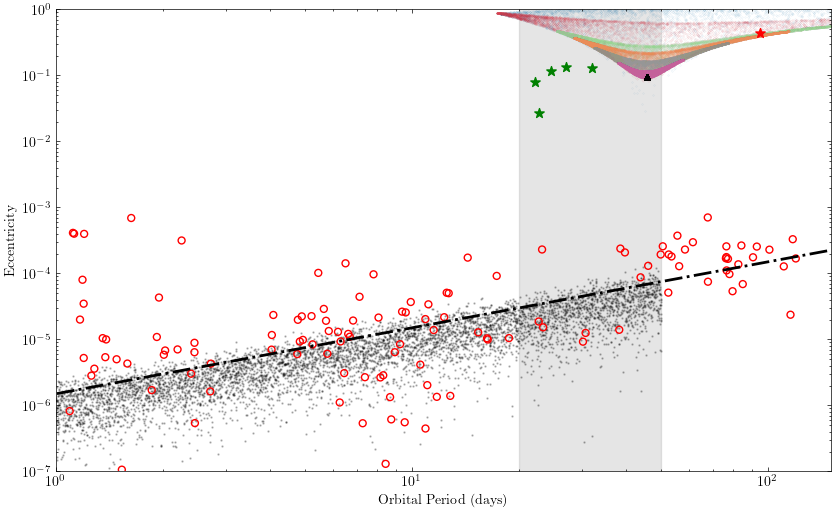

In [60]:
# Parameters
num_samples = 10 # Number of eccentricities to sample per orbital period
num_periods = 1000  # Number of different orbital periods to simulate
min_period = 0.1  # Minimum orbital period in days
max_period = 50  # Maximum orbital period in days

# Orbital periods (logarithmically spaced)
periods = np.logspace(np.log10(min_period), np.log10(max_period), num=num_periods)

# Arrays to store results
orbital_periods = []
eccentricities = []

# Loop over orbital periods
for P in periods:
    # Calculate e0 using Phinney line equation
    e0 = phinney_line(P)
    
    # Draw eccentricities from Boltzmann distribution
    samples = np.random.rayleigh(scale=e0/2, size=num_samples)
    
    # Append orbital period and eccentricities to arrays
    orbital_periods.extend([P] * num_samples)
    eccentricities.extend(samples)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=2, c='k', ls='-.')
plt.scatter(orbital_periods, eccentricities, color='k', alpha=0.25, s=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Eccentricity')

plt.xlim([1, 150])
plt.ylim([1e-7, 1])

## Plot ATNF Pulsar Catalogue data ##
#####################################
plt.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=25,
    marker="o",
    facecolors='none',
    edgecolors='r',
    label="Circular MSPs",
)
plt.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="g",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
plt.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="r",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)
#####################################

# Mass defect
delta_m = 0.016 * u.Msun

ws = [100, 50, 20, 15, 10, 5, 0]
for i, w in enumerate(ws):

    ap_case2_dm = a_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        delta_m,
        model_m2["don_mass"][transition_idx_case2 - 1] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2 - 1],
        w * (u.km / u.s),
        theta_dist,
    )

    y_case2_dm = eccentricity_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
        w * (u.km / u.s),
        theta_dist,
        phi_dist,
    )

    x_case2_dm = orbital_period_posttrans(
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
    )

    if w == 0:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker="^",
            s=10,
            c=colors[i],
            zorder=100,
        )
    else:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker=".",
            s=0.1,
            c=colors[i],
        )

plt.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)
plt.show()

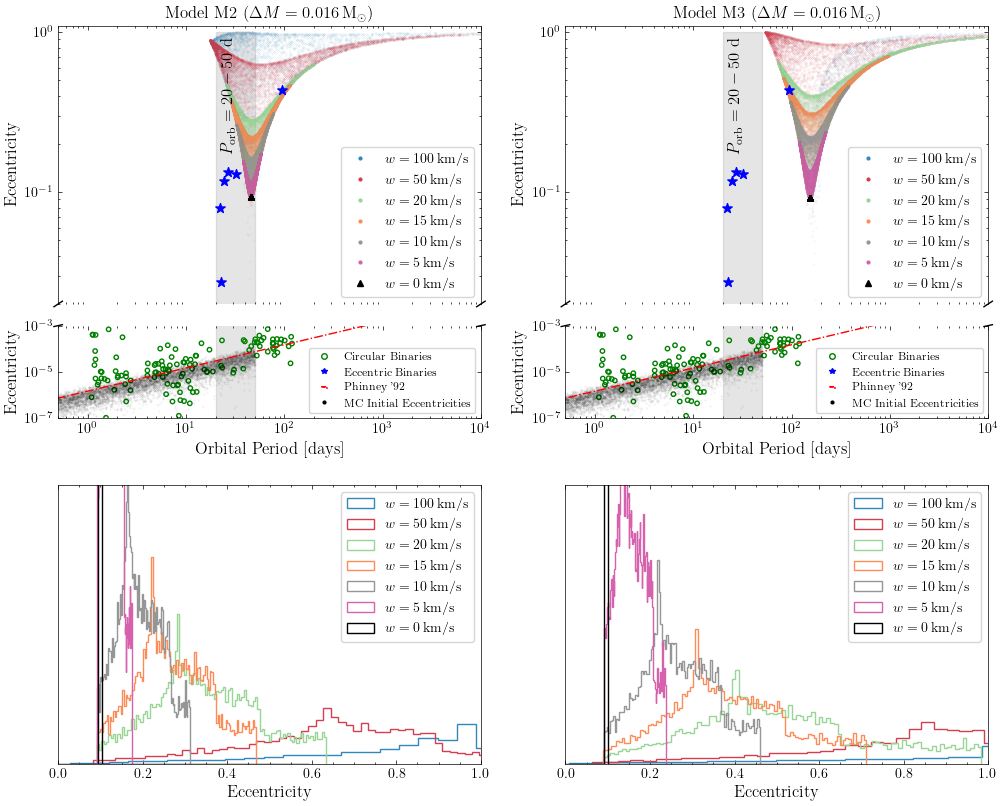

In [61]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1, 3]})

# Adjust the subplots to make space for the breaks
fig.subplots_adjust(hspace=0.1)

# Plot on the first column with broken y-axis : MODEL M2
(ax1_top, ax1_mid, ax1_bottom) = axs[:, 0]

# Plot on the second column with broken y-axis : MODEL M3
(ax2_top, ax2_mid, ax2_bottom) = axs[:, 1]



# MC simulations for post-transition systems with various kicks
# Mass defect
delta_m = 0.016 * u.Msun

# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']


### TOP AND BOTTOM PANELS ###
for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax1_bottom.hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax2_bottom.hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    
    if w == 0: 
        ax1_top.scatter(
            x_case2_dm1.value[x_case2_dm1.value > 0], 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax2_top.scatter(
            x_case3_dm1.value[x_case3_dm1.value > 0], 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    else:
        ax1_top.scatter(
            x_case2_dm1.value[x_case2_dm1.value > 0], 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax2_top.scatter(
            x_case3_dm1.value[x_case3_dm1.value > 0], 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )

ax1_top.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)
ax2_top.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)

# ATNF pulsars
ax1_top.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="b",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
ax1_top.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="b",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)
ax2_top.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="b",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
ax2_top.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="b",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)





### MID PANEL ###
# Phinney line + MC for initial eccentricities distribution
ax1_mid.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=10,
    marker="o",
    facecolors='none',
    edgecolors='g',
    label="Circular MSPs",
)
ax1_mid.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=1, c='r', ls='-.')
ax1_mid.scatter(orbital_periods, eccentricities, color='k', alpha=0.1, s=0.1)
ax1_mid.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)

ax2_mid.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=10,
    marker="o",
    facecolors='none',
    edgecolors='g',
    label="Circular MSPs",
)
ax2_mid.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=1, c='r', ls='-.')
ax2_mid.scatter(orbital_periods, eccentricities, color='k', alpha=0.1, s=0.1)
ax2_mid.fill_between([20, 50], -1.0, 1.0, alpha=0.2, color="grey", zorder=0)



# Annotations etc
ax1_top.text(22.5, 0.18, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')
ax2_top.text(22.5, 0.18, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')





# Plot settings
ax1_top.set_xlim([0.5, 1e4])
ax1_top.set_ylim(2e-2, 1.1)
ax1_top.set_yscale('log')
ax1_top.set_xscale('log')
ax1_top.spines['bottom'].set_visible(False)
ax1_top.tick_params(bottom=False, labelbottom=False)  # Disable x-axis labels

ax1_mid.set_xlim([0.5, 1e4])
ax1_mid.set_ylim(1e-7, 1e-3)
ax1_mid.set_yscale('log')
ax1_mid.set_xscale('log')
ax1_mid.spines['top'].set_visible(False)

ax1_bottom.set_xlim([0, 1])
ax1_bottom.set_ylim([0, 10])
ax1_bottom.yaxis.set_tick_params(labelleft=False)
ax1_bottom.set_yticks([])



ax2_top.set_xlim([0.5, 1e4])
ax2_top.set_ylim(2e-2, 1.1)
ax2_top.set_yscale('log')
ax2_top.set_xscale('log')
ax2_top.spines['bottom'].set_visible(False)
ax2_top.tick_params(bottom=False, labelbottom=False)  # Disable x-axis labels

ax2_mid.set_xlim([0.5, 1e4])
ax2_mid.set_ylim(1e-7, 1e-3)
ax2_mid.set_yscale('log')
ax2_mid.set_xscale('log')
ax2_mid.spines['top'].set_visible(False)

ax2_bottom.set_xlim([0, 1])
ax2_bottom.set_ylim([0, 10])
ax2_bottom.yaxis.set_tick_params(labelleft=False)
ax2_bottom.set_yticks([])




# Labels
fontsize=12
ax1_top.set_ylabel('Eccentricity', fontsize=fontsize)
ax1_mid.set_ylabel('Eccentricity', fontsize=fontsize)
ax1_mid.set_xlabel('Orbital Period [days]', fontsize=fontsize)
ax1_bottom.set_xlabel('Eccentricity', fontsize=fontsize)

ax2_top.set_ylabel('Eccentricity', fontsize=fontsize)
ax2_mid.set_ylabel('Eccentricity', fontsize=fontsize)
ax2_mid.set_xlabel('Orbital Period [days]', fontsize=fontsize)
ax2_bottom.set_xlabel('Eccentricity', fontsize=fontsize)





# Break indicators for the first column
d = .01  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1_top.transAxes, color='k', clip_on=False)
ax1_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1_mid.transAxes)  # switch to the mid axes
ax1_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # mid-left diagonal
ax1_mid.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # mid-right diagonal


# Break indicators for the second column
kwargs = dict(transform=ax2_top.transAxes, color='k', clip_on=False)
ax2_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2_mid.transAxes)  # switch to the mid axes
ax2_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # mid-left diagonal
ax2_mid.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # mid-right diagonal



# Add more space between the second and third rows
pos3 = ax1_bottom.get_position()
ax1_bottom.set_position([pos3.x0, pos3.y0 - 0.05, pos3.width, pos3.height])  # Increase y0 to add space
pos4 = ax2_bottom.get_position()
ax2_bottom.set_position([pos4.x0, pos4.y0 - 0.05, pos4.width, pos4.height])  # Increase y0 to add space



# Legends 
kicks_legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

other_legend_elements = [Line2D([0], [0], marker='o', color='g', linestyle='None', label='Circular Binaries',
                          markerfacecolor='None', markersize=4, zorder=10),
                   Line2D([0], [0], marker='*', color='b', linestyle='None', label='Eccentric Binaries',
                          markerfacecolor='b', markersize=4, zorder=10),
                   Line2D([0], [0], marker='$-.$', color='r', linestyle='None', label="Phinney \'92",
                          markerfacecolor='None', markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color='k', linestyle='None', label='MC Initial Eccentricities',
                          markerfacecolor='k', markersize=4, zorder=10),
                  ]        

s=10
ax1_top.legend(loc="lower right", handles=kicks_legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax2_top.legend(loc="lower right", handles=kicks_legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax1_mid.legend(loc="lower right", handles=other_legend_elements, prop={"size":s-2}, ncol=1, frameon=True)
ax2_mid.legend(loc="lower right", handles=other_legend_elements, prop={"size":s-2}, ncol=1, frameon=True)
ax1_bottom.legend(loc='upper right', frameon=True)
ax2_bottom.legend(loc='upper right', frameon=True)

ax1_top.set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax2_top.set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))

plt.show()
# plt.savefig("mc_sim2.png", bbox_inches='tight', dpi=300)

In [62]:
df2 = pd.read_table("data/emsp_atnf.txt", sep=';', header=None).drop(columns=[0,5])
df2.rename({1:"NAME", 2:"PB", 3:"ECC", 4:"BINCOMP"}, axis=1, inplace=True)
df2.head()

,NAME,PB,ECC,BINCOMP
0,B0021-72H,2.3577,0.07056,He[fck+03]
1,J0453+1559,4.0725,0.11250,NS[msf+15]
2,J0514-4002A,18.7852,0.88800,NS(?)[rfgr19]
3,J0514-4002D,5.6860,0.86200,CO[rfg+22]
4,J0514-4002E,7.4480,0.70800,NS[rfg+22]


In [63]:
emsp_hewd = (
    (df2["BINCOMP"].apply(lambda x: x.startswith("He"))) | (df2["NAME"] == "J0955-6150")
)

emsp_ms = (
    df2["BINCOMP"].apply(lambda x: x.startswith("MS"))
)

emsp_co = (
    df2["BINCOMP"].apply(lambda x: x.startswith("CO"))
)

emsp_other = (
    (df2["BINCOMP"].apply(lambda x: x.startswith("*"))) & (df2["NAME"] != "J0955-6150")
)

In [64]:
plt.style.use(["default", "science", "dark_background"])

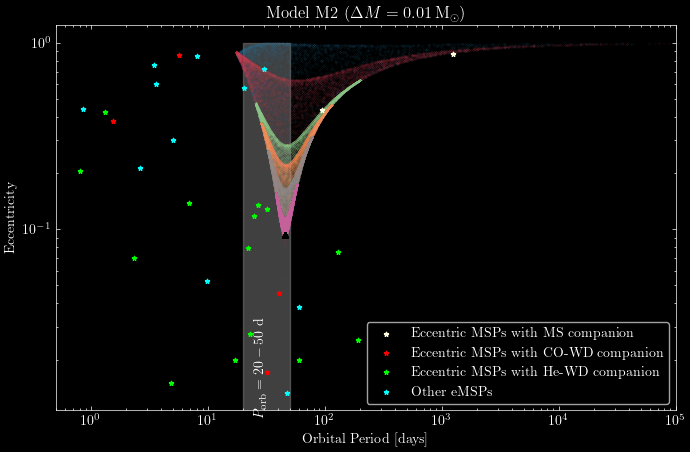

In [65]:
plt.figure(figsize=(8, 5))

plt.yscale("log")
plt.xscale("log")
# plt.xlim([1, 150])
# plt.ylim([1e-6, 1])

plt.xlabel("Orbital Period [days]")
plt.ylabel("Eccentricity")
plt.title(r"Model M2 $(\Delta M = 0.01\,\rm M_\odot)$")


plt.fill_between([20, 50], -1.0, 1.0, alpha=0.5, color="grey", zorder=0)

## Plot ATNF Pulsar Catalogue data ##
#####################################
# plt.scatter(df2.period, df2.eccentricity, s=10, marker='*', c='blue', zorder=100)

# plt.scatter(
#     df["PB"][circular_msp_mask],
#     df["ECC"][circular_msp_mask],
#     s=50,
#     c="brown",
#     marker="+",
#     label="Circular MSPs",
# )
plt.scatter(
    df2["PB"][emsp_ms],
    df2["ECC"][emsp_ms],
    s=10,
    c="lightyellow",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)

plt.scatter(
    df2["PB"][emsp_co],
    df2["ECC"][emsp_co],
    s=10,
    c="r",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with CO-WD companion",
)

plt.scatter(
    df2["PB"][emsp_hewd],
    df2["ECC"][emsp_hewd],
    s=10,
    c="lime",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)

plt.scatter(
    df2["PB"][emsp_other],
    df2["ECC"][emsp_other],
    s=10,
    c="cyan",
    marker="*",
    zorder=100,
    label="Other eMSPs",
)

# phinney = lambda p: 1.5 * 1e-4 * (p / 100)
# porbs = np.linspace(0.1, 1000)
# plt.plot(porbs, phinney(porbs), ls="-.", c="k", label="Phinney '92")
#####################################


## Plot MC simulation ##
########################

# Mass defect
delta_m = 0.016 * u.Msun

ws = [100, 50, 20, 15, 10, 5, 0]
colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', '#969696', '#d661ac', 'black']
for i, w in enumerate(ws):

    ap_case2_dm = a_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        delta_m,
        model_m2["don_mass"][transition_idx_case2 - 1] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2 - 1],
        w * (u.km / u.s),
        theta_dist,
    )

    y_case2_dm = eccentricity_posttrans(
        model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
        w * (u.km / u.s),
        theta_dist,
        phi_dist,
    )

    x_case2_dm = orbital_period_posttrans(
        ap_case2_dm,
        model_m2["don_mass"][transition_idx_case2] * u.Msun,
        model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m,
    )

    if w == 0:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker="^",
            s=10,
            c=colors[i],
            zorder=100,
        )
    else:
        plt.scatter(
            x_case2_dm.value[x_case2_dm.value > 0],
            y_case2_dm[x_case2_dm.value > 0],
            alpha=0.25,
            marker=".",
            s=0.1,
            c=colors[i],
        )
#######################

plt.text(25, 0.01, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=10, color='white')
plt.legend(loc="lower right", frameon=True)

plt.xlim([0.5,1e5])

plt.show()
# plt.savefig("mc_sim_model2_black_bg.pdf", dpi=300, bbox_inches='tight')

## Rocket effect and Gravitational Wave Recoil

Harrison & Tademaru formulation for rocket effect kick:
$$V_\mathrm{kick}^\mathrm{HT} \approx 140 R^2_{10} \left(\frac{s}{10\,\mathrm{km}}\right)\left(\frac{f_i}{1\,\mathrm{kHz}}\right)^3\left[1 - \left(\frac{f}{f_i}\right)^3\right]\,\mathrm{km/s}$$

The energy radiated from a magnetic dipole is proportional to the square of magnetic moment. Assume that the kick velocity:

$$V_\mathrm{kick} \propto \mu^2 \propto B^2$$

Assume further that the HT formulation approximates magnetic fields of $B \sim 10^{12}\,\mathrm{G}$.

For weaker magnetic fields of order $B \sim 10^8\,\mathrm{G}$, we rescale as:

$$\left(\frac{10^8}{10^{12}}\right)^2 = 10^{-8}\longrightarrow 140 \times 10^{-8} = 1.4 \times 10^{-6}$$

so that:

$$V_\mathrm{kick}^\mathrm{HT} \approx 1.4 \times 10^{-6} R^2_{10} \left(\frac{s}{10\,\mathrm{km}}\right)\left(\frac{f_i}{1\,\mathrm{kHz}}\right)^3\left[1 - \left(\frac{f}{f_i}\right)^3\right]\,\mathrm{km/s}$$

Considering the temporal evolution of the pulsar, an alternative formula (Agalianou & Gourgouliatos) for the kick velocity is given by:

$$V_\mathrm{kick}^{\mathrm{AL}} = \frac{8(2\pi)^5\mu_z^2s}{15mc^5}\left[-\frac{1}{3P\dot{P}(2P\dot{P}\tau_\mathrm{SNR} + P_\mathrm{in}^2)^{3/2}} + \frac{1}{3P\dot{P}P_\mathrm{in}^3}\right]$$

For the GW recoil effect, we can make some back-of-the-envelope calculations:

* The energy release during the gravitational mass loss is: $$E = \Delta M_g c^2$$


* A fraction of the released energy ($\epsilon$) will be emitted as gravitational waves. We can treat this efficienty factor as a free parameter: 

$$E_\mathrm{GW} = \epsilon E$$


* The momentum carried away by gravitational waves will be: $$p = \frac{E_\mathrm{GW}}{c}$$


* Knowning the momentum, we can calculate the kick velocity as: $$p = M_\mathrm{NS} V_\mathrm{kick} \Rightarrow V_\mathrm{kick} = \frac{\epsilon \Delta M_g c}{M_\mathrm{NS}}$$

In [66]:
def rocket_kick_HT(R, s, fi, f, factor=140):
    r_dimensionless = u.Quantity(R, u.km) / (10 * u.km)  # Dimensionless
    s_scaled = u.Quantity(s, u.km) / (10 * u.km)  # Dimensionless
    fi_scaled = u.Quantity(fi, u.kHz) / (1 * u.kHz)  # Dimensionless
    f_scaled = u.Quantity(f, u.kHz) / (1 * u.kHz)  # Dimensionless

    v = (
        factor
        * r_dimensionless**2
        * s_scaled
        * fi_scaled**3
        * (1 - (f_scaled / fi_scaled) ** 3)
        * u.km
        / u.s
    )
    return v


def rocket_kick_AG(P, Pi, Pdot, R, s, tsnr=1e9, m=1.0, B=1e8):
    P = u.Quantity(P, u.d)
    Pi = u.Quantity(Pi, u.d)
    Pdot = u.Quantity(Pdot, u.dimensionless_unscaled)
    R = u.Quantity(R, u.km)
    s = u.Quantity(s, u.km)
    tsnr = u.Quantity(tsnr, u.yr)
    m = u.Quantity(m, u.kg)
    B = u.Quantity(B, u.gauss)

    mu = B * (R**3)

    fac = (8 * ((2 * np.pi) ** 5) * (mu**2) * s) / (15 * m * (const.c) ** 5)
    fac2 = 1 / (3 * P * Pdot * (2 * P * Pdot * tsnr + Pi**2) ** (3 / 2))
    fac3 = 1 / (3 * P * Pdot * (Pi**3))

    # Divide by mu0 to get velocity units
    return ((fac * (-fac2 + fac3)) / const.mu0).decompose()


def gw_kick(M, delta_m, efficiency=1e-1):
    M = u.Quantity(M, u.Msun)
    delta_m = u.Quantity(delta_m, u.Msun)
    efficiency = u.Quantity(efficiency, u.dimensionless_unscaled)

    # Calculate the energy release
    E = delta_m * (const.c) ** 2

    # Calcualte the fraction of this energy that will be emitted by GW
    Egw = efficiency * E

    # Calculate the momentum carried away by GW
    momentum = Egw / const.c

    # Calculate the kick velocity
    v = momentum / M

    return v.decompose()

In [67]:
rocket_kick_HT(
    R = model_m2["ns_radius"][transition_idx_case2],
    s = 9,
    fi = ns_fspin_case2[0],
    f = ns_fspin_case2[transition_idx_case2],
    factor = 1.4e-6
).to(u.km/u.s)

<Quantity -6.91888236e-07 km / s>

In [68]:
pdot_case2 = np.gradient(model_m2["orbital_period"], model_m2["age"])

In [69]:
rocket_kick_AG(
    P = model_m2["orbital_period"][transition_idx_case2],
    Pi = model_m2["orbital_period"][0],
    Pdot = pdot_case2[transition_idx_case2],
    R = model_m2["ns_radius"][transition_idx_case2],
    s = 9
).to(u.km/u.s)

<Quantity 3.05253825e-18 km / s>

In [70]:
gw_kick(
    M = model_m2["ns_mass"][transition_idx_case2],
    delta_m=0.016,
    efficiency=3.1e-3
).to(u.km/u.s)

<Quantity 9.93038069 km / s>

In [71]:
gw_kick(
    M = model_m2["ns_mass"][transition_idx_case2],
    delta_m=0.016,
    efficiency=1e-2
).to(u.km/u.s)

<Quantity 32.03348609 km / s>

## Systemic velocities

In [72]:
def systemic_velocity(
    a_pretrans: T,
    delta_m: T,
    donor_mass_posttrans: T,
    ns_mass_posttrans: T,
    kick_velocity: T,
    theta: T,
    phi: T,
) -> Quantity:

    a_pretrans = u.Quantity(a_pretrans, u.AU)
    delta_m = u.Quantity(delta_m, u.Msun)
    donor_mass_posttrans = u.Quantity(donor_mass_posttrans, u.Msun)
    ns_mass_posttrans = u.Quantity(ns_mass_posttrans, u.Msun)
    kick_velocity = u.Quantity(kick_velocity, u.km / u.s)
    theta = u.Quantity(theta, u.rad)
    phi = u.Quantity(phi, u.rad)

    M = donor_mass_posttrans + ns_mass_posttrans

    px = ns_mass_posttrans * kick_velocity * np.cos(theta) - (
        delta_m * donor_mass_posttrans * np.sqrt(const.G / (M * a_pretrans))
    )
    py = ns_mass_posttrans * kick_velocity * np.sin(theta) * np.cos(phi)
    pz = ns_mass_posttrans * kick_velocity * np.sin(theta) * np.sin(phi)

    return np.sqrt((px**2) + (py**2) + (pz**2)) / M

In [73]:
w05_case2_dm1 = systemic_velocity(
    model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
    delta_m1,
    model_m2["don_mass"][transition_idx_case2] * u.Msun,
    model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m1,
    5 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w0_case2_dm1 = systemic_velocity(
    model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
    delta_m1,
    model_m2["don_mass"][transition_idx_case2] * u.Msun,
    model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m1,
    0 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w05_case3_dm1 = systemic_velocity(
    model_m3["binary_separation"][transition_idx_case3 - 1] * u.Rsun,
    delta_m1,
    model_m3["don_mass"][transition_idx_case3] * u.Msun,
    model_m3["ns_mass"][transition_idx_case3] * u.Msun - delta_m1,
    5 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w0_case3_dm1 = systemic_velocity(
    model_m3["binary_separation"][transition_idx_case3 - 1] * u.Rsun,
    delta_m1,
    model_m3["don_mass"][transition_idx_case3] * u.Msun,
    model_m3["ns_mass"][transition_idx_case3] * u.Msun - delta_m1,
    0 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

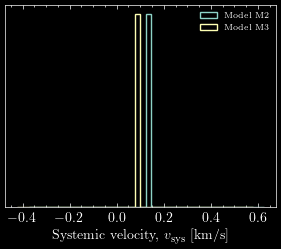

In [74]:
count, bins, ignored = plt.hist(
    w0_case2_dm1.value, 50, density=True, histtype="step", label="Model M2"
)
count, bins, ignored = plt.hist(
    w0_case3_dm1.value, 50, density=True, histtype="step", label="Model M3"
)

plt.yticks([])

plt.xlabel(r"Systemic velocity, $v_\mathrm{sys}$ [km/s]")
plt.legend(loc="upper right", prop={"size": 6})
plt.show()

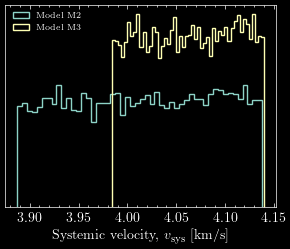

In [75]:
count, bins, ignored = plt.hist(
    w05_case2_dm1.value, 50, density=True, histtype="step", label="Model M2"
)
count, bins, ignored = plt.hist(
    w05_case3_dm1.value, 50, density=True, histtype="step", label="Model M3"
)

plt.yticks([])

plt.xlabel(r"Systemic velocity, $v_\mathrm{sys}$ [km/s]")
plt.legend(loc="upper left", prop={"size": 6})
plt.show()
# plt.savefig("sys_velocity_w5_dm1.pdf", dpi=300, bbox_inches="tight")

In [76]:
w05_case2_dm2 = systemic_velocity(
    model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
    delta_m2,
    model_m2["don_mass"][transition_idx_case2] * u.Msun,
    model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m2,
    5 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w0_case2_dm2 = systemic_velocity(
    model_m2["binary_separation"][transition_idx_case2 - 1] * u.Rsun,
    delta_m2,
    model_m2["don_mass"][transition_idx_case2] * u.Msun,
    model_m2["ns_mass"][transition_idx_case2] * u.Msun - delta_m2,
    0 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w05_case3_dm2 = systemic_velocity(
    model_m3["binary_separation"][transition_idx_case3 - 1] * u.Rsun,
    delta_m2,
    model_m3["don_mass"][transition_idx_case3] * u.Msun,
    model_m3["ns_mass"][transition_idx_case3] * u.Msun - delta_m2,
    5 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

w0_case3_dm2 = systemic_velocity(
    model_m3["binary_separation"][transition_idx_case3 - 1] * u.Rsun,
    delta_m2,
    model_m3["don_mass"][transition_idx_case3] * u.Msun,
    model_m3["ns_mass"][transition_idx_case3] * u.Msun - delta_m2,
    0 * (u.km / u.s),
    theta_dist,
    phi_dist,
)

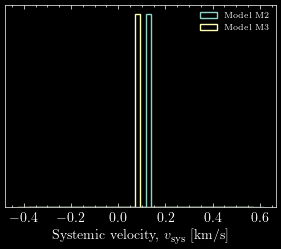

In [77]:
count, bins, ignored = plt.hist(
    w0_case2_dm2.value, 50, density=True, histtype="step", label="Model M2"
)
count, bins, ignored = plt.hist(
    w0_case3_dm2.value, 50, density=True, histtype="step", label="Model M3"
)

plt.yticks([])

plt.xlabel(r"Systemic velocity, $v_\mathrm{sys}$ [km/s]")
plt.legend(loc="upper right", prop={"size": 6})
plt.show()

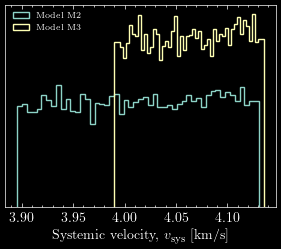

In [78]:
count, bins, ignored = plt.hist(
    w05_case2_dm2.value, 50, density=True, histtype="step", label="Model M2"
)
count, bins, ignored = plt.hist(
    w05_case3_dm2.value, 50, density=True, histtype="step", label="Model M3"
)

plt.yticks([])

plt.xlabel(r"Systemic velocity, $v_\mathrm{sys}$ [km/s]")
plt.legend(loc="upper left", prop={"size": 6})
plt.show()
# plt.savefig("sys_velocity_w5_dm2.pdf", dpi=300, bbox_inches="tight")

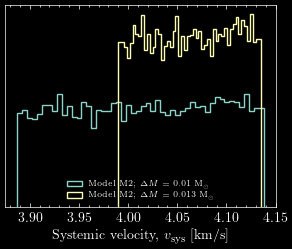

In [79]:
count, bins, ignored = plt.hist(
    w05_case2_dm1.value,
    50,
    density=True,
    histtype="step",
    label=r"Model M2; $\Delta M = 0.01\,\text{M}_\odot$",
)
count, bins, ignored = plt.hist(
    w05_case3_dm2.value,
    50,
    density=True,
    histtype="step",
    label=r"Model M2; $\Delta M = 0.013\,\text{M}_\odot$",
)

plt.yticks([])

plt.xlabel(r"Systemic velocity, $v_\mathrm{sys}$ [km/s]")
plt.legend(loc="lower center", prop={"size": 5.5})
plt.show()
# plt.savefig("sys_velocity_w5_dm2.pdf", dpi=300, bbox_inches="tight")

In [80]:
np.mean(w05_case2_dm1.value)

4.0146538644233445

In [81]:
np.mean(w05_case3_dm2.value)

4.063545522312812

In [82]:
plt.style.use(["default", "science"])

----

In [83]:
num_samples = 1000 # Number of eccentricities to sample per orbital period
num_periods = 10  # Number of different orbital periods to simulate
min_period = 0.1  # Minimum orbital period in days
max_period = 1000  # Maximum orbital period in days

size = num_samples * num_periods

idx1, idx2 = 0, 0

# Orbital periods (logarithmically spaced)
periods = np.logspace(np.log10(min_period), np.log10(max_period), num=num_periods)

m_ns = np.random.choice(a=[m/100 for m in range(140, 156)], size=size)
m_wd = np.zeros(size)


# Draw kick angles from an isotropic distribution
phi_angle = np.random.uniform(0, 2 * np.pi, size) * u.rad
cos_theta_dist = np.random.uniform(-1, 1, size)
theta_angle = np.arccos(cos_theta_dist) * u.rad

pi = np.zeros(size)
ei = np.zeros(size)

for p in periods:
    idx2 += num_samples
    
    e0 = phinney_line(p)
    m2 = mass_period_relation(p)
    samples = np.random.rayleigh(scale=e0/2, size=num_samples)
    
    pi[idx1:idx2] = p
    ei[idx1:idx2] = samples
    m_wd[idx1:idx2] = m2
    
    idx1 = idx2
    
ai = kepler(pi, m_ns, m_wd)

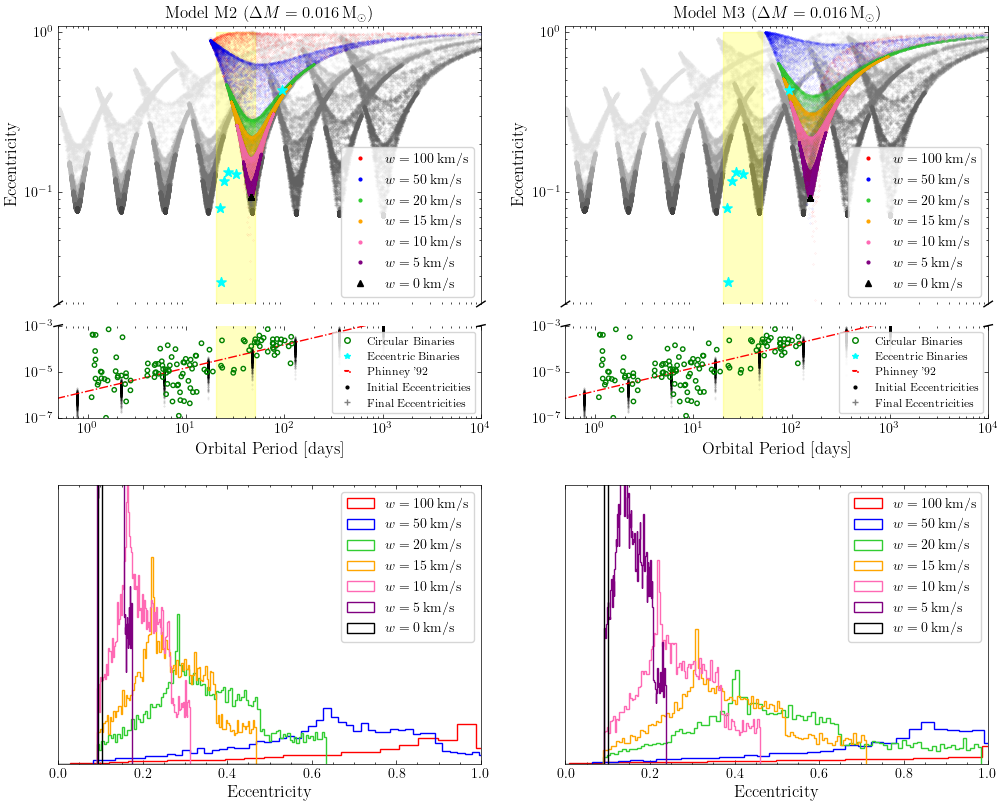

In [84]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1, 3]})

# Adjust the subplots to make space for the breaks
fig.subplots_adjust(hspace=0.1)

# Plot on the first column with broken y-axis : MODEL M2
(ax1_top, ax1_mid, ax1_bottom) = axs[:, 0]

# Plot on the second column with broken y-axis : MODEL M3
(ax2_top, ax2_mid, ax2_bottom) = axs[:, 1]



# MC simulations for post-transition systems with various kicks
# Mass defect
delta_m = 0.016 * u.Msun

# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
# colors = ['#3288bd', '#d53e4f', '#99d594', '#fc8d59', 'cyan', '#d661ac', 'black']
colors = [
    'red',  # Red
    'blue',  # Cyan
    '#32CD32',  # Lime Green
    'orange',
    '#FF69B4',  # Hot Pink
    '#800080',  # Purple
    'black'
]
grayscale_colors = ['#ffffff', '#e0e0e0', '#bdbdbd', '#9e9e9e', '#757575', '#616161', '#424242']



### TOP AND BOTTOM PANELS ###
for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax1_bottom.hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax2_bottom.hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    
    ############
    
    af = a_posttrans(ai,
                 0.01,
                 m_wd,
                 m_ns,
                 w,
                 theta_angle
            )

    # pf = kepler_reverse(af, m_ns, m_wd)
    pf = orbital_period_posttrans(af, m_wd, m_ns)

    ef = eccentricity_posttrans(ai, af, m_wd, m_ns, w, theta_angle, phi_angle)

    
    ############
    
    if w == 0: 
        ax1_top.scatter(
            x_case2_dm1.value[x_case2_dm1.value > 0], 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax2_top.scatter(
            x_case3_dm1.value[x_case3_dm1.value > 0], 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        
        ax1_top.scatter(
            pf.value[pf.value > 0], 
            ef[pf.value > 0], 
            alpha=0.25, 
            marker='+', 
            s=10, 
            c=grayscale_colors[i], 
            zorder=0
        )
        
        ax2_top.scatter(
            pf.value[pf.value > 0], 
            ef[pf.value > 0], 
            alpha=0.25, 
            marker='+', 
            s=10, 
            c=grayscale_colors[i], 
            zorder=0
        )
    else:
        ax1_top.scatter(
            x_case2_dm1.value[x_case2_dm1.value > 0], 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax2_top.scatter(
            x_case3_dm1.value[x_case3_dm1.value > 0], 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        
        ax1_top.scatter(
            pf.value[pf.value > 0], 
            ef[pf.value > 0], 
            alpha=0.25, 
            marker='+', 
            s=10, 
            c=grayscale_colors[i], 
            zorder=0
        )
        
        ax2_top.scatter(
            pf.value[pf.value > 0], 
            ef[pf.value > 0], 
            alpha=0.25, 
            marker='+', 
            s=10, 
            c=grayscale_colors[i], 
            zorder=0
        )

ax1_top.fill_between([20, 50], -1.0, 1.0, alpha=0.25, color="yellow", zorder=0)
ax2_top.fill_between([20, 50], -1.0, 1.0, alpha=0.25, color="yellow", zorder=0)

# ATNF pulsars
ax1_top.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="cyan",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
ax1_top.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="cyan",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)
ax2_top.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="cyan",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
ax2_top.scatter(
    df["PB"][df["NAME"] == "J1903+0327"],
    df["ECC"][df["NAME"] == "J1903+0327"],
    s=50,
    c="cyan",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with MS companion",
)





### MID PANEL ###
# Phinney line + MC for initial eccentricities distribution
ax1_mid.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=10,
    marker="o",
    facecolors='none',
    edgecolors='g',
    label="Circular MSPs",
    zorder=100,
)
ax1_mid.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=1, c='r', ls='-.')
ax1_mid.scatter(pi, ei, color='k', alpha=0.1, s=0.1)
ax1_mid.fill_between([20, 50], -1.0, 1.0, alpha=0.25, color="yellow", zorder=0)

ax2_mid.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=10,
    marker="o",
    facecolors='none',
    edgecolors='g',
    label="Circular MSPs",
    zorder=100,
)
ax2_mid.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=1, c='r', ls='-.')
ax2_mid.scatter(pi, ei, color='k', alpha=0.1, s=0.1)
ax2_mid.fill_between([20, 50], -1.0, 1.0, alpha=0.25, color="yellow", zorder=0)



# Annotations etc
# ax1_top.text(22.5, 0.18, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')
# ax2_top.text(22.5, 0.18, r"$P_{\rm orb} = 20-50$ d", rotation=90, fontsize=fontsize, color='k')





# Plot settings
ax1_top.set_xlim([0.5, 1e4])
ax1_top.set_ylim(2e-2, 1.1)
ax1_top.set_yscale('log')
ax1_top.set_xscale('log')
ax1_top.spines['bottom'].set_visible(False)
ax1_top.tick_params(bottom=False, labelbottom=False)  # Disable x-axis labels

ax1_mid.set_xlim([0.5, 1e4])
ax1_mid.set_ylim(1e-7, 1e-3)
ax1_mid.set_yscale('log')
ax1_mid.set_xscale('log')
ax1_mid.spines['top'].set_visible(False)

ax1_bottom.set_xlim([0, 1])
ax1_bottom.set_ylim([0, 10])
ax1_bottom.yaxis.set_tick_params(labelleft=False)
ax1_bottom.set_yticks([])



ax2_top.set_xlim([0.5, 1e4])
ax2_top.set_ylim(2e-2, 1.1)
ax2_top.set_yscale('log')
ax2_top.set_xscale('log')
ax2_top.spines['bottom'].set_visible(False)
ax2_top.tick_params(bottom=False, labelbottom=False)  # Disable x-axis labels

ax2_mid.set_xlim([0.5, 1e4])
ax2_mid.set_ylim(1e-7, 1e-3)
ax2_mid.set_yscale('log')
ax2_mid.set_xscale('log')
ax2_mid.spines['top'].set_visible(False)

ax2_bottom.set_xlim([0, 1])
ax2_bottom.set_ylim([0, 10])
ax2_bottom.yaxis.set_tick_params(labelleft=False)
ax2_bottom.set_yticks([])




# Labels
fontsize=12
ax1_top.set_ylabel('Eccentricity', fontsize=fontsize)
# ax1_mid.set_ylabel('Eccentricity', fontsize=fontsize)
ax1_mid.set_xlabel('Orbital Period [days]', fontsize=fontsize)
ax1_bottom.set_xlabel('Eccentricity', fontsize=fontsize)

ax2_top.set_ylabel('Eccentricity', fontsize=fontsize)
# ax2_mid.set_ylabel('Eccentricity', fontsize=fontsize)
ax2_mid.set_xlabel('Orbital Period [days]', fontsize=fontsize)
ax2_bottom.set_xlabel('Eccentricity', fontsize=fontsize)





# Break indicators for the first column
d = .01  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1_top.transAxes, color='k', clip_on=False)
ax1_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1_mid.transAxes)  # switch to the mid axes
ax1_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # mid-left diagonal
ax1_mid.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # mid-right diagonal


# Break indicators for the second column
kwargs = dict(transform=ax2_top.transAxes, color='k', clip_on=False)
ax2_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2_mid.transAxes)  # switch to the mid axes
ax2_mid.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # mid-left diagonal
ax2_mid.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # mid-right diagonal



# Add more space between the second and third rows
pos3 = ax1_bottom.get_position()
ax1_bottom.set_position([pos3.x0, pos3.y0 - 0.05, pos3.width, pos3.height])  # Increase y0 to add space
pos4 = ax2_bottom.get_position()
ax2_bottom.set_position([pos4.x0, pos4.y0 - 0.05, pos4.width, pos4.height])  # Increase y0 to add space



# Legends 
kicks_legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

other_legend_elements = [Line2D([0], [0], marker='o', color='g', linestyle='None', label='Circular Binaries',
                          markerfacecolor='None', markersize=4, zorder=10),
                   Line2D([0], [0], marker='*', color='cyan', linestyle='None', label='Eccentric Binaries',
                          markerfacecolor='cyan', markersize=4, zorder=10),
                   Line2D([0], [0], marker='$-.$', color='r', linestyle='None', label="Phinney \'92",
                          markerfacecolor='None', markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color='k', linestyle='None', label='Initial Eccentricities',
                          markerfacecolor='k', markersize=4, zorder=10),
                   Line2D([0], [0], marker='+', color='gray', linestyle='None', label='Final Eccentricities',
                          markerfacecolor='k', markersize=4, zorder=10),
                  ]    

s=10
ax1_top.legend(loc="lower right", handles=kicks_legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax2_top.legend(loc="lower right", handles=kicks_legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax1_mid.legend(loc="lower right", handles=other_legend_elements, prop={"size":s-2}, ncol=1, frameon=True)
ax2_mid.legend(loc="lower right", handles=other_legend_elements, prop={"size":s-2}, ncol=1, frameon=True)
ax1_bottom.legend(loc='upper right', frameon=True)
ax2_bottom.legend(loc='upper right', frameon=True)

ax1_top.set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax2_top.set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))

plt.show()
# plt.savefig("mc_sim2.png", bbox_inches='tight', dpi=300)

In [85]:
def scatter_hist(
    x,
    y,
    ax,
    ax_histx=None,
    ax_histy=None,
    alpha=0.25,
    marker=".",
    label=None,
    s=10,
    c="blue",
    zorder=1,
):
    # The histograms
    bins = 100
    if ax_histx is not None:
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.hist(
            x,
            bins=bins,
            density=True,
            histtype="step",
            orientation="horizontal",
            color=c,
        )
    if ax_histy is not None:
        ax_histy.tick_params(axis="y", labelleft=False)
        ax_histy.hist(
            y,
            bins=bins,
            density=True,
            histtype="step",
            orientation="horizontal",
            color=c,
        )

    # the scatter plot
    ax.scatter(x, y, alpha=alpha, marker=marker, s=s, c=c, label=label, zorder=zorder)

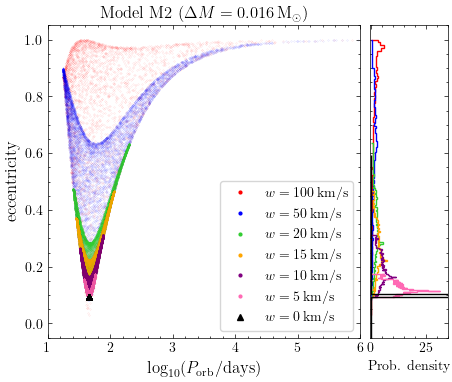

In [86]:
# Start with a square Figure.
fig = plt.figure(figsize=(5, 5))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
# ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = [
    'red',  
    'blue',  
    '#32CD32',  
    'orange',
    '#800080',  
    '#FF69B4',  
    'black'
]

for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    
    if w == 0: 
        scatter_hist(
             x=np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
             y=y_case2_dm1[x_case2_dm1.value > 0].value, 
             ax=ax, 
             # ax_histx=ax_histx, 
             ax_histy=ax_histy, 
             alpha=0.25, 
             marker='^', 
             label=lbl,
             s=10, 
             c=colors[i], 
             zorder=100
        )
        
    else:
        scatter_hist(
             x=np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
             y=y_case2_dm1[x_case2_dm1.value > 0].value, 
             ax=ax, 
             # ax_histx=ax_histx, 
             ax_histy=ax_histy, 
             alpha=0.25, 
             marker='.',
             label=lbl,
             s=0.1, 
             c=colors[i] 
        )
        
ax.set_xlim([1, 6])
ax.set_ylim([-0.05, 1.05])

fontsize=12
ax.set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax.set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax.set_ylabel("eccentricity", fontsize=fontsize)

ax_histy.set_xlim([-0.5, 35])
# ax_histy.set_xscale('log')
ax_histy.set_xlabel("Prob. density")

legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

ax.legend(loc="lower right", handles=legend_elements, prop={"size":10}, ncol=1, frameon=True)

plt.show()
# plt.savefig("figures/mc_sim_m2.png", bbox_inches='tight', dpi=300)

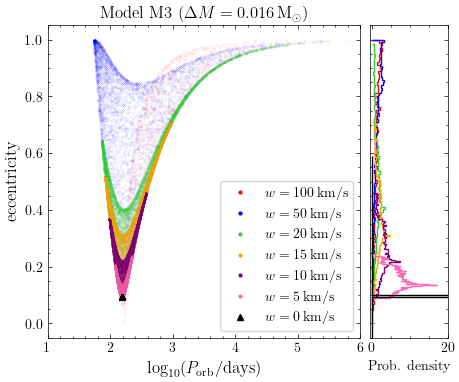

In [87]:
# Start with a square Figure.
fig = plt.figure(figsize=(5, 5))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = [
    'red',  
    'blue',  
    '#32CD32',  
    'orange',
    '#800080',  
    '#FF69B4',  
    'black'
]

for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    
    if w == 0: 
        scatter_hist(
             x=np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
             y=y_case3_dm1[x_case3_dm1.value > 0].value, 
             ax=ax, 
             # ax_histx=ax_histx, 
             ax_histy=ax_histy, 
             alpha=0.25, 
             marker='^', 
             label=lbl,
             s=10, 
             c=colors[i], 
             zorder=100
        )
        
    else:
        scatter_hist(
             x=np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
             y=y_case3_dm1[x_case3_dm1.value > 0].value, 
             ax=ax, 
             # ax_histx=ax_histx, 
             ax_histy=ax_histy, 
             alpha=0.25, 
             marker='.',
             label=lbl,
             s=0.1, 
             c=colors[i] 
        )
        
ax.set_xlim([1, 6])
ax.set_ylim([-0.05, 1.05])

fontsize=12
ax.set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax.set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax.set_ylabel("eccentricity", fontsize=fontsize)

ax_histy.set_xlim([-0.5, 20])
# ax_histy.set_xscale('log')
ax_histy.set_xlabel("Prob. density")

legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

ax.legend(loc="lower right", handles=legend_elements, prop={"size":10}, ncol=1, frameon=True)

plt.show()
# plt.savefig("figures/mc_sim_m3.png", bbox_inches='tight', dpi=300)

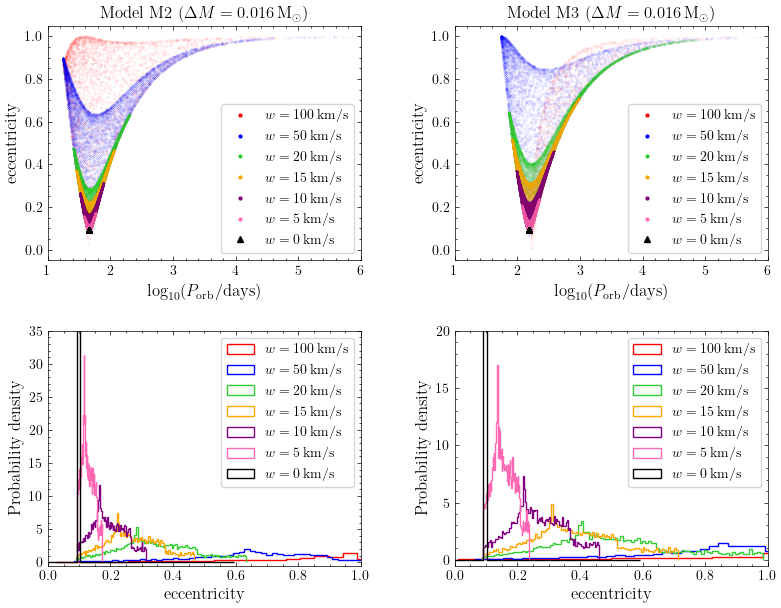

In [88]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(
    left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3
)


# ax[1,0].yaxis.set_tick_params(labelleft=False)
# ax[1,0].set_yticks([])
# ax[1,1].yaxis.set_tick_params(labelleft=False)
# ax[1,1].set_yticks([])


ax[0,0].set_xlim([1, 6])
ax[0,1].set_xlim([1, 6])
ax[0,0].set_ylim([-0.05, 1.05])
ax[0,1].set_ylim([-0.05, 1.05])

ax[1,0].set_xlim([0, 1])
ax[1,1].set_xlim([0, 1])

ax[1,0].set_ylim([-0.5, 35])
ax[1,1].set_ylim([-0.5, 20])

# ax[1,0].set_yscale('log')
# ax[1,1].set_yscale('log')


fontsize=12
ax[0,0].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,0].set_ylabel("eccentricity", fontsize=fontsize)
ax[0,1].set_xlabel(r"$\log_{10}(P_{\rm orb}/\text{days})$", fontsize=fontsize)
ax[0,1].set_ylabel("eccentricity", fontsize=fontsize)
ax[1,0].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,1].set_xlabel("eccentricity", fontsize=fontsize)
ax[1,0].set_ylabel("Probability density", fontsize=fontsize)
ax[1,1].set_ylabel("Probability density", fontsize=fontsize)


# Magnitudes of kick velocity
ws = [100, 50, 20, 15, 10, 5, 0]
colors = [
    'red',  # Red
    'blue',  # Cyan
    '#32CD32',  # Lime Green
    'orange',
    '#800080',  # Purple
    '#FF69B4',  
    'black'
]

for i, w in enumerate(ws):

    ap_case2_dm1 = a_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                delta_m1,
                model_m2["don_mass"][transition_idx_case2-1]*u.Msun, 
                model_m2["ns_mass"][transition_idx_case2-1],
                w*(u.km/u.s),
                theta_dist
    )

    y_case2_dm1 = eccentricity_posttrans(
                model_m2["binary_separation"][transition_idx_case2-1]*u.Rsun,
                ap_case2_dm1,
                model_m2["don_mass"][transition_idx_case2]*u.Msun,
                model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case2_dm1 = orbital_period_posttrans(ap_case2_dm1, 
                                           model_m2["don_mass"][transition_idx_case2]*u.Msun,
                                           model_m2["ns_mass"][transition_idx_case2]*u.Msun - delta_m1
    )
    
    
    ap_case3_dm1 = a_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                delta_m1,
                model_m3["don_mass"][transition_idx_case3-1]*u.Msun, 
                model_m3["ns_mass"][transition_idx_case3-1],
                w*(u.km/u.s),
                theta_dist
    )
    

    y_case3_dm1 = eccentricity_posttrans(
                model_m3["binary_separation"][transition_idx_case3-1]*u.Rsun,
                ap_case3_dm1,
                model_m3["don_mass"][transition_idx_case3]*u.Msun,
                model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1,
                w*(u.km/u.s),
                theta_dist, phi_dist
    )
    
    x_case3_dm1 = orbital_period_posttrans(ap_case3_dm1,
                                           model_m3["don_mass"][transition_idx_case3]*u.Msun,
                                           model_m3["ns_mass"][transition_idx_case3]*u.Msun - delta_m1
    )


    lbl = r'$w=%s\,\mathrm{km/s}$' % (str(w))
    ax[1,0].hist(y_case2_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    ax[1,1].hist(y_case3_dm1.value, 100, density=True, histtype='step', color=colors[i], label=lbl)
    
    if w == 0: 
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='^', 
            s=10, 
            c=colors[i], 
            zorder=100
        )
    else:
        ax[0,0].scatter(
            np.log10(x_case2_dm1.value[x_case2_dm1.value > 0]), 
            y_case2_dm1[x_case2_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )
        ax[0,1].scatter(
            np.log10(x_case3_dm1.value[x_case3_dm1.value > 0]), 
            y_case3_dm1[x_case3_dm1.value > 0], 
            alpha=0.25, 
            marker='.', 
            s=0.1, 
            c=colors[i]
        )


legend_elements = [Line2D([0], [0], marker='.', color=colors[0], linestyle='None', label=r'$w=100\,\mathrm{km/s}$',
                          markerfacecolor=colors[0], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[1], linestyle='None', label=r'$w=50\,\mathrm{km/s}$',
                          markerfacecolor=colors[1], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[2], linestyle='None', label=r'$w=20\,\mathrm{km/s}$',
                          markerfacecolor=colors[2], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[3], linestyle='None', label=r'$w=15\,\mathrm{km/s}$',
                          markerfacecolor=colors[3], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[4], linestyle='None', label=r'$w=10\,\mathrm{km/s}$',
                          markerfacecolor=colors[4], markersize=4, zorder=10),
                   Line2D([0], [0], marker='.', color=colors[5], linestyle='None', label=r'$w=5\,\mathrm{km/s}$',
                          markerfacecolor=colors[5], markersize=4, zorder=10),
                   Line2D([0], [0], marker='^', color=colors[6], linestyle='None', label=r'$w=0\,\mathrm{km/s}$',
                          markerfacecolor=colors[6], markersize=4, zorder=10)
                  ]        

s=10
ax[0,0].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[0,1].legend(loc="lower right", handles=legend_elements, prop={"size":s}, ncol=1, frameon=True)
ax[1,0].legend(loc='upper right', prop={"size":s}, frameon=True)
ax[1,1].legend(loc='upper right', prop={"size":s}, frameon=True)

ax[0,0].set_title(r"Model M2 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))
ax[0,1].set_title(r"Model M3 $(\Delta M = {}\,\rm M_\odot)$".format(delta_m1.value))


plt.show()
# plt.savefig("mc_sim.png", bbox_inches='tight', dpi=300)

In [89]:
# num_samples = 1000 # Number of eccentricities to sample per orbital period
# num_periods = 10  # Number of different orbital periods to simulate
# min_period = 0.1  # Minimum orbital period in days
# max_period = 1000  # Maximum orbital period in days

# kick velocity
w = 0

num_samples = 10 # Number of eccentricities to sample per orbital period
num_periods = 1000  # Number of different orbital periods to simulate
min_period = 0.1  # Minimum orbital period in days
max_period = 1000  # Maximum orbital period in days

size = num_samples * num_periods

idx1, idx2 = 0, 0

# Orbital periods (logarithmically spaced)
periods = np.logspace(np.log10(min_period), np.log10(max_period), num=num_periods)

m_ns = np.random.choice(a=[m/100 for m in range(140, 156)], size=size)
m_wd = np.zeros(size)

theta_angle = np.random.uniform(0., 4*np.pi, size) * u.rad
phi_angle = np.random.uniform(0., 4*np.pi, size) * u.rad

pi = np.zeros(size)
ei = np.zeros(size)

for p in periods:
    idx2 += num_samples
    
    e0 = phinney_line(p)
    m2 = mass_period_relation(p)
    samples = np.random.rayleigh(scale=e0/2, size=num_samples)
    
    pi[idx1:idx2] = p
    ei[idx1:idx2] = samples
    m_wd[idx1:idx2] = m2
    
    idx1 = idx2
    
ai = kepler(pi, m_ns, m_wd)

############

af_dm0p01 = a_posttrans(ai,
             0.01,
             m_wd,
             m_ns,
             w,
             theta_angle
        )

af_dm0p001 = a_posttrans(ai,
             0.0000001,
             m_wd,
             m_ns,
             w,
             theta_angle
        )

pf_dm0p01 = orbital_period_posttrans(af_dm0p01, m_wd, m_ns)

ef_dm0p01 = eccentricity_posttrans(ai, af_dm0p01, m_wd, m_ns, w, theta_angle, phi_angle)

pf_dm0p001 = orbital_period_posttrans(af_dm0p001, m_wd, m_ns)

ef_dm0p001 = eccentricity_posttrans(ai, af_dm0p001, m_wd, m_ns, w, theta_angle, phi_angle)


############

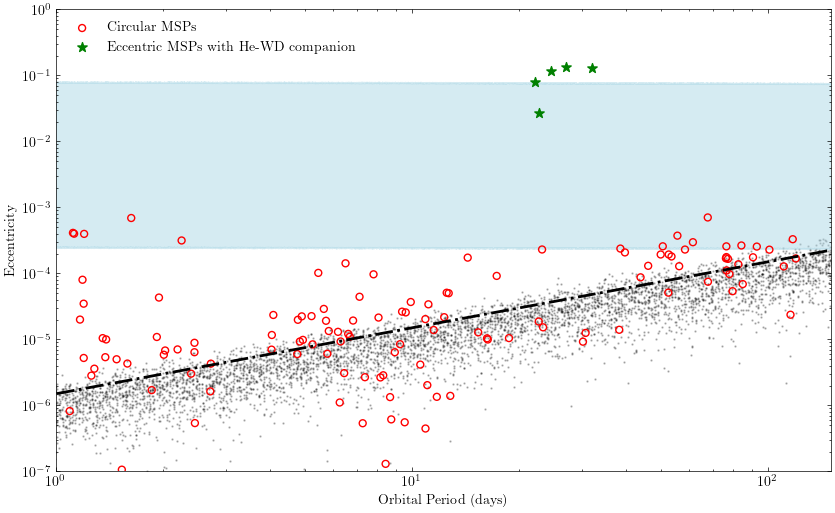

In [90]:
# Parameters
# num_samples = 10 # Number of eccentricities to sample per orbital period
# num_periods = 1000  # Number of different orbital periods to simulate
# min_period = 0.1  # Minimum orbital period in days
# max_period = 50  # Maximum orbital period in days

num_samples = 10 # Number of eccentricities to sample per orbital period
num_periods = 1000  # Number of different orbital periods to simulate
min_period = 0.1  # Minimum orbital period in days
max_period = 1000  # Maximum orbital period in days

# Orbital periods (logarithmically spaced)
periods = np.logspace(np.log10(min_period), np.log10(max_period), num=num_periods)

# Arrays to store results
orbital_periods = []
eccentricities = []

# Loop over orbital periods
for P in periods:
    # Calculate e0 using Phinney line equation
    e0 = phinney_line(P)
    
    # Draw eccentricities from Boltzmann distribution
    samples = np.random.rayleigh(scale=e0/2, size=num_samples)
    
    # Append orbital period and eccentricities to arrays
    orbital_periods.extend([P] * num_samples)
    eccentricities.extend(samples)

# Plotting
plt.figure(figsize=(10, 6))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Eccentricity')

plt.xlim([1, 150])
plt.ylim([1e-7, 1])



plt.plot(np.linspace(0.1, 1000), phinney_line(np.linspace(0.1, 1000)), lw=2, c='k', ls='-.')
plt.scatter(orbital_periods, eccentricities, color='k', alpha=0.25, s=0.5)

# Fill the area 
# A system experiencing a mass defect between 0.001 Msun (lower limit) - 0.01 Msun (upper limit) 
# and without the assistance of a secondary kick,
# would result in an eccentricity within this coloured area 
plt.fill_between(pf_dm0p01.value, ef_dm0p01.value, ef_dm0p001.value, color='lightblue', alpha=0.5)


## Plot ATNF Pulsar Catalogue data ##
#####################################
plt.scatter(
    df["PB"][circular_msp_mask],
    df["ECC"][circular_msp_mask],
    s=25,
    marker="o",
    facecolors='none',
    edgecolors='r',
    label="Circular MSPs",
)
plt.scatter(
    df["PB"][emsp_mask],
    df["ECC"][emsp_mask],
    s=50,
    c="g",
    marker="*",
    zorder=100,
    label="Eccentric MSPs with He-WD companion",
)
#####################################

plt.legend(loc='upper left')

plt.show()

In [91]:
print(delta_m)
print(delta_m1, delta_m2, delta_m3, delta_m4)

0.016 solMass
0.016 solMass 0.015 solMass 0.025 solMass 0.05 solMass
